# Imports

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency, ks_2samp
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load Data and Preprocessing

In [50]:
# Load dataset
df = pd.read_excel("../data/albion_dataset_2024.8.xlsx")

# Filter rows with valid diagnosis and visits
df_cleaned = df[df['DIAGNOSIS'].notna() & (df['DIAGNOSIS'] != 2) & (df['VisitNuA'] != 999)]

# Replace 0 with 1 in IADL columns
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)

# Function to map CDR values
def map_values(val):
    mapping = {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 3, 3.0: 4, 999.0: 999}
    return mapping.get(val, val)

# Apply mapping function to CDR columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)

# Rename column (error)
if 'UODRS3e' in df_cleaned.columns:
    df_cleaned.rename(columns={'UODRS3e': 'UPDRS3e'}, inplace=True)

# Replace invalid values with valid values from other visits
def replace_invalid(group, column):
    valid_values = group[(group[column] != 999) & (~group[column].isna())][column]
    if not valid_values.empty:
        valid_value = valid_values.iloc[0]
        group[column] = group[column].replace(999, valid_value).fillna(valid_value)
    return group

# Apply replacement for MH and FH features
mh_features = [f'MH{i}' for i in range(1, 23)]
fh_features = [f'FH{i}' for i in range(1, 17)]
all_features = mh_features + fh_features
for feature in all_features:
    df_cleaned = df_cleaned.groupby('ID').apply(lambda group: replace_invalid(group, feature)).reset_index(drop=True)

# Last Observation Carried Forward for Marital Status and Living Arrangement
df_cleaned['ΜaritalC'] = df_cleaned.groupby('ID')['ΜaritalC'].fillna(method='ffill')
df_cleaned['Living_Arrangement'] = df_cleaned.groupby('ID')['Living_Arrangement'].fillna(method='ffill')

# Filter for second visit and reset index
df_cleaned = df_cleaned[df_cleaned['VisitNuA'] == 2].reset_index(drop=True)

# List of columns to select
columns = [
    "ID", "SEX", "VisitNuA", "EDU", "AgeC", "ΜaritalC", 
    "Living_Arrangement", "WorkStat", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "CDR_TOT", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "UPDRS_TOT", "MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS", "DIAGNOSIS"
]

# Select the columns from the dataframe
df_cleaned = df_cleaned[columns]

# Replace specific values in columns (error)
df_cleaned['EDU'] = df_cleaned['EDU'].replace(999, 0)

# Replace 999 with NaN
df_cleaned.replace(999, np.nan, inplace=True)

# Drop columns with excessive missing values
missing_percentage = df_cleaned.isnull().mean() * 100
columns_to_keep = missing_percentage[missing_percentage <= 30].index
df_cleaned = df_cleaned[columns_to_keep]

# Remove rows with excessive missing values per group (ID + VisitNuA)
total_columns = df_cleaned.drop(columns=["ID", "VisitNuA"], errors="ignore").shape[1]
thresh_value = 0.3 * total_columns

group_missing = df_cleaned.groupby(['ID']).apply(lambda x: x.isnull().sum().sum())
to_drop = group_missing[group_missing > thresh_value].index
df_cleaned = df_cleaned[~df_cleaned.set_index(['ID']).index.isin(to_drop)].reset_index(drop=True)

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2493972577.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('ID').apply(lambda group, f=feature: replace_invalid(group, f)).reset_index(drop=True)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2493972577.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('

# Train and Test Split

In [69]:
# Dataframe is saved for our train test split approach. This dataset is used in the notebook: Data Preparation - Voting-Based Hybrid Model - 1st Visit.ipynb
# df_cleaned[['ID', 'DIAGNOSIS']].to_csv('../data/secondvisit_traintestsplit_helper.csv', index=False)

In [70]:
# Train and test IDs from previous step
train_ids = [8409, 7737, 7333, 6761, 6385, 7851, 6389, 8537, 6961, 7267, 8430,
       8456, 8494, 7879, 7126, 8016, 6105, 6762, 6130, 6060, 7150, 6402,
       8514, 6949, 7690, 6162, 6253, 8244, 6053, 6869, 8177, 6519, 7889,
       8408, 8219, 6153, 6284, 6269, 7555, 6466, 6322, 8545, 6486, 6520,
       6615, 6669, 8491, 8096, 6172, 6072, 6610, 6609, 6661, 7823, 6446,
       6087, 8280, 7653, 7433, 5936, 7982, 5564, 8263, 7731, 5508, 6906,
       6697, 5902, 6979, 6498, 6051, 8457, 7481, 6256, 6533, 7712, 6369,
       6683, 7019, 6784, 4393, 8470, 6604, 6306, 6212, 7188, 6287, 7376,
       6444, 6709, 8115, 6634, 7902, 6653, 7532, 8330, 8348, 7241, 5992,
       6058, 6313, 6622, 6074, 6394, 6731, 6878, 8035, 6337, 6276, 6393,
       7075, 6617, 8351, 6970, 6879, 8528, 8040, 8258, 8519, 6371, 6090,
       6608, 7142, 8118, 6093, 7813, 6435, 8154, 6312, 6478, 6525, 7281,
       6195, 5954, 6317, 7811, 6210, 7160, 8058, 6626, 6042, 6480, 6440,
       5419, 8262, 7151, 5369, 8081, 6712, 7634, 7945, 6627, 6410, 8385,
       7084, 8554, 6569, 8477, 6171, 8547, 8090, 6675, 6113, 6549, 8490,
       5455, 7104, 7235, 7051, 6876, 6268, 8259, 8026, 6155, 8564, 8233,
       7200, 8123, 6524, 6531, 6529, 6127, 7412, 6750, 8024, 6969, 8266,
       6333, 6375]
test_ids = [6568, 6490, 6991, 7063, 7826, 6779, 6999, 8097, 6589, 6548, 6208,
       8114, 7076, 7039, 7965, 6621, 7073, 7068, 6721, 6050, 8059, 6690,
       7193, 7619, 6521, 8400, 7315, 6377, 6693, 8212, 6164, 7323, 8373,
       6199, 8489, 6600, 6103, 6987, 6413, 6564, 5111, 6416, 7912, 8575,
       8471, 7800, 6226, 8502]

# Assign rows to train or test set based on IDs
train_df = df_cleaned[df_cleaned['ID'].isin(train_ids)].copy()
test_df = df_cleaned[df_cleaned['ID'].isin(test_ids)].copy()

# Verify no overlap
overlapping_ids = set(train_df['ID']).intersection(set(test_df['ID']))
if overlapping_ids:
    print(f"Overlapping IDs found: {overlapping_ids}")
else:
    print("No overlapping IDs. Train and test sets are correctly split!")

# Verify distribution
print("\nTrain DIAGNOSIS distribution:")
print(train_df['DIAGNOSIS'].value_counts(normalize=True))
print("\nTest DIAGNOSIS distribution:")
print(test_df['DIAGNOSIS'].value_counts(normalize=True))


No overlapping IDs. Train and test sets are correctly split!

Train DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.734694
1.0    0.265306
Name: proportion, dtype: float64

Test DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.782609
1.0    0.217391
Name: proportion, dtype: float64


In [74]:
# Save as baseline datasets
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
original_stats_train = train_df.describe()
original_stats_test = test_df.describe()

# MICE Implementation

In [76]:
def perform_imputation_and_analysis(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Replace special missing values in the target column for training and test sets
    for df_encoded in [train_df_encoded, test_df_encoded]:
        if target_column.startswith('IADL'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        else:
            print(f"No special replacements for {target_column}, continuing...")

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1).round()

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [77]:
def perform_imputation_and_analysis_unrounded(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1)

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [78]:
def chi_square_test(feature, target):
    data = df_cleaned[[feature, target]].replace(999, np.nan).dropna()
    data = df_cleaned[[feature, target]].replace(99, np.nan).dropna()
    contingency_table = pd.crosstab(data[feature], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [79]:
def process_feature(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


In [80]:
def process_feature_unrounded(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis_unrounded(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


# Imputation

Workaround for the values of IADL5 which contain 99. These are processed fine for the other IADL features.

In [83]:
iadl5_99_indices_train = train_df_copy[train_df_copy['IADL5'] == 99].index
iadl5_99_indices_test = test_df_copy[test_df_copy['IADL5'] == 99].index

test_df_copy['IADL5'].replace(99, np.nan, inplace=True)
train_df_copy['IADL5'].replace(99, np.nan, inplace=True)

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2739285136.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy['IADL5'].replace(99, np.nan, inplace=True)


In [84]:
# List of target columns to impute
target_columns = ["Living_Arrangement","WorkStat","ΜaritalC", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8",  
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")


Significant Correlations with Living_Arrangement (|correlation| > 0.1):
SEX        -0.259740
AgeC       -0.113519
ΜaritalC   -0.401535
MH2        -0.242245
MH12       -0.163322
MH13       -0.112947
MH18       -0.112947
MH22       -0.138426
SMOKING    -0.119290
MED5       -0.153180
MED7       -0.122929
MED12      -0.124779
MED13      -0.209111
MED20      -0.150555
MED21      -0.150555
FH6        -0.213648
FH9         0.111088
NPI5       -0.201187
NPI9        0.228598
IADL3       0.121826
IADL4       0.189096
IADL5      -0.152181
IADL8      -0.219251
IADL_TOT   -0.246113
MMSE       -0.131233
ZAS         0.116115
Name: Living_Arrangement, dtype: float64

Chi-Squared Test Results for Living_Arrangement:
SEX: Chi2: 5.741469017094018, p-value: 0.05665729602453878
AgeC: Chi2: 62.94621031746033, p-value: 0.7124567100872442
ΜaritalC: Chi2: 82.5824544254924, p-value: 1.0451080719845164e-15
MH2: Chi2: 2.04152688172043, p-value: 0.360319752319955
MH12: Chi2: 5.455946313285763, p-value: 0.065351613

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL1 in training set:
94    1.0
dtype: float64
Imputed Values for IADL1 in test set:
0    1.0
dtype: float64
Finished processing IADL1

Significant Correlations with IADL2 (|correlation| > 0.1):
Series([], Name: IADL2, dtype: float64)

Chi-Squared Test Results for IADL2:
No significant correlations for IADL2. Using all columns for imputation.


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL2 in training set:
94    1.0
dtype: float64
Imputed Values for IADL2 in test set:
0    1.0
dtype: float64
Finished processing IADL2

Significant Correlations with IADL3 (|correlation| > 0.1):
ID                   -0.115800
SEX                  -0.413900
AgeC                  0.176268
ΜaritalC             -0.144996
Living_Arrangement    0.121826
MH7                  -0.117211
MH10                  0.352639
MH16                  0.202907
MH18                  0.111091
MH20                  0.183843
MH22                 -0.144787
MED3                  0.147074
MED9                 -0.112412
MED18                 0.289384
MED23                 0.110456
NPI4                 -0.113127
NPI5                 -0.165791
NPI_TOT              -0.154209
CDR5                  0.318342
IADL4                 0.754467
IADL_TOT             -0.781740
ZEX                   0.186146
ZLA                  -0.188393
Name: IADL3, dtype: float64

Chi-Squared Test Results for IADL3:
ID: Chi

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL3 in training set:
7     1.0
10    1.0
94    1.0
dtype: float64
Imputed Values for IADL3 in test set:
0    1.0
dtype: float64
Finished processing IADL3

Significant Correlations with IADL4 (|correlation| > 0.1):
ID                   -0.181679
SEX                  -0.413900
AgeC                  0.180488
ΜaritalC             -0.144996
Living_Arrangement    0.189096
WorkStat              0.144038
MH1                   0.111091
MH10                  0.352639
MH16                  0.202907
MH18                  0.111091
MH20                  0.183843
MH22                 -0.144787
MED2                  0.318832
MED3                  0.147074
MED18                 0.289384
MED23                 0.289597
FH14                 -0.123112
NPI4                 -0.113127
NPI_TOT              -0.109759
CDR1                  0.112578
CDR5                  0.318342
IADL3                 0.754467
IADL5                 1.000000
IADL_TOT             -0.857333
ZME                  

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL4 in training set:
7     1.0
10    1.0
94    1.0
dtype: float64
Imputed Values for IADL4 in test set:
0    1.0
dtype: float64
Finished processing IADL4

Significant Correlations with IADL5 (|correlation| > 0.1):
Living_Arrangement   -0.152181
MH22                  0.226285
SMOKING               0.166350
MED4                  0.147264
NPI5                  0.131030
NPI12                 0.702617
NPI_TOT               0.152606
CDR1                  0.533002
CDR2                  1.000000
CDR3                  0.570088
CDR_TOT               0.712474
IADL4                 1.000000
IADL8                 0.702834
IADL_TOT              0.917523
ZME                  -0.297361
ZEX                  -0.123157
DIAGNOSIS             0.203021
Name: IADL5, dtype: float64

Chi-Squared Test Results for IADL5:
Living_Arrangement: Chi2: 2.576741041244084, p-value: 0.2757196968026406
MH22: Chi2: 0.5679086538461539, p-value: 0.4510911604261969
SMOKING: Chi2: 3.4074519230769234, p-val

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL5 in training set:
2     2.0
6     2.0
7     2.0
9     2.0
10    2.0
16    2.0
30    2.0
32    2.0
36    2.0
64    2.0
66    1.0
70    1.0
74    2.0
94    1.0
dtype: float64
Imputed Values for IADL5 in test set:
0    1.0
3    1.0
dtype: float64
Finished processing IADL5

Significant Correlations with IADL6 (|correlation| > 0.1):
Series([], Name: IADL6, dtype: float64)

Chi-Squared Test Results for IADL6:
No significant correlations for IADL6. Using all columns for imputation.


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL6 in training set:
94    1.0
dtype: float64
Imputed Values for IADL6 in test set:
0    1.0
dtype: float64
Finished processing IADL6

Significant Correlations with IADL7 (|correlation| > 0.1):
Series([], Name: IADL7, dtype: float64)

Chi-Squared Test Results for IADL7:
No significant correlations for IADL7. Using all columns for imputation.


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL7 in training set:
94    1.0
dtype: float64
Imputed Values for IADL7 in test set:
0    1.0
dtype: float64
Finished processing IADL7

Significant Correlations with IADL8 (|correlation| > 0.1):
SEX                   0.116445
ΜaritalC              0.208045
Living_Arrangement   -0.219251
MH8                  -0.116445
MH9                  -0.111465
MH22                  0.130989
SMOKING               0.222375
MED11                -0.123278
MED12                -0.105569
NPI5                  0.189185
NPI12                 0.488764
NPI_TOT               0.138760
CDR1                  0.412941
CDR2                  0.703295
CDR3                  0.491869
CDR_TOT               0.535815
IADL5                 0.702834
IADL_TOT              0.400011
HACH5                -0.121547
HACH_TOT             -0.113319
ZME                  -0.165701
Name: IADL8, dtype: float64

Chi-Squared Test Results for IADL8:
SEX: Chi2: 0.09438940688940685, p-value: 0.7586693850205397
ΜaritalC:

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97195/2014202347.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL8 in training set:
94    1.0
dtype: float64
Imputed Values for IADL8 in test set:
0    1.0
dtype: float64
Finished processing IADL8

Significant Correlations with MED7 (|correlation| > 0.1):
ID                   -0.173100
EDU                   0.180276
AgeC                  0.404930
Living_Arrangement   -0.122929
WorkStat              0.306608
MH3                   0.137809
MH8                   0.419548
MH9                   0.331217
MH10                  0.230910
MH19                  0.177145
MH20                  0.319894
MED3                  0.230910
MED5                  0.252828
MED6                  0.137809
MED8                  0.314756
MED9                  0.111239
MED11                 0.385028
MED12                 0.355796
MED18                 0.132968
FH6                   0.129930
FH8                   0.141282
FH15                 -0.106074
NPI5                 -0.153821
NPI11                 0.279505
CDR5                  0.220688
IADL_TOT   

In [85]:
# Change back
train_df.loc[iadl5_99_indices_train, 'IADL5'] = 99
test_df.loc[iadl5_99_indices_test, 'IADL5'] = 99


In [86]:
# List of target columns to impute
target_columns = ["MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature_unrounded(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")

Significant Correlations with MMSE (|correlation| > 0.1):
EDU                   0.166140
AgeC                 -0.280439
Living_Arrangement   -0.131233
WorkStat             -0.289979
MH3                  -0.276487
MH5                  -0.147136
MH7                  -0.242118
MH8                  -0.170029
MH16                  0.101729
MH22                 -0.133317
MED1                 -0.198205
MED3                  0.142292
MED4                 -0.142931
MED6                  0.123507
MED9                 -0.170210
MED10                -0.357025
MED11                -0.128224
MED21                 0.100571
MED23                -0.410380
MED25                -0.121796
FH8                   0.125134
NPI9                 -0.136008
NPI11                -0.101515
CDR1                 -0.571574
CDR2                 -0.104371
CDR3                 -0.238833
CDR_TOT              -0.456275
HACH5                -0.231361
HACH8                -0.250847
HACH_TOT             -0.297190
ZME         

# Post-Imputation Data Refinement

In [98]:
# Function to map CDR values back
def map_values(val):
    mapping = {
        0.0: 0,
        1: 0.5,
        2: 1,
        3: 2,
        4: 3,
        999.0: 999
    }
    return mapping.get(val, val)

# Define lists of columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
npi_columns = [f'NPI{i}' for i in range(1, 13)]
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
hach_columns = [f'HACH{i}' for i in range(1, 9)]
updrs_columns = [
    "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", "UPDRS3d", "UPDRS3e",
    "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e",
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b",
    "UPDRS10", "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"
]

# Apply mapping function to CDR columns in train_df and test_df
for col in cdr_columns:
    train_df[col] = train_df[col].apply(map_values)
    test_df[col] = test_df[col].apply(map_values)

# Calculate total scores for each dataset
score_columns = {
    'CDR_TOT': cdr_columns,
    'NPI_TOT': npi_columns,
    'IADL_TOT': iadl_columns,
    'HACH_TOT': hach_columns,
    'UPDRS_TOT': updrs_columns
}

for score_col, columns in score_columns.items():
    if score_col == 'IADL_TOT':
        train_df[score_col] = train_df[columns].replace(99, np.nan).sum(axis=1)
        test_df[score_col] = test_df[columns].replace(99, np.nan).sum(axis=1)
    else:
        train_df[score_col] = train_df[columns].sum(axis=1)
        test_df[score_col] = test_df[columns].sum(axis=1)

# Save the refined datasets to CSV
train_df.to_csv('../data/train_df_imputed_2ndvisit.csv', index=False)
test_df.to_csv('../data/test_df_imputed_2ndvisit.csv', index=False)


# Data Comparison: Pre- and Post-Imputation

In [99]:
new_stats_train = train_df.describe()
new_stats_test = test_df.describe()

In [100]:
original_stats_test

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,23.000000,23.000000,23.0,23.000000,23.000000,22.000000,22.000000,22.000000,23.0,23.000000,23.000000,23.0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.000000,23.0,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.0,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.000000,23.0,23.0,23.000000,23.000000,23.0,22.0,22.000000,22.0,22.000000,22.000000,22.0,22.0,22.0,22.0,23.000000,22.000000,22.0,21.0,21.0,21.0,21.000000,21.000000,21.0,21.0,21.0,21.0,21.0,21.000000,21.0,21.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0,23.000000,22.0,22.0,22.000000,22.000000,22.000000,22.0,22.000000,22.0,22.000000,22.0,22.0,22.0,22.000000,22.000000,22.000000,22.0,22.0,22.000000,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.000000,21.000000,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.000000,22.000000,22.000000,19.000000,22.000000,22.000000,21.000000,23.000000
mean,6538.565217,1.826087,2.0,13.347826,65.173913,1.318182,0.909091,2.363636,0.0,0.391304,0.043478,0.0,0.043478,0.0,0.0,0.391304,0.478261,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.086957,0.130435,0.086957,0.217391,0.217391,0.434783,0.086957,0.0,0.0,0.0,0.434783,0.260870,0.0,0.217391,0.0,0.0,0.0,0.434783,0.434783,0.347826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.130435,0.0,0.0,0.045455,0.0,0.181818,0.090909,0.0,0.0,0.0,0.0,0.391304,0.136364,0.0,0.0,0.0,0.0,1.238095,0.952381,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,2.476190,0.304348,0.043478,0.086957,0.086957,0.0,0.0,0.260870,1.0,1.0,5.454545,5.454545,5.454545,1.0,1.045455,1.0,7.909091,0.0,0.0,0.0,0.045455,0.409091,0.045455,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,28.545455,-0.091054,-0.070057,0.086027,-0.416482,-0.172374,0.217391
std,463.594535,0.387553,0.0,4.249157,10.477908,0.567900,0.526361,0.953463,0.0,0.499011,0.208514,0.0,0.208514,0.0,0.0,0.499011,0.510754,0.208514,0.0,0.208514,0.0,0.208514,0.0,0.0,0.0,0.288104,0.344350,0.288104,0.421741,0.421741,0.787752,0.417029,0.0,0.0,0.0,0.506870,0.448978,0.0,0.421741,0.0,0.0,0.0,0.506870,0.506870,0.486985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208514,0.0,0.0,0.208514,0.344350,0.0,0.0,0.213201,0.0,0.394771,0.294245,0.0,0.0,0.0,0.0,0.499011,0.351250,0.0,0.0,0.0,0.0,2.861901,2.155834,0.0,0.0,0.0,0.0,0.0,0.956183,0.0,4.600207,0.470472,0.208514,0.288104,0.288104,0.0,0.0,0.519387,0.0,0.0,20.893670,20.893670,20.893670,0.0,0.213201,0.0,0.683763,0.0,0.0,0.0,0.213201,0.503236,0.213201,0.0,0.0,0.597614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218218,0.218218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436436,1.844613,0.944153,0.905772,0.960129,0.989410,1.353092,0.421741
min,5111.000000,1.000000,2.0,6.000000,41.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000

In [101]:
original_stats_train

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,98.000000,98.000000,98.0,98.000000,98.000000,97.000000,96.000000,95.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.0,98.0,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0,97.0,97.0,97.000000,97.0,97.000000,97.000000,97.0,97.000000,97.0,97.000000,97.0,96.0,96.000000,96.0,96.000000,96.000000,95.0,96.0,96.0,96.0,96.000000,96.000000,96.0,92.0,92.0,92.0,92.000000,92.000000,92.0,92.0,92.000000,92.000000,92.0,92.000000,92.000000,92.000000,95.000000,95.000000,95.000000,95.0,95.000000,95.0,95.000000,97.0,97.0,95.000000,95.000000,95.000000,97.0,97.0,97.000000,97.000000,97.0,97.0,97.0,97.0,97.000000,97.0,97.0,97.000000,97.000000,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,95.000000,95.000000,90.000000,95.000000,95.000000,94.000000,98.000000
mean,6437.326531,1.612245,2.0,13.795918,65.061224,1.371134,0.791667,2.326316,0.040816,0.163265,0.051020,0.010204,0.020408,0.0,0.112245,0.387755,0.367347,0.030612,0.0,0.081633,0.040816,0.0,0.0,0.020408,0.0,0.040816,0.040816,0.091837,0.234694,0.163265,0.734694,0.132653,0.030612,0.010204,0.030612,0.357143,0.153061,0.051020,0.175258,0.020619,0.103093,0.051546,0.412371,0.340206,0.185567,0.0,0.0,0.0,0.0,0.092784,0.0,0.010309,0.010309,0.0,0.051546,0.0,0.041237,0.0,0.0,0.020833,0.0,0.187500,0.072917,0.0,0.0,0.0,0.0,0.291667,0.052083,0.0,0.0,0.0,0.0,0.586957,1.217391,0.0,0.0,0.021739,0.065217,0.0,0.543478,0.086957,2.521739,0.200000,0.021053,0.042105,0.0,0.010526,0.0,0.136842,1.0,1.0,10.294737,10.294737,12.357895,1.0,1.0,1.020619,7.690722,0.0,0.0,0.0,0.0,0.412371,0.0,0.0,0.020619,0.432990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.273684,-0.264047,-0.137034,-0.386760,-0.233015,-0.293242,0.265306
std,464.164981,0.489743,0.0,6.644057,8.809339,0.820564,0.541279,0.916075,0.198882,0.371508,0.221171,0.101015,0.142119,0.0,0.317290,0.489743,0.484561,0.173150,0.0,0.275212,0.198882,0.0,0.0,0.142119,0.0,0.198882,0.198882,0.290280,0.425986,0.371508,0.844033,0.445776,0.173150,0.101015,0.173150,0.481621,0.361898,0.221171,0.382162,0.142842,0.305660,0.222258,0.494819,0.476240,0.390776,0.0,0.0,0.0,0.0,0.291636,0.0,0.101535,0.101535,0.0,0.222258,0.0,0.199871,0.0,0.0,0.143576,0.0,0.392361,0.261365,0.0,0.0,0.0,0.0,0.456916,0.223361,0.0,0.0,0.0,0.0,1.555933,2.198032,0.0,0.0,0.208514,0.464198,0.0,1.571819,0.586518,3.737185,0.451946,0.144321,0.201895,0.0,0.102598,0.0,0.360571,0.0,0.0,28.848420,28.848420,31.519975,0.0,0.0,0.142842,1.024297,0.0,0.0,0.0,0.0,0.494819,0.0,0.0,0.203069,0.557285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.777173,1.059558,0.891506,2.717764,0.970888,1.191921,0.443766
min,4393.000000,1.000000,2.0,6.000000,44.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0

In [102]:
new_stats_train

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.0,98.0,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.0,98.0,98.0,98.000000,98.0,98.000000,98.000000,98.0,98.000000,98.0,98.000000,98.0,98.0,98.000000,98.0,98.000000,98.000000,98.0,98.0,98.0,98.0,98.000000,98.000000,98.0,98.0,98.0,98.0,98.000000,98.000000,98.0,98.0,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.0,98.000000,98.0,98.0,98.000000,98.000000,98.000000,98.0,98.0,98.000000,98.000000,98.0,98.0,98.0,98.0,98.000000,98.0,98.0,98.000000,98.000000,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,6437.326531,1.612245,2.0,13.795918,65.061224,1.367347,0.785714,2.306122,0.040816,0.163265,0.051020,0.010204,0.020408,0.0,0.112245,0.387755,0.367347,0.030612,0.0,0.081633,0.040816,0.0,0.0,0.020408,0.0,0.040816,0.040816,0.091837,0.234694,0.163265,0.734694,0.132653,0.030612,0.010204,0.030612,0.357143,0.153061,0.051020,0.173469,0.020408,0.102041,0.051020,0.418367,0.346939,0.183673,0.0,0.0,0.0,0.0,0.091837,0.0,0.010204,0.010204,0.0,0.051020,0.0,0.040816,0.0,0.0,0.020408,0.0,0.183673,0.071429,0.0,0.0,0.0,0.0,0.285714,0.051020,0.0,0.0,0.0,0.0,0.561224,1.224490,0.0,0.0,0.020408,0.061224,0.0,0.591837,0.081633,2.540816,0.096939,0.015306,0.020408,0.0,0.005102,0.0,0.137755,1.0,1.0,10.010204,10.010204,12.030612,1.0,1.0,1.020408,7.775510,0.0,0.0,0.0,0.0,0.408163,0.0,0.0,0.020408,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.270354,-0.258909,-0.187958,-0.408047,-0.233981,-0.280643,0.265306
std,464.164981,0.489743,0.0,6.644057,8.809339,0.817183,0.542047,0.912775,0.198882,0.371508,0.221171,0.101015,0.142119,0.0,0.317290,0.489743,0.484561,0.173150,0.0,0.275212,0.198882,0.0,0.0,0.142119,0.0,0.198882,0.198882,0.290280,0.425986,0.371508,0.844033,0.445776,0.173150,0.101015,0.173150,0.481621,0.361898,0.221171,0.380599,0.142119,0.304258,0.221171,0.495827,0.478443,0.389209,0.0,0.0,0.0,0.0,0.290280,0.0,0.101015,0.101015,0.0,0.221171,0.0,0.198882,0.0,0.0,0.142119,0.0,0.389209,0.258863,0.0,0.0,0.0,0.0,0.454077,0.221171,0.0,0.0,0.0,0.0,1.513284,2.151627,0.0,0.0,0.202031,0.449887,0.0,1.552097,0.568475,3.652900,0.223124,0.086575,0.099441,0.0,0.050508,0.0,0.357400,0.0,0.0,28.444373,28.444373,31.084008,0.0,0.0,0.142119,0.958205,0.0,0.0,0.0,0.0,0.494021,0.0,0.0,0.202031,0.556128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.751475,1.047931,0.935147,2.687540,0.965763,1.194563,0.443766
min,4393.000000,1.000000,2.0,6.000000,44.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0

In [103]:
new_stats_test

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,23.000000,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.000000,23.0,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.0,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.000000,23.0,23.0,23.000000,23.000000,23.0,23.0,23.000000,23.0,23.000000,23.000000,23.0,23.0,23.0,23.0,23.000000,23.000000,23.0,23.0,23.0,23.0,23.000000,23.000000,23.0,23.0,23.0,23.0,23.0,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.000000,23.0,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.0,23.0,23.000000,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.000000,23.000000,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,6538.565217,1.826087,2.0,13.347826,65.173913,1.304348,0.956522,2.304348,0.0,0.391304,0.043478,0.0,0.043478,0.0,0.0,0.391304,0.478261,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.086957,0.130435,0.086957,0.217391,0.217391,0.434783,0.086957,0.0,0.0,0.0,0.434783,0.260870,0.0,0.217391,0.0,0.0,0.0,0.434783,0.434783,0.347826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.130435,0.0,0.0,0.043478,0.0,0.217391,0.086957,0.0,0.0,0.0,0.0,0.391304,0.130435,0.0,0.0,0.0,0.0,1.260870,1.217391,0.0,0.0,0.0,0.0,0.0,0.260870,0.0,2.739130,0.152174,0.021739,0.043478,0.043478,0.0,0.0,0.260870,1.0,1.0,5.260870,5.260870,5.260870,1.0,1.043478,1.0,7.913043,0.0,0.0,0.0,0.043478,0.391304,0.043478,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,28.396757,-0.188519,-0.209292,0.113491,-0.483886,-0.415664,0.217391
std,463.594535,0.387553,0.0,4.249157,10.477908,0.558796,0.562322,0.973970,0.0,0.499011,0.208514,0.0,0.208514,0.0,0.0,0.499011,0.510754,0.208514,0.0,0.208514,0.0,0.208514,0.0,0.0,0.0,0.288104,0.344350,0.288104,0.421741,0.421741,0.787752,0.417029,0.0,0.0,0.0,0.506870,0.448978,0.0,0.421741,0.0,0.0,0.0,0.506870,0.506870,0.486985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208514,0.0,0.0,0.208514,0.344350,0.0,0.0,0.208514,0.0,0.421741,0.288104,0.0,0.0,0.0,0.0,0.499011,0.344350,0.0,0.0,0.0,0.0,2.766971,2.539802,0.0,0.0,0.0,0.0,0.0,0.915393,0.0,4.769385,0.235236,0.104257,0.144052,0.144052,0.0,0.0,0.519387,0.0,0.0,20.434413,20.434413,20.434413,0.0,0.208514,0.0,0.668312,0.0,0.0,0.0,0.208514,0.499011,0.208514,0.0,0.0,0.593109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208514,0.208514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417029,1.938166,1.034115,0.928800,0.947256,1.019281,1.523193,0.421741
min,5111.000000,1.000000,2.0,6.000000,41.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000

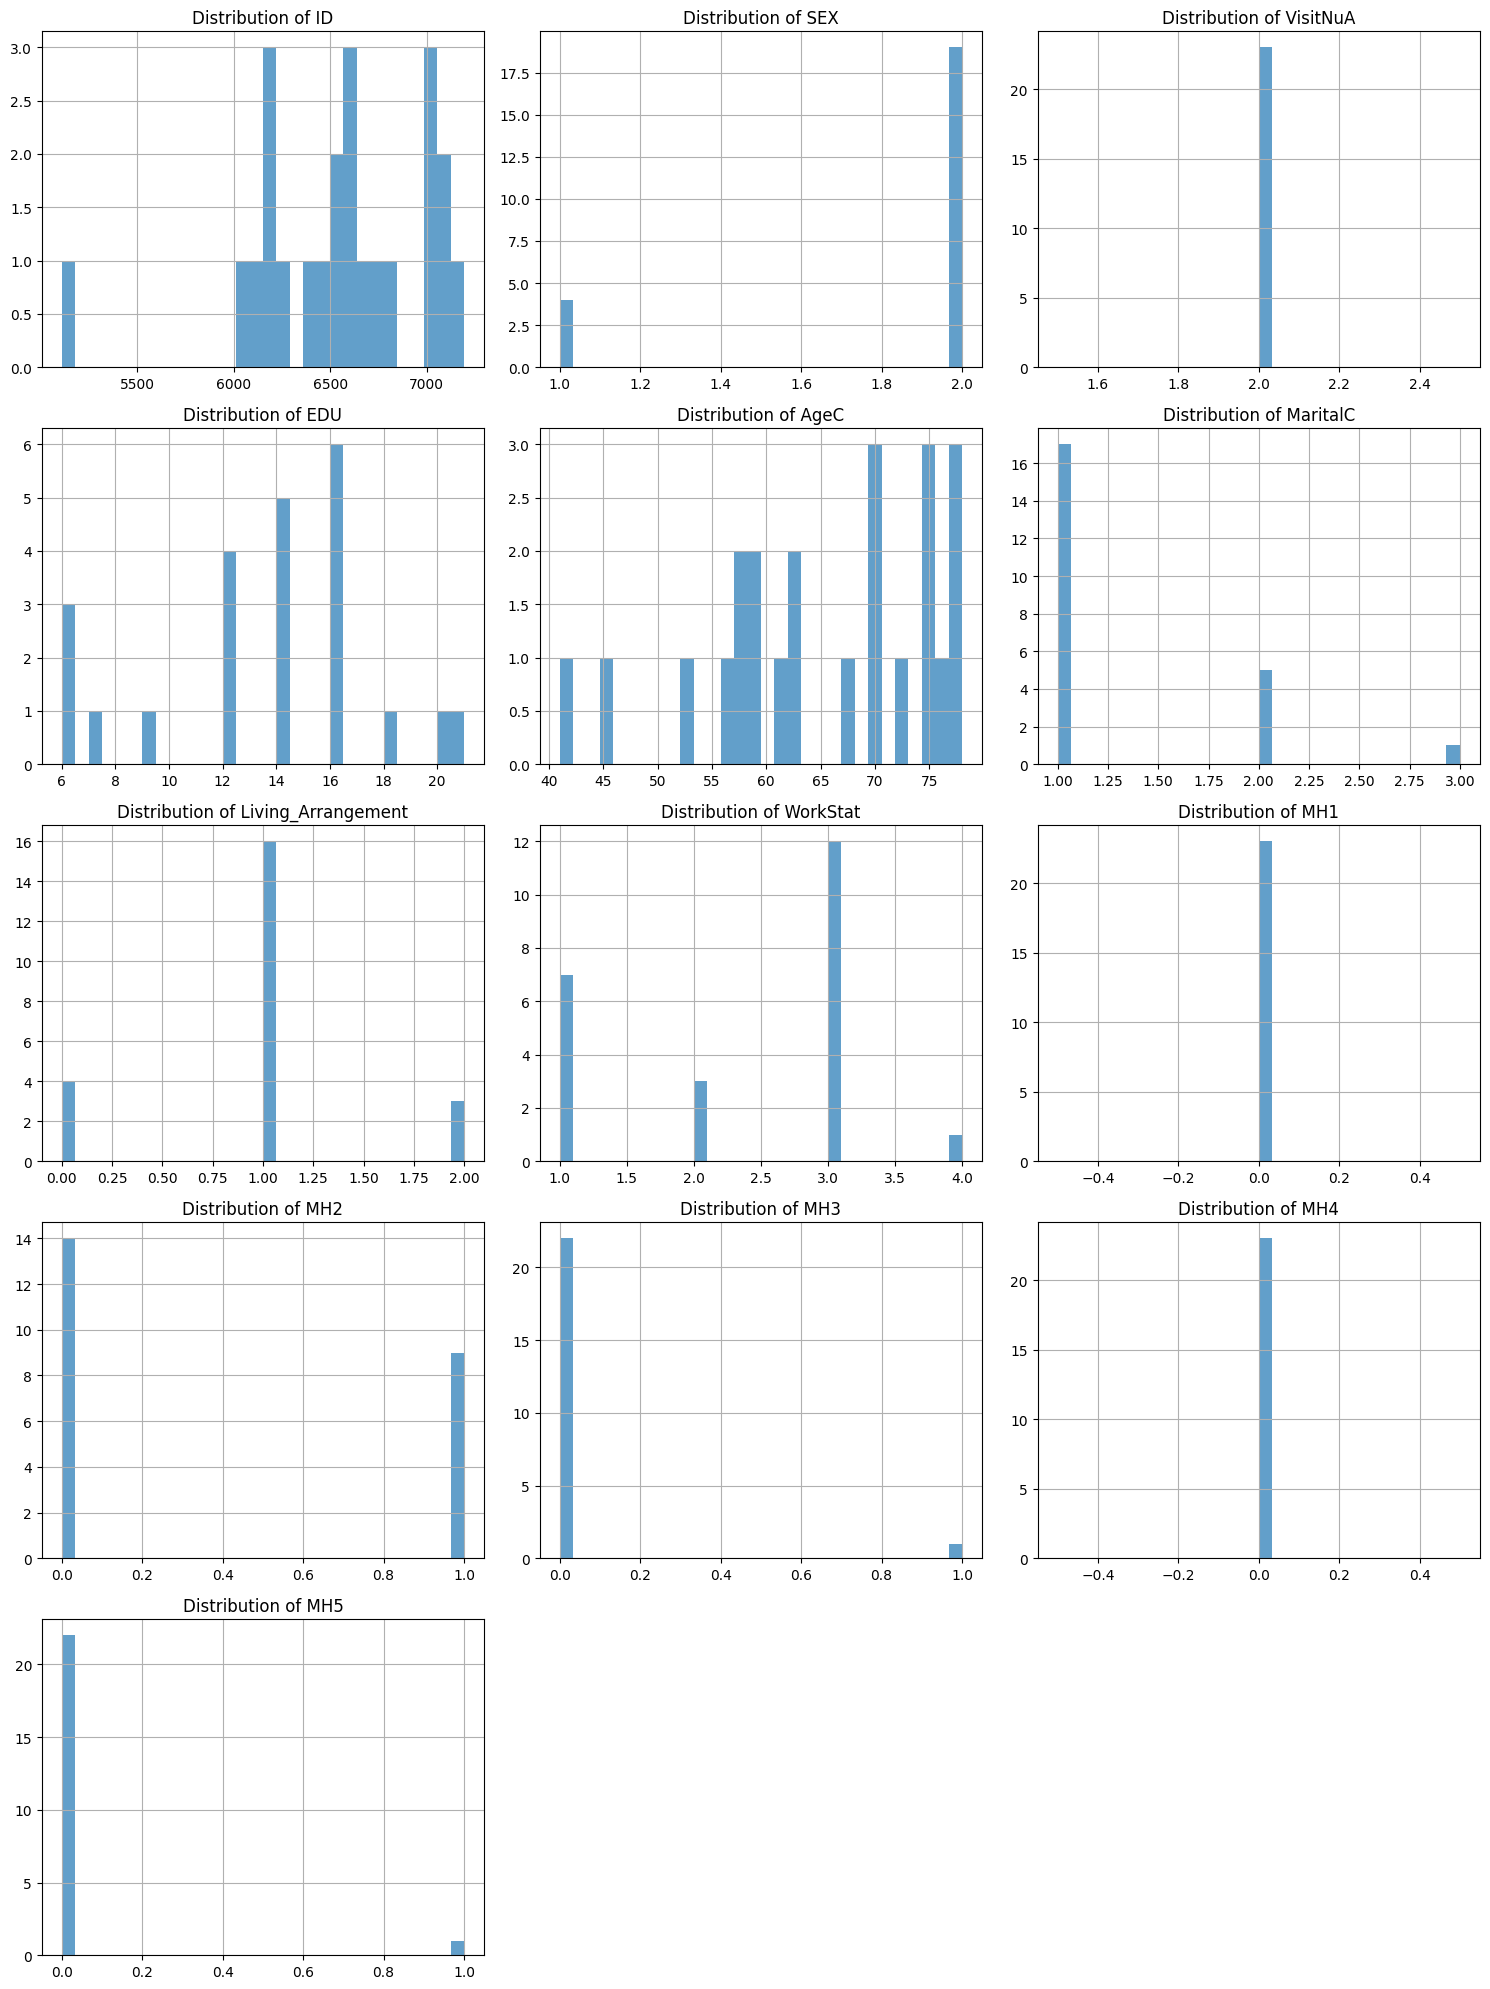

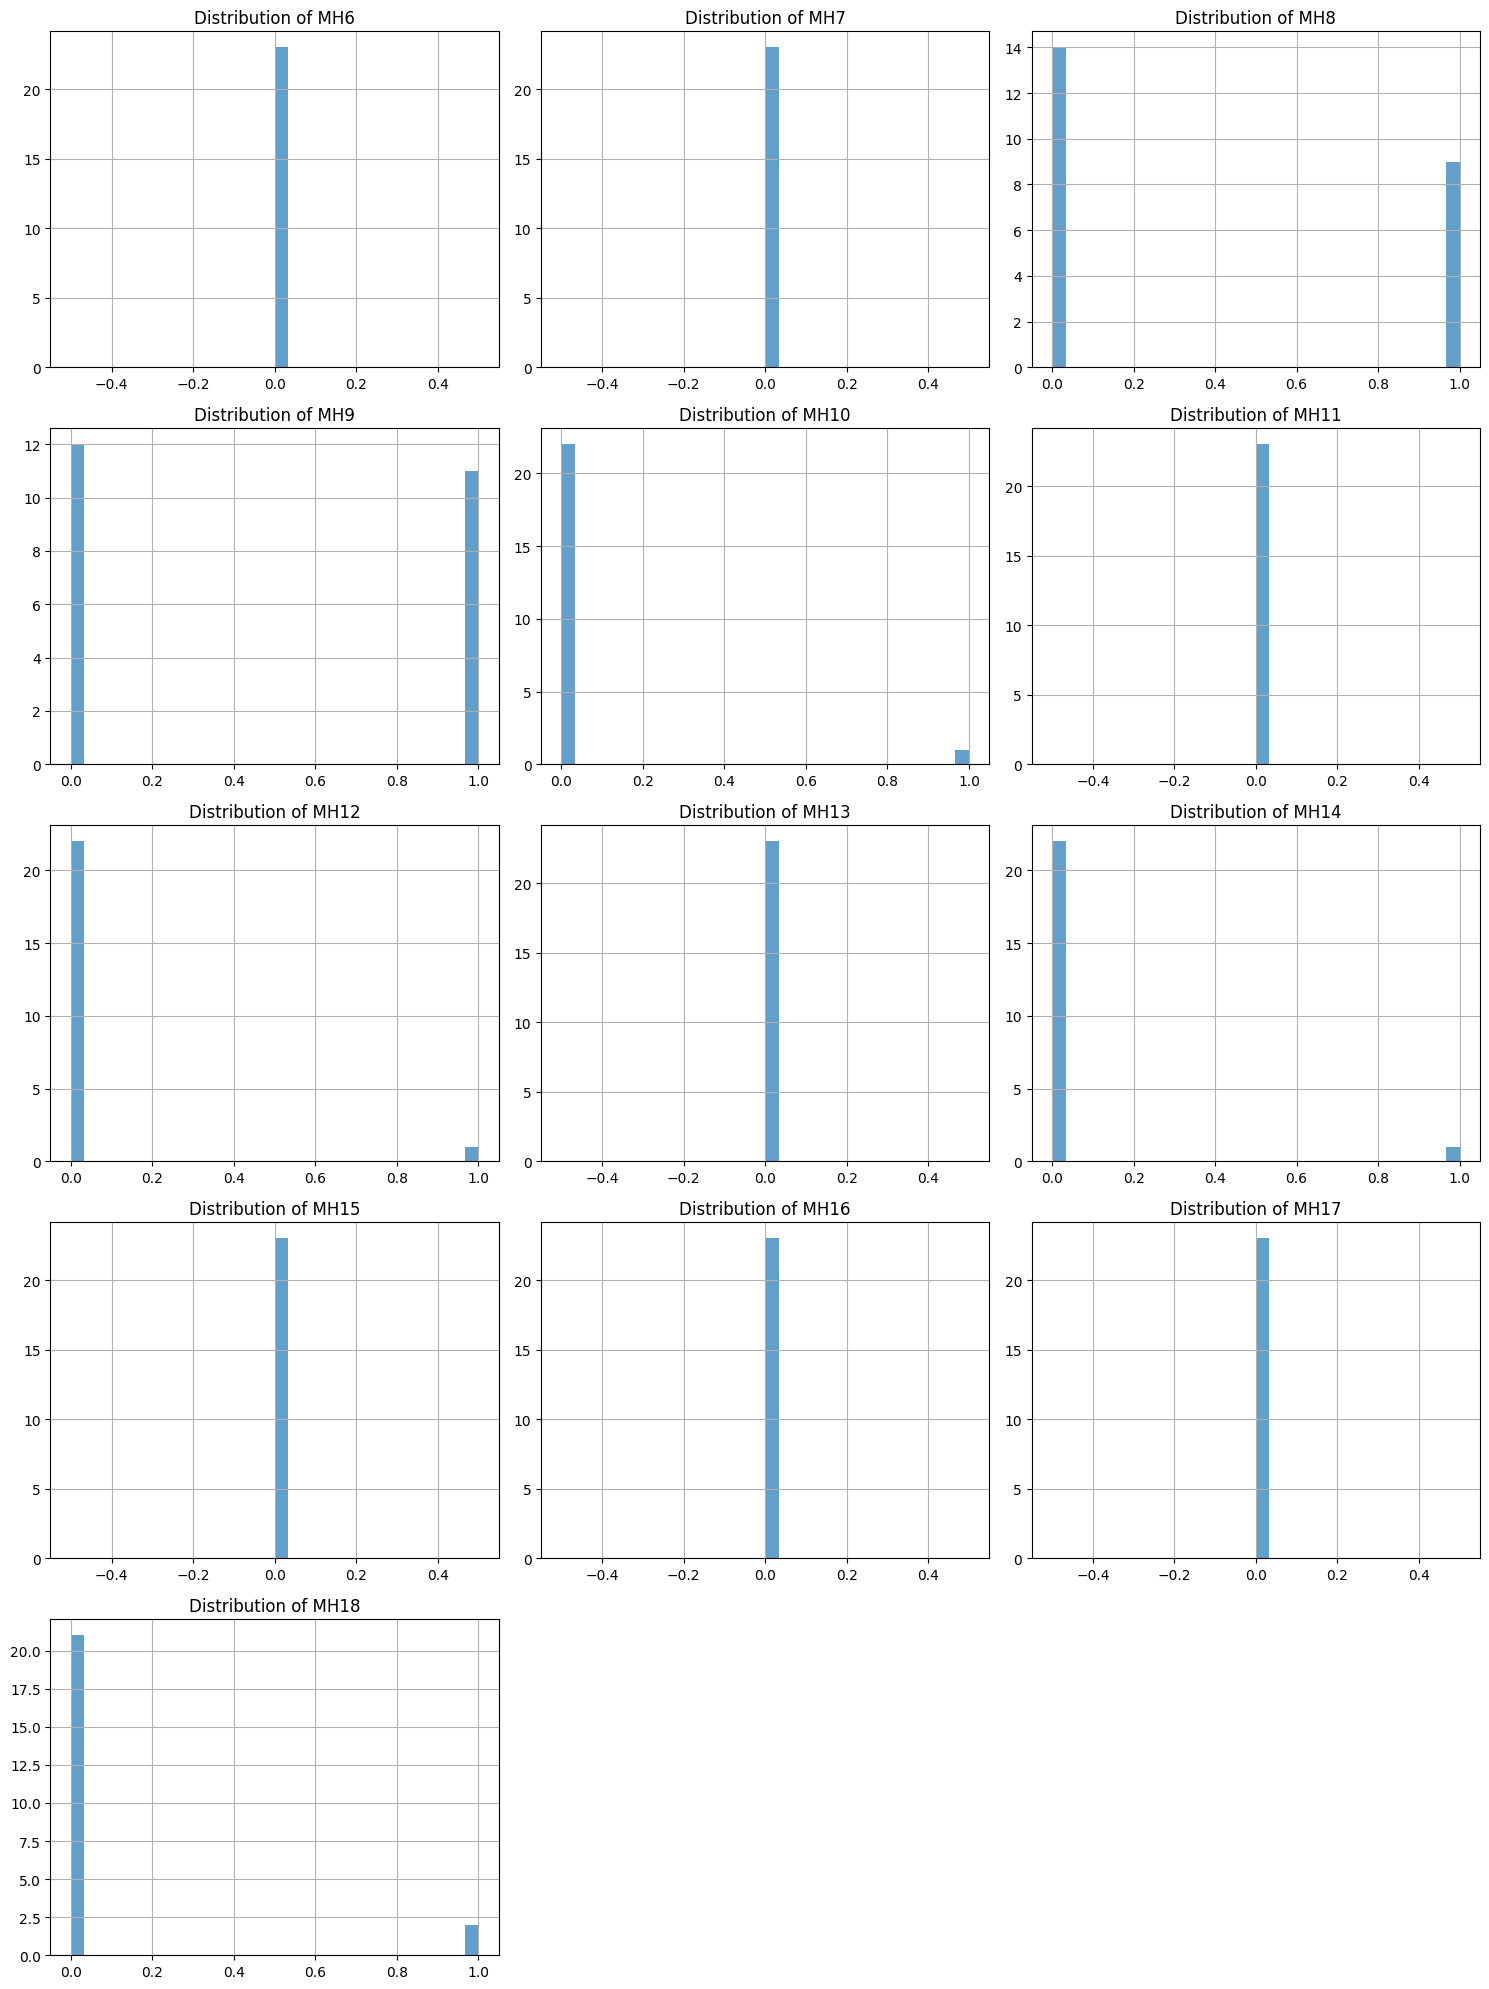

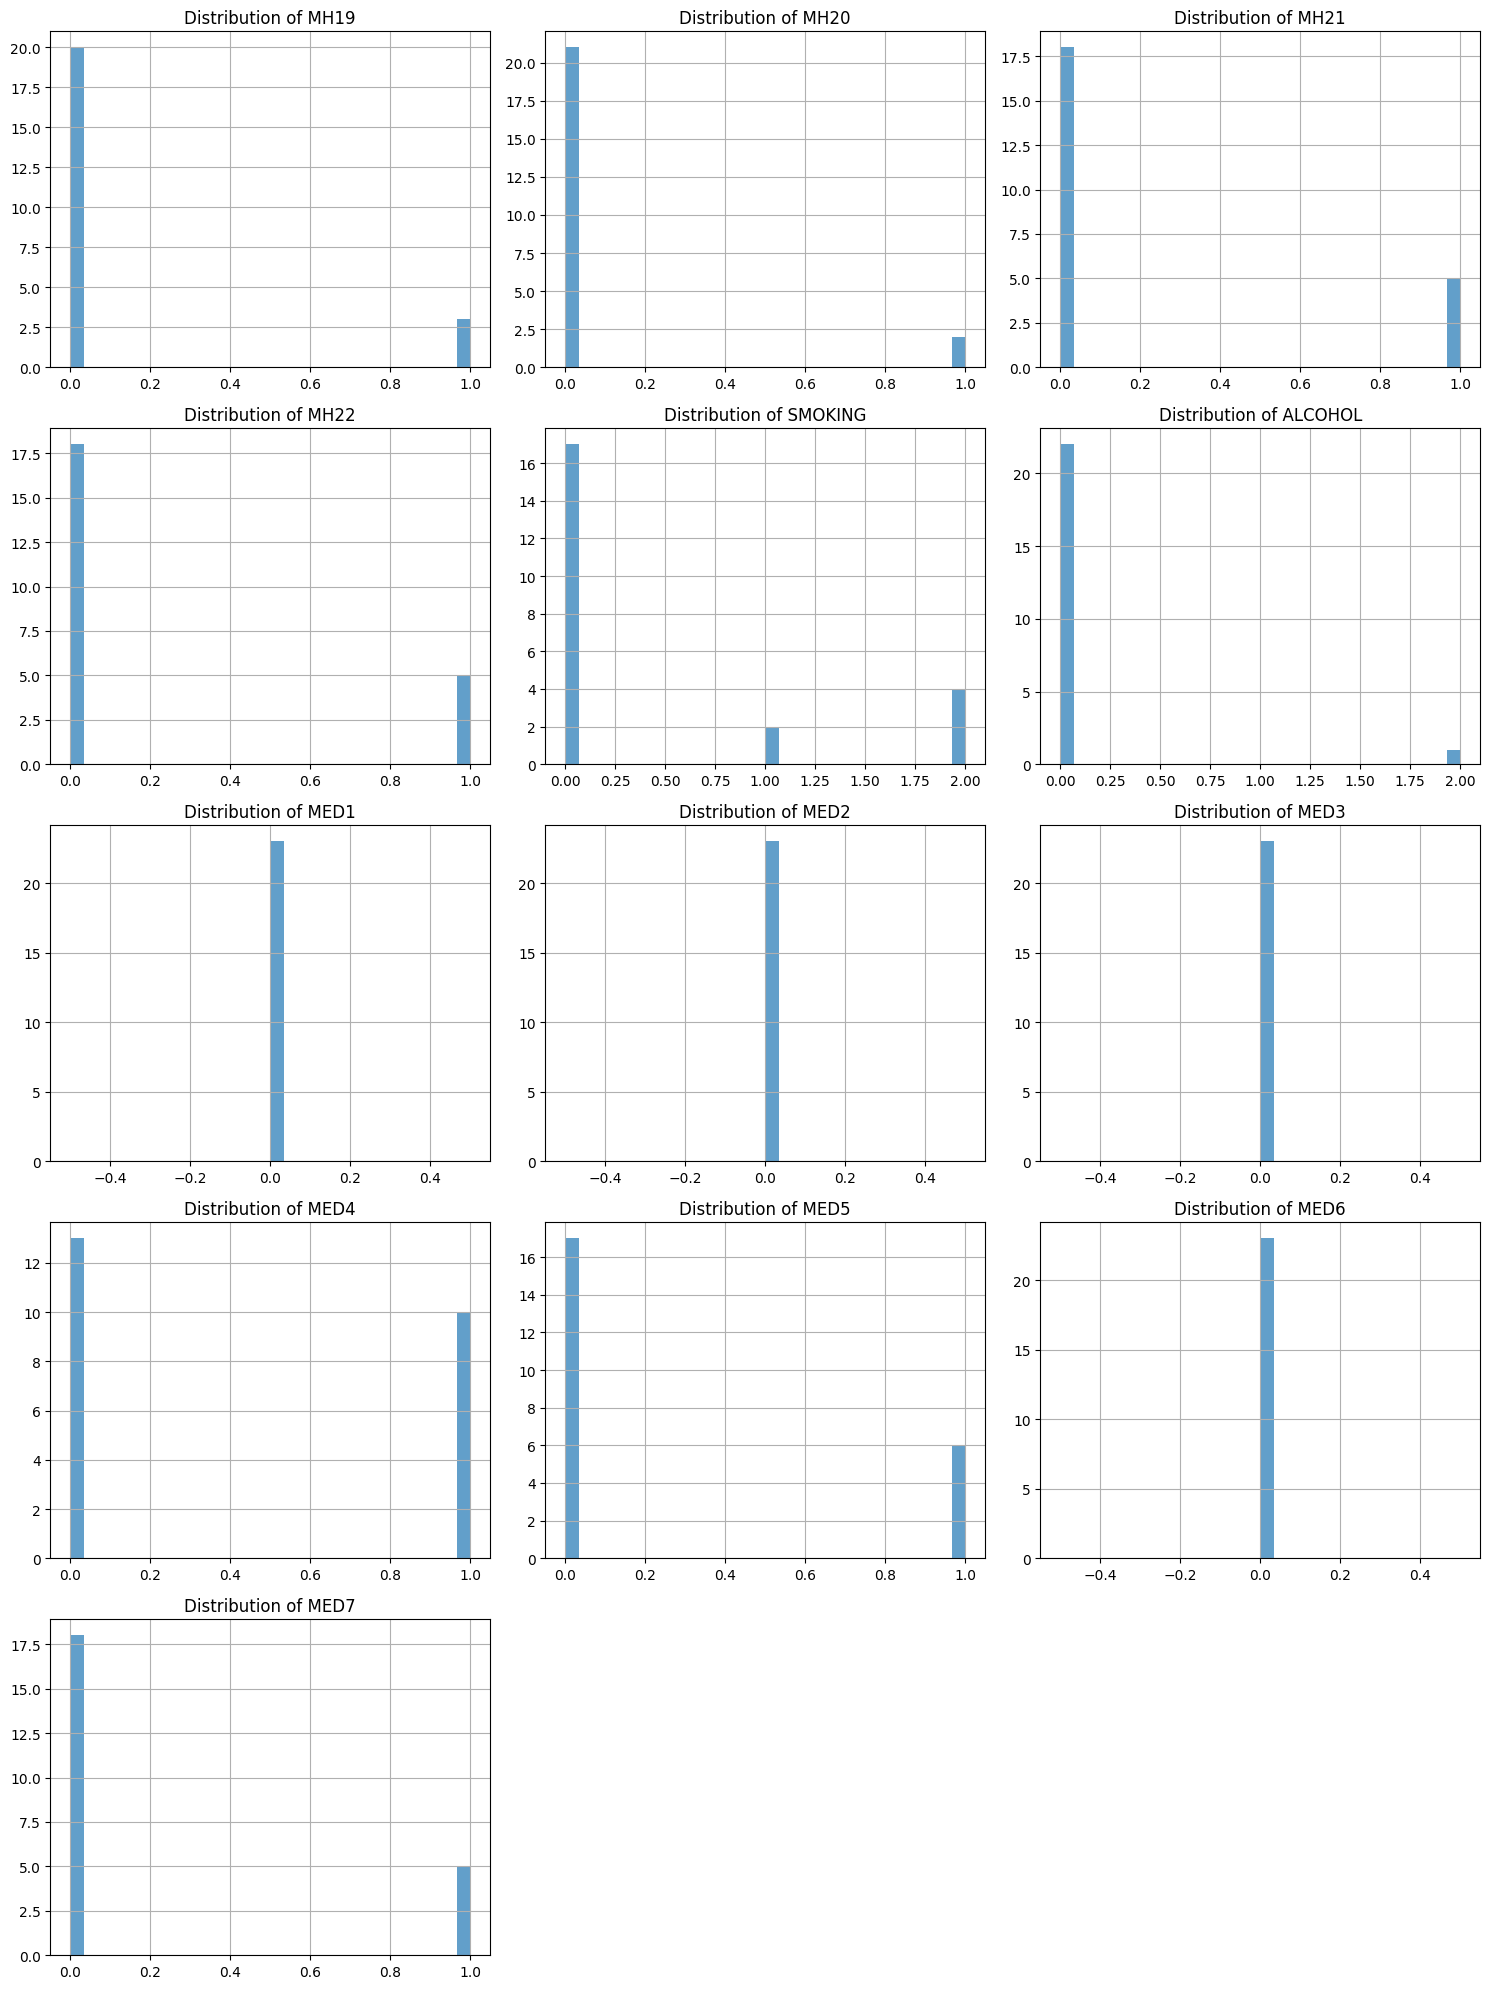

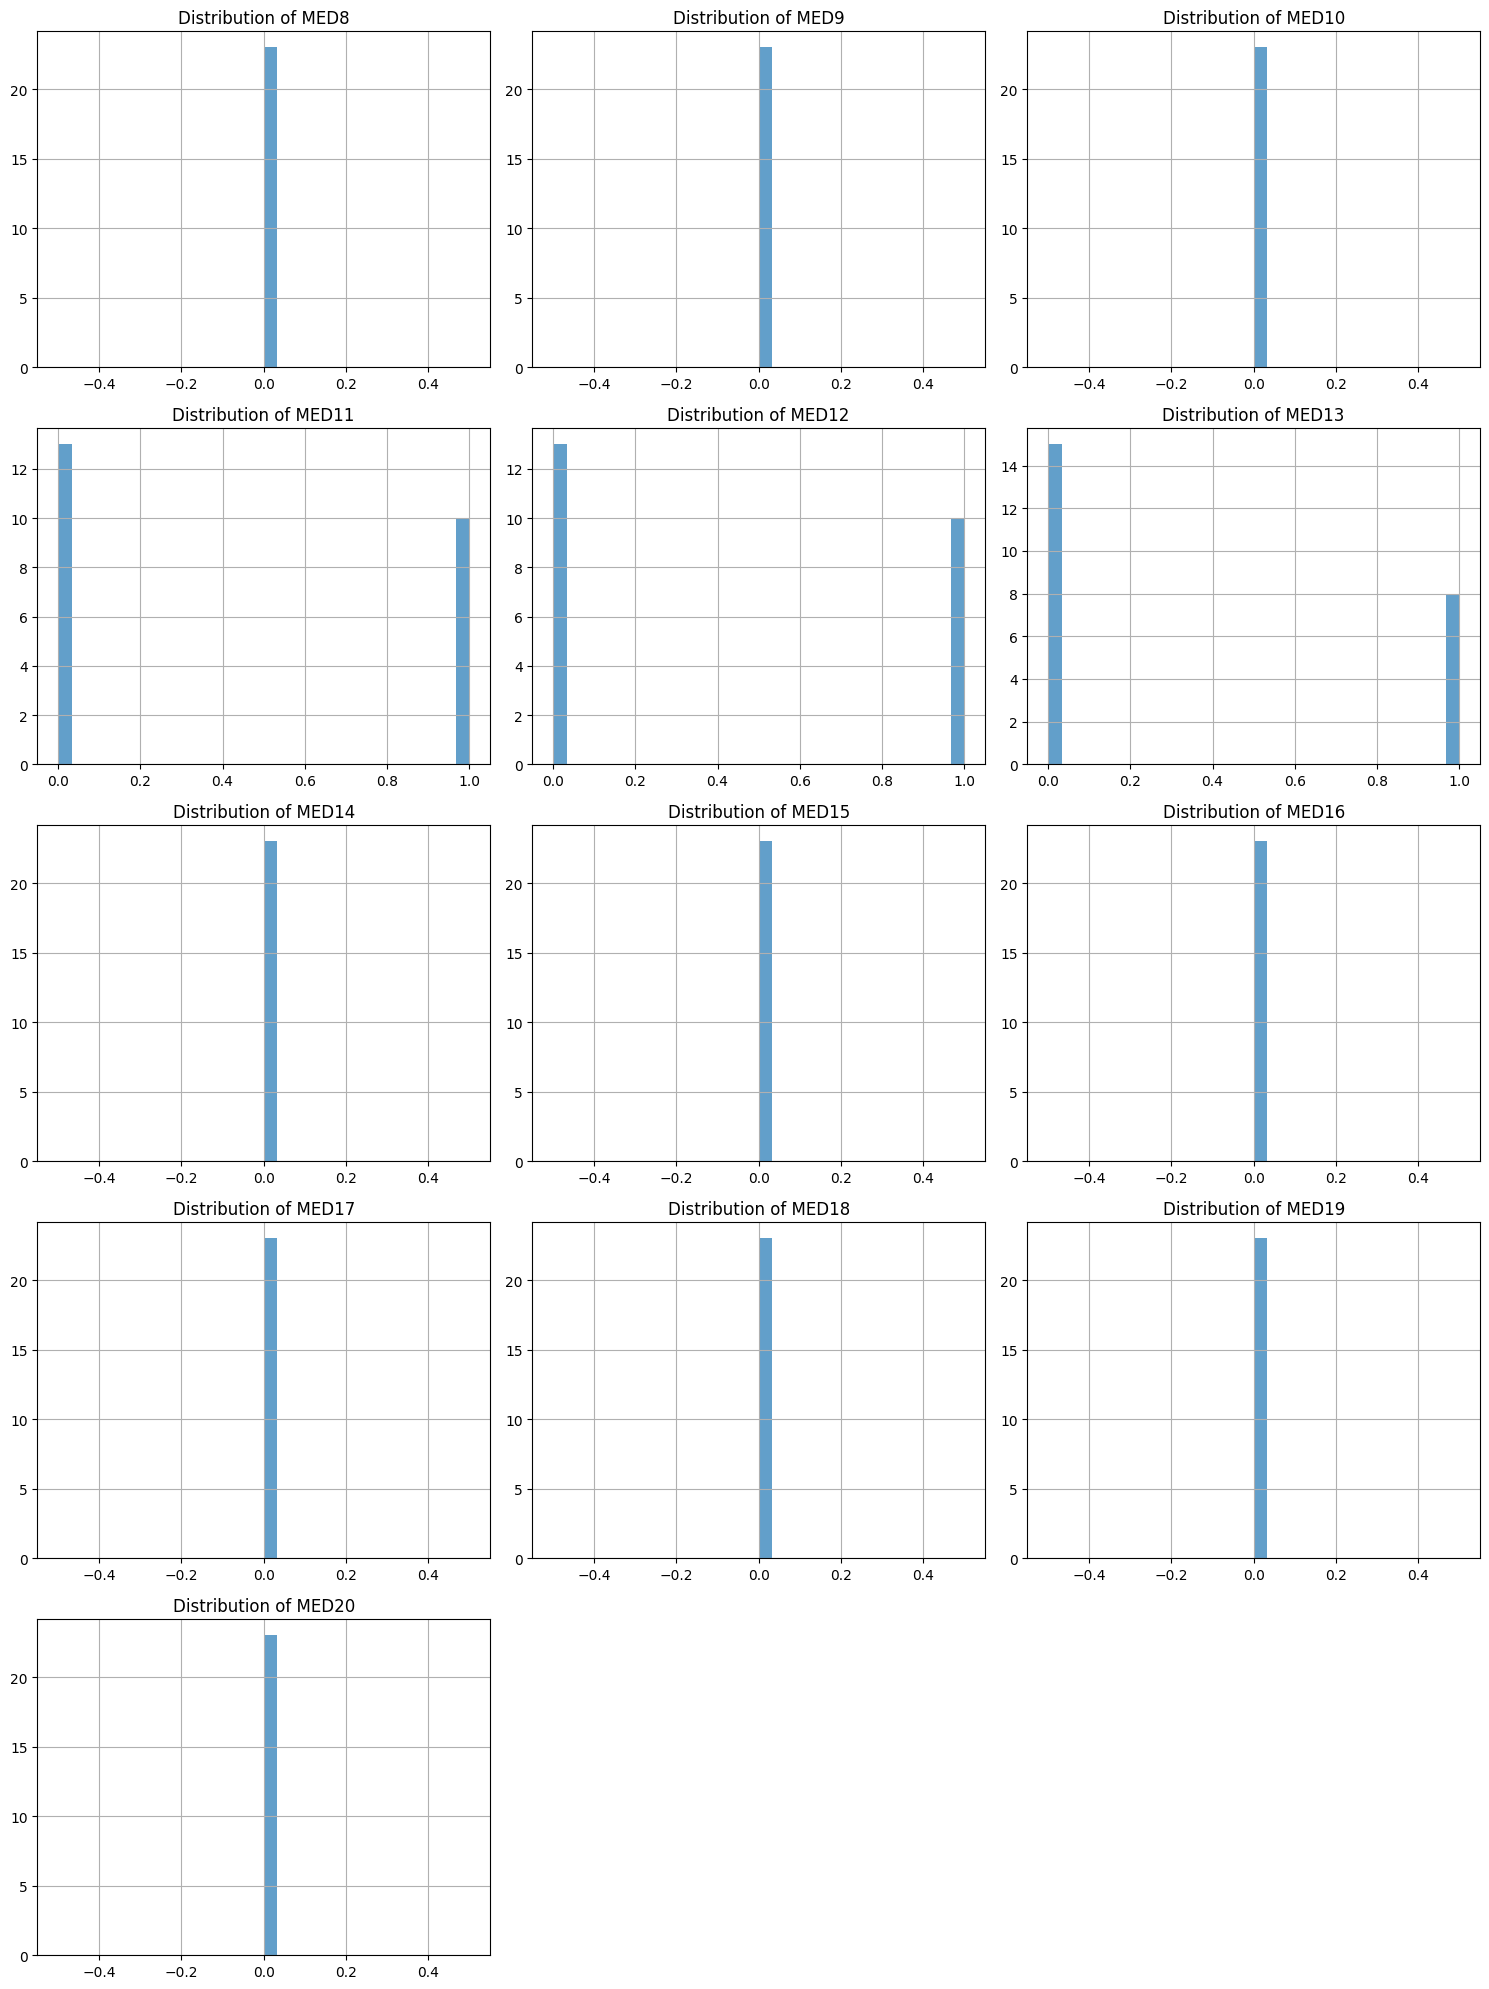

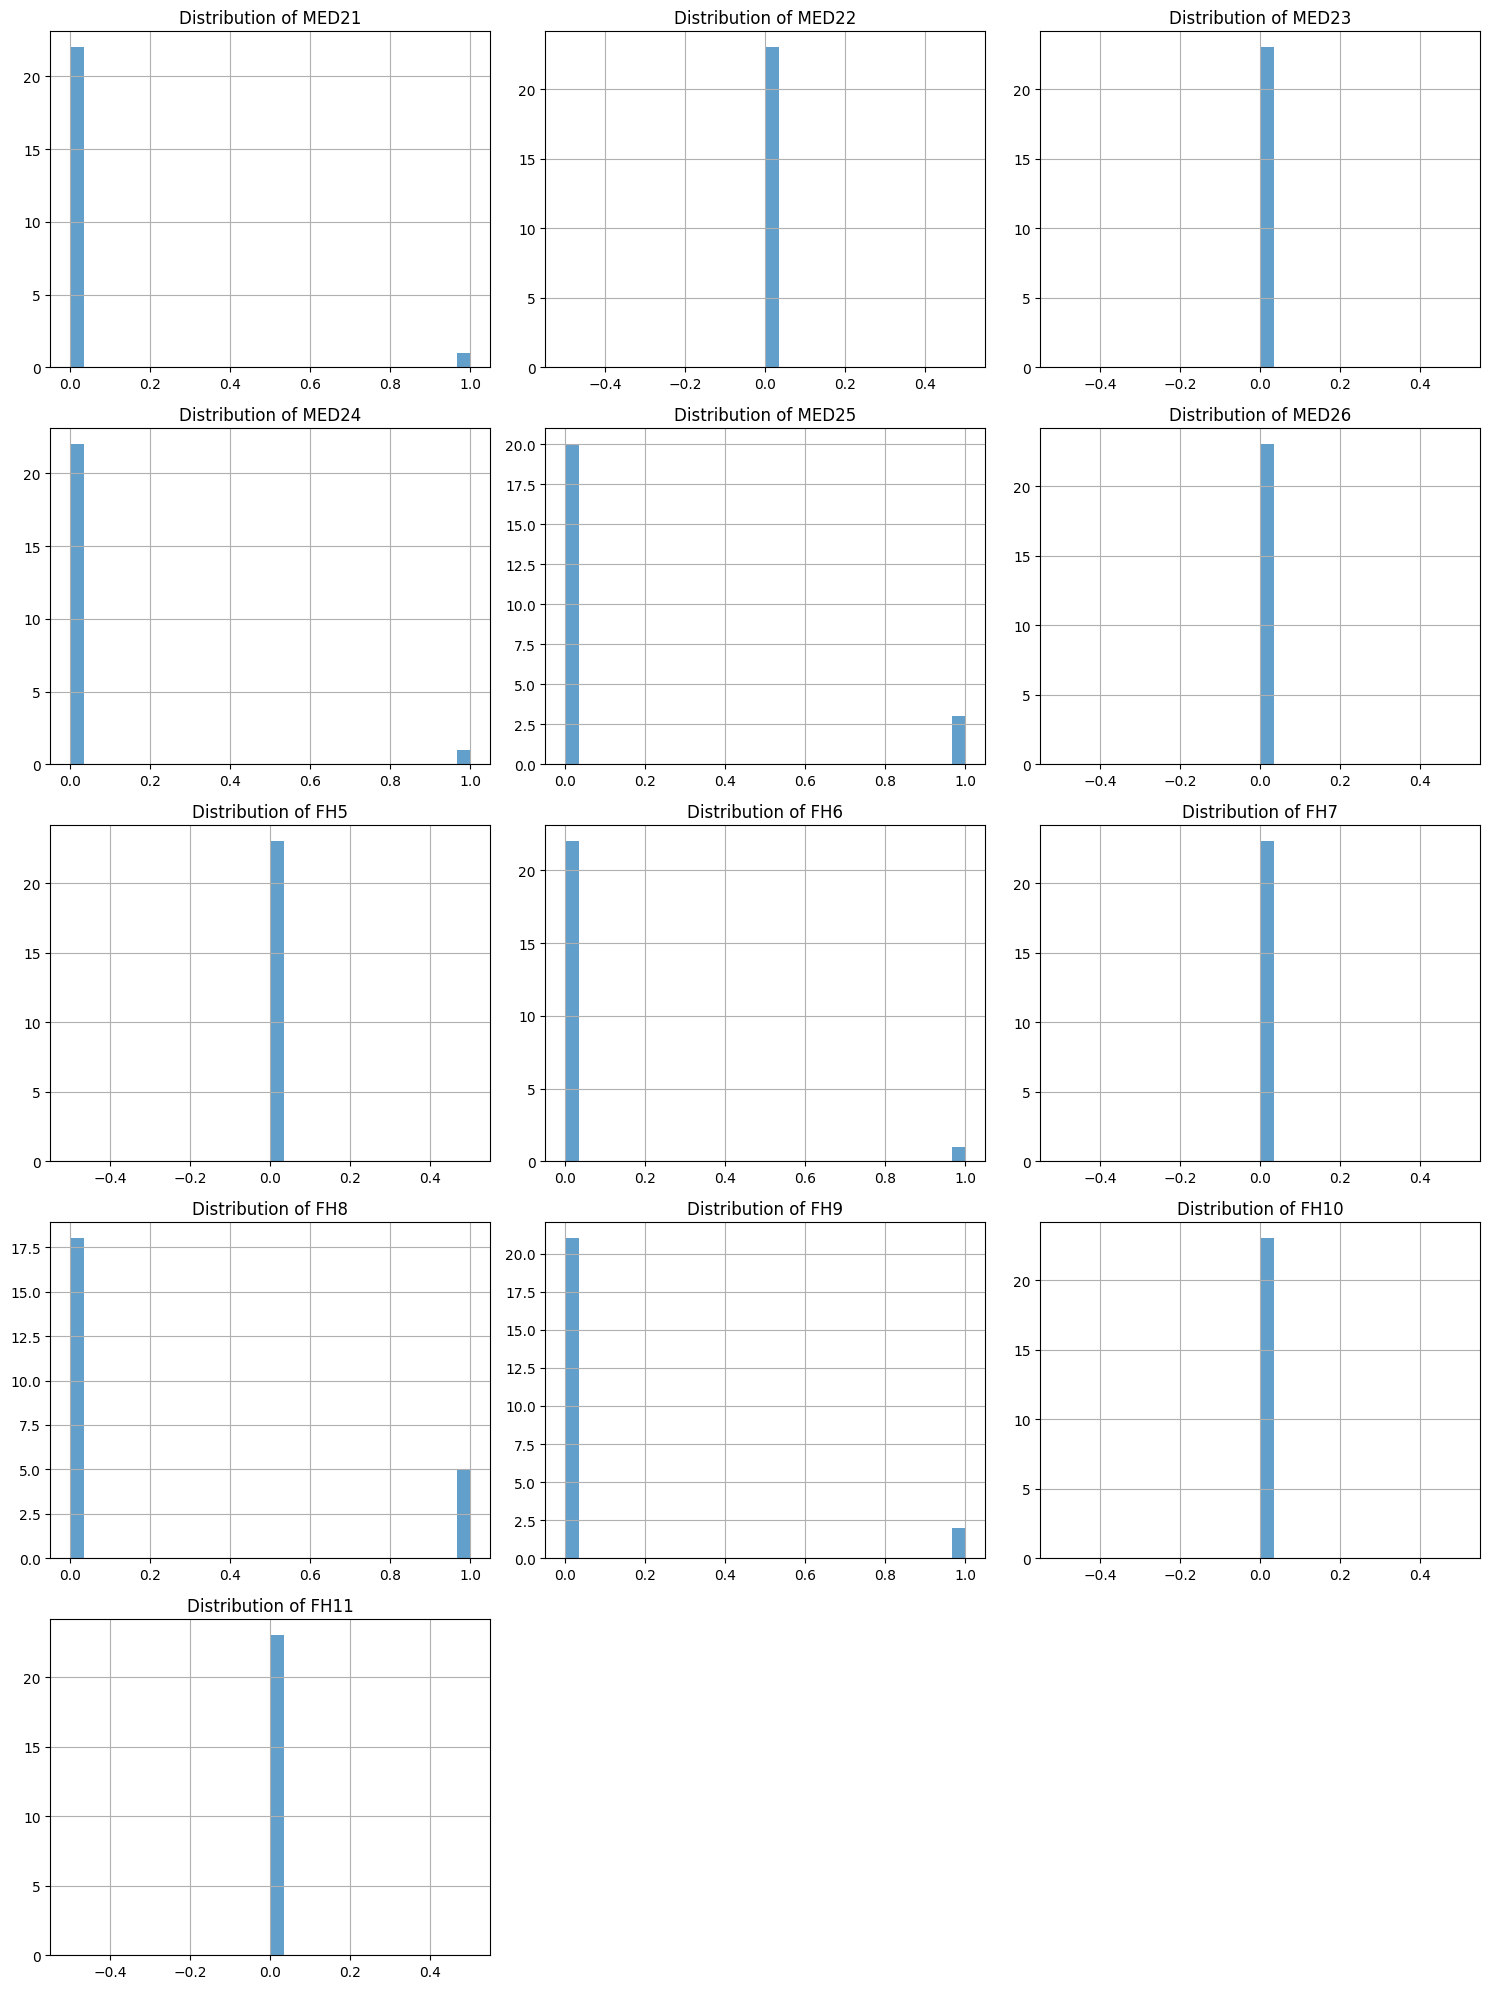

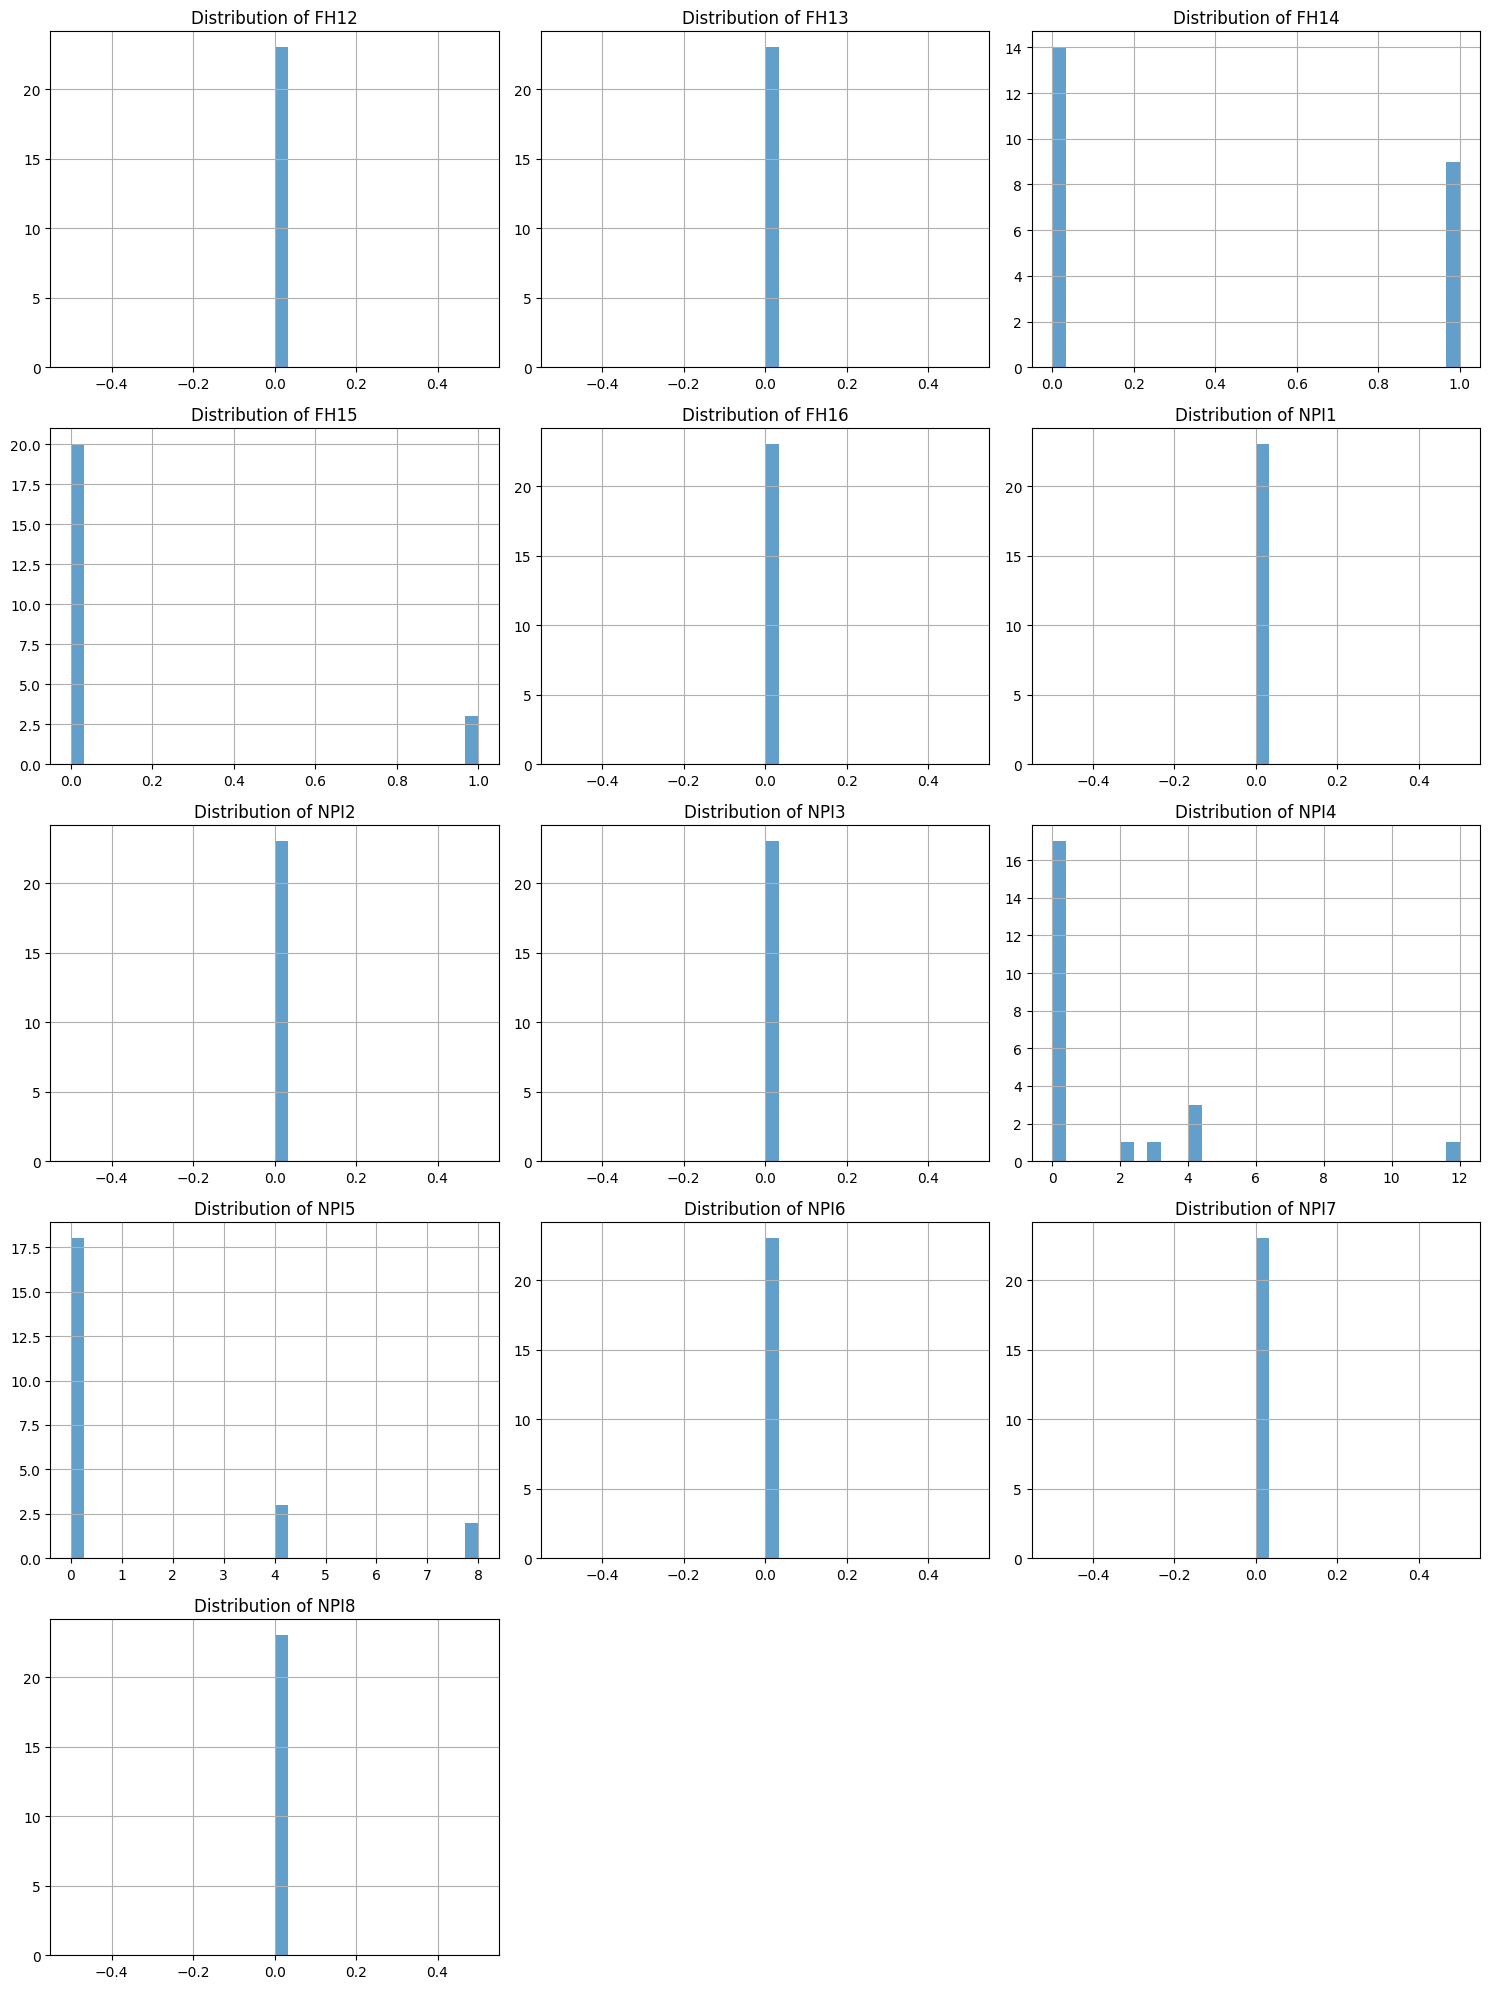

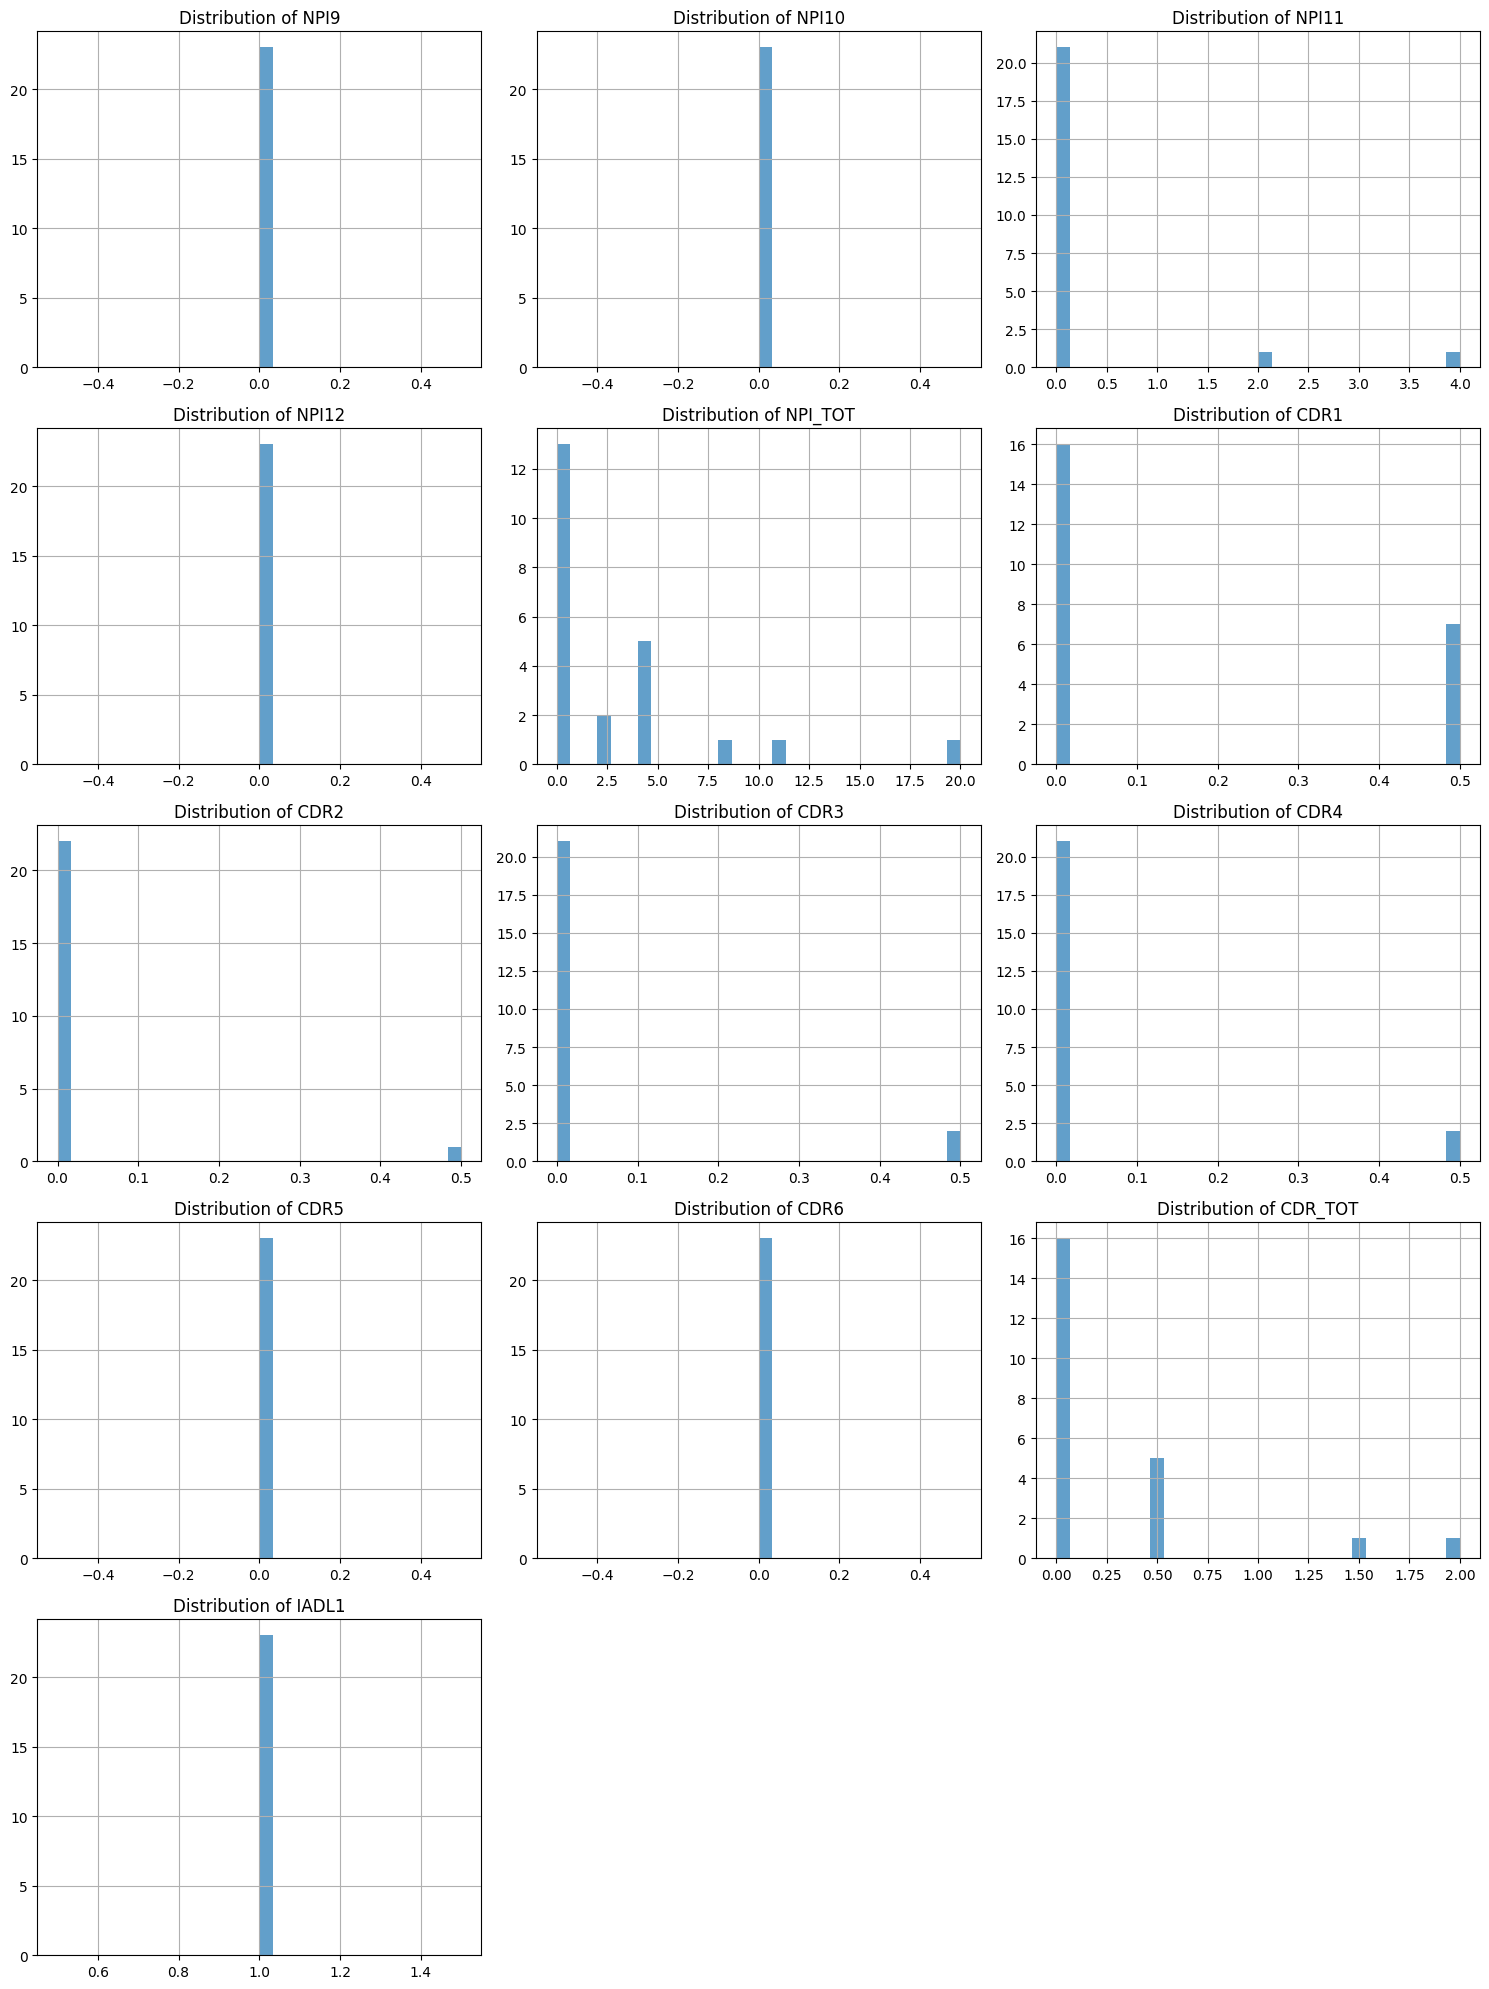

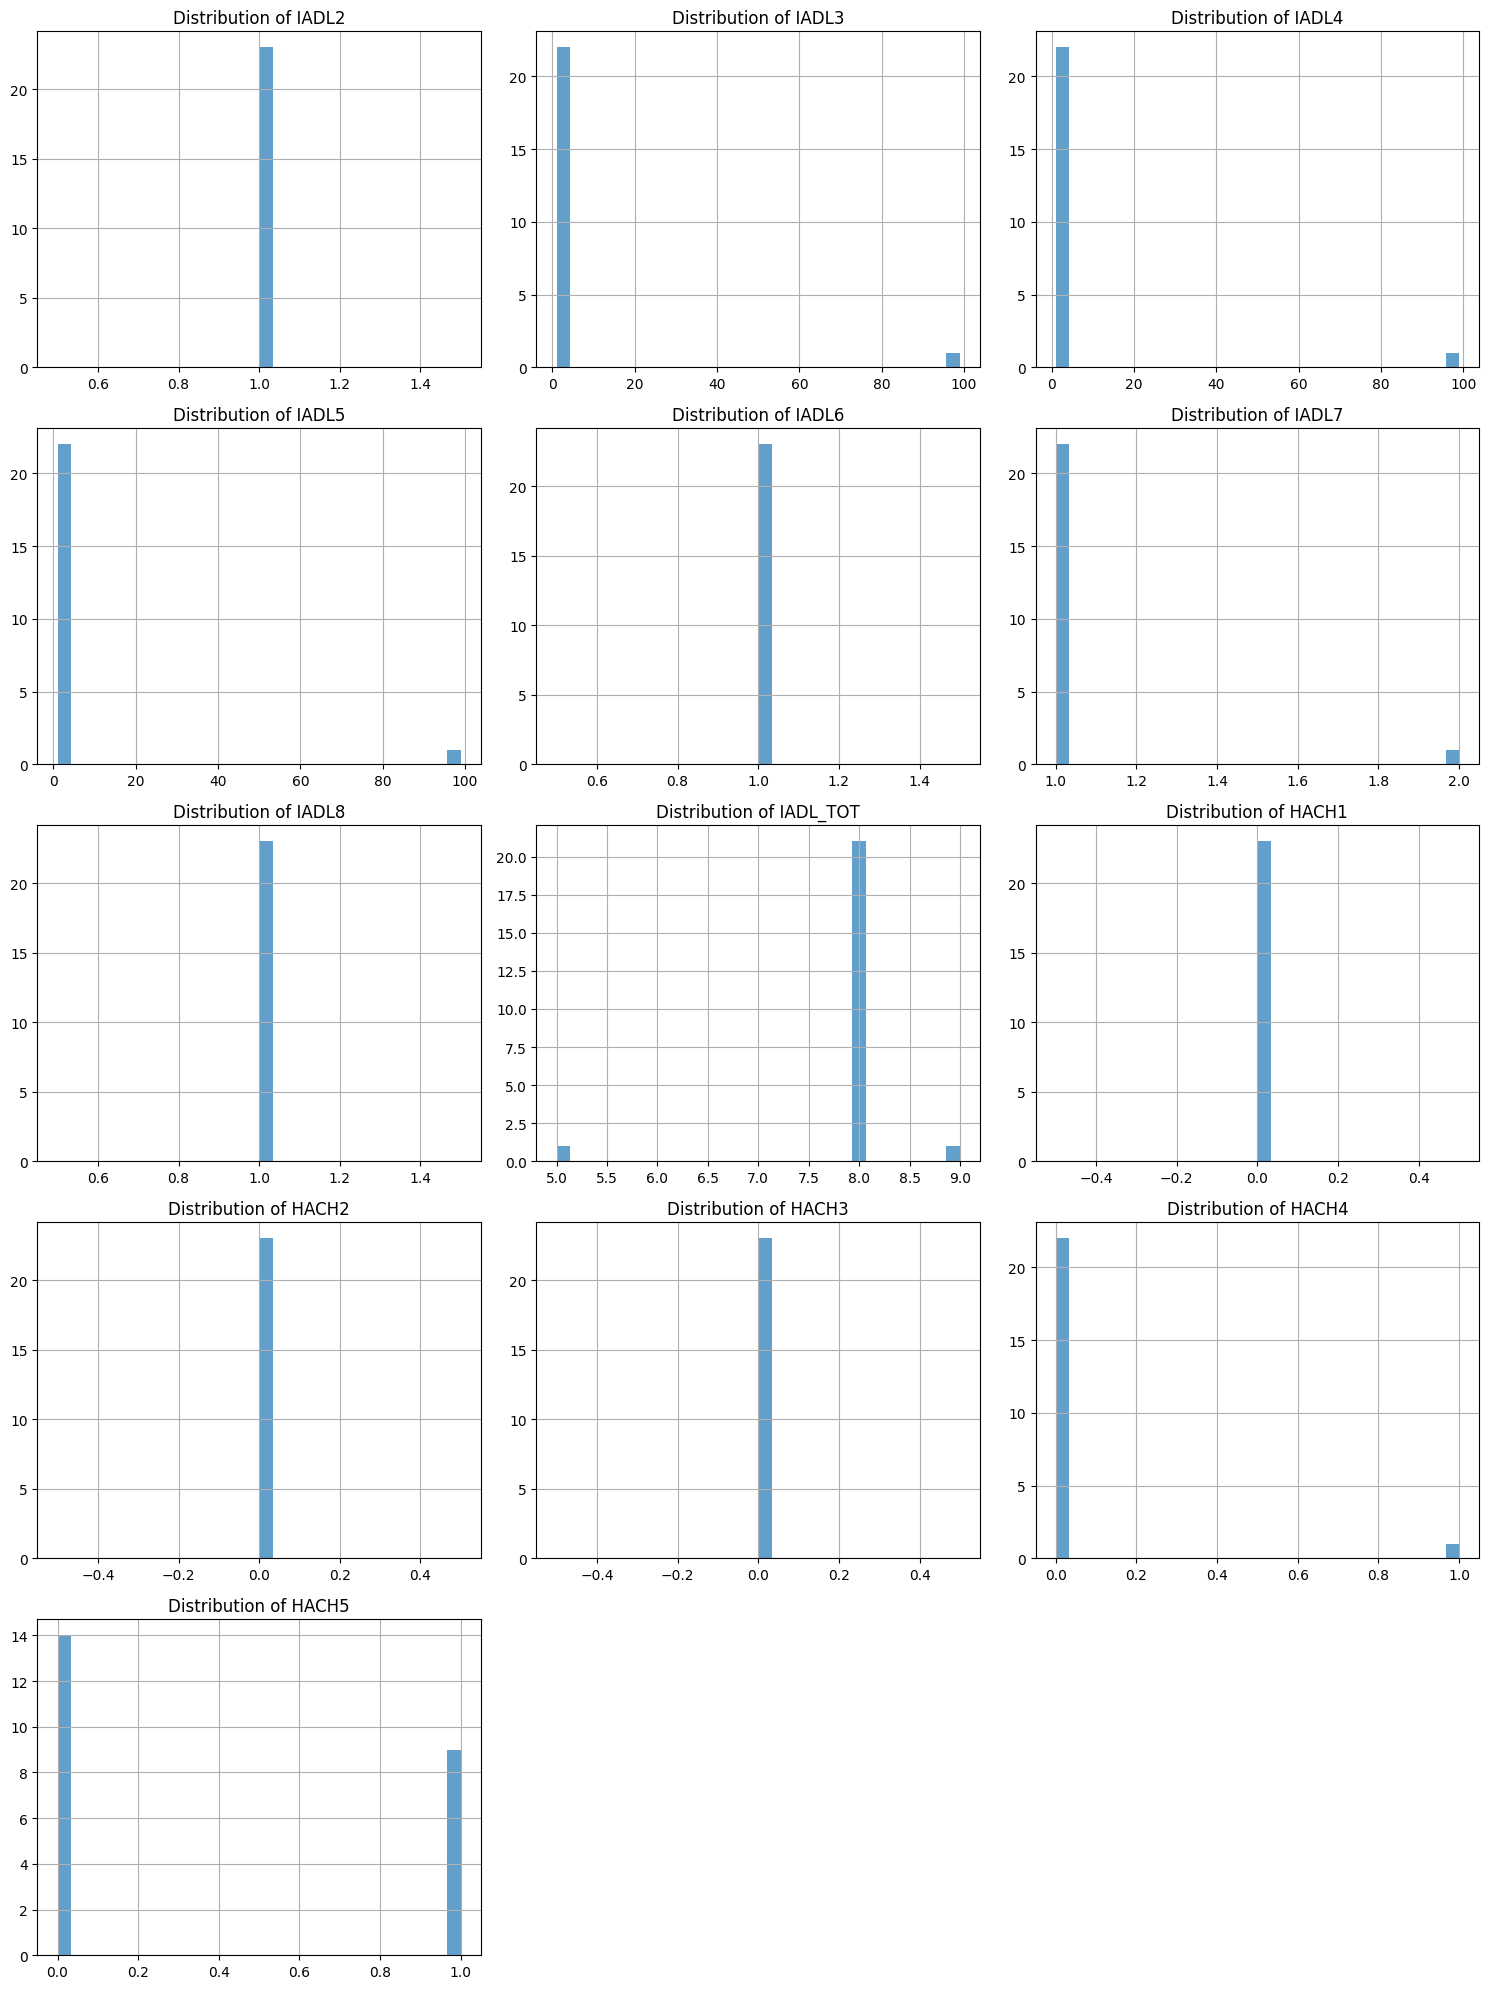

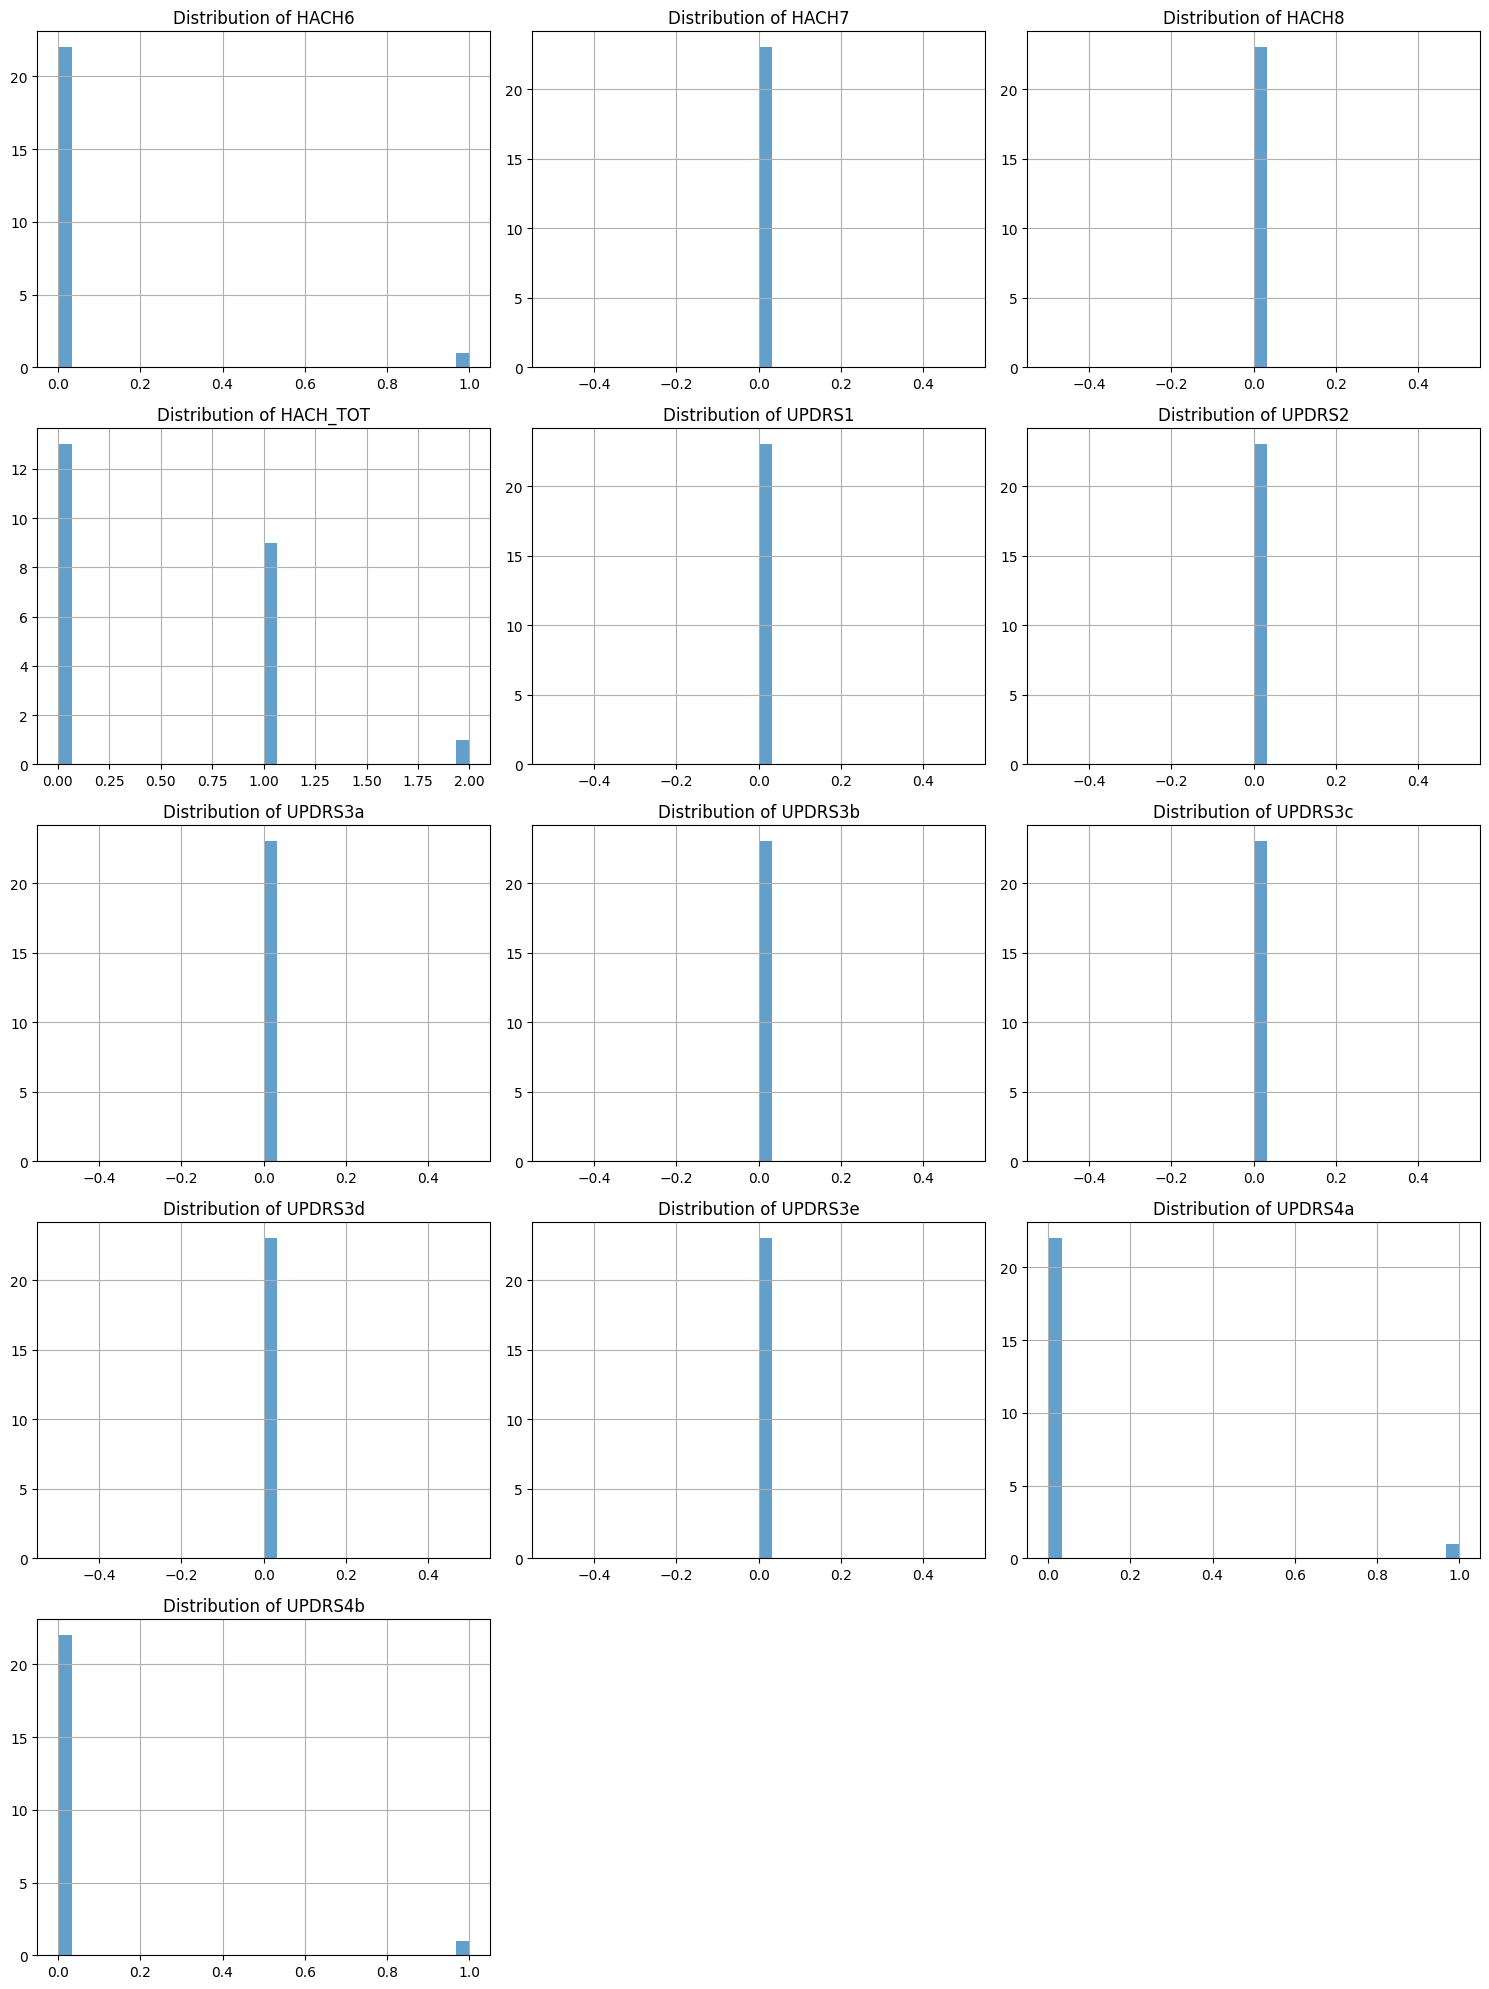

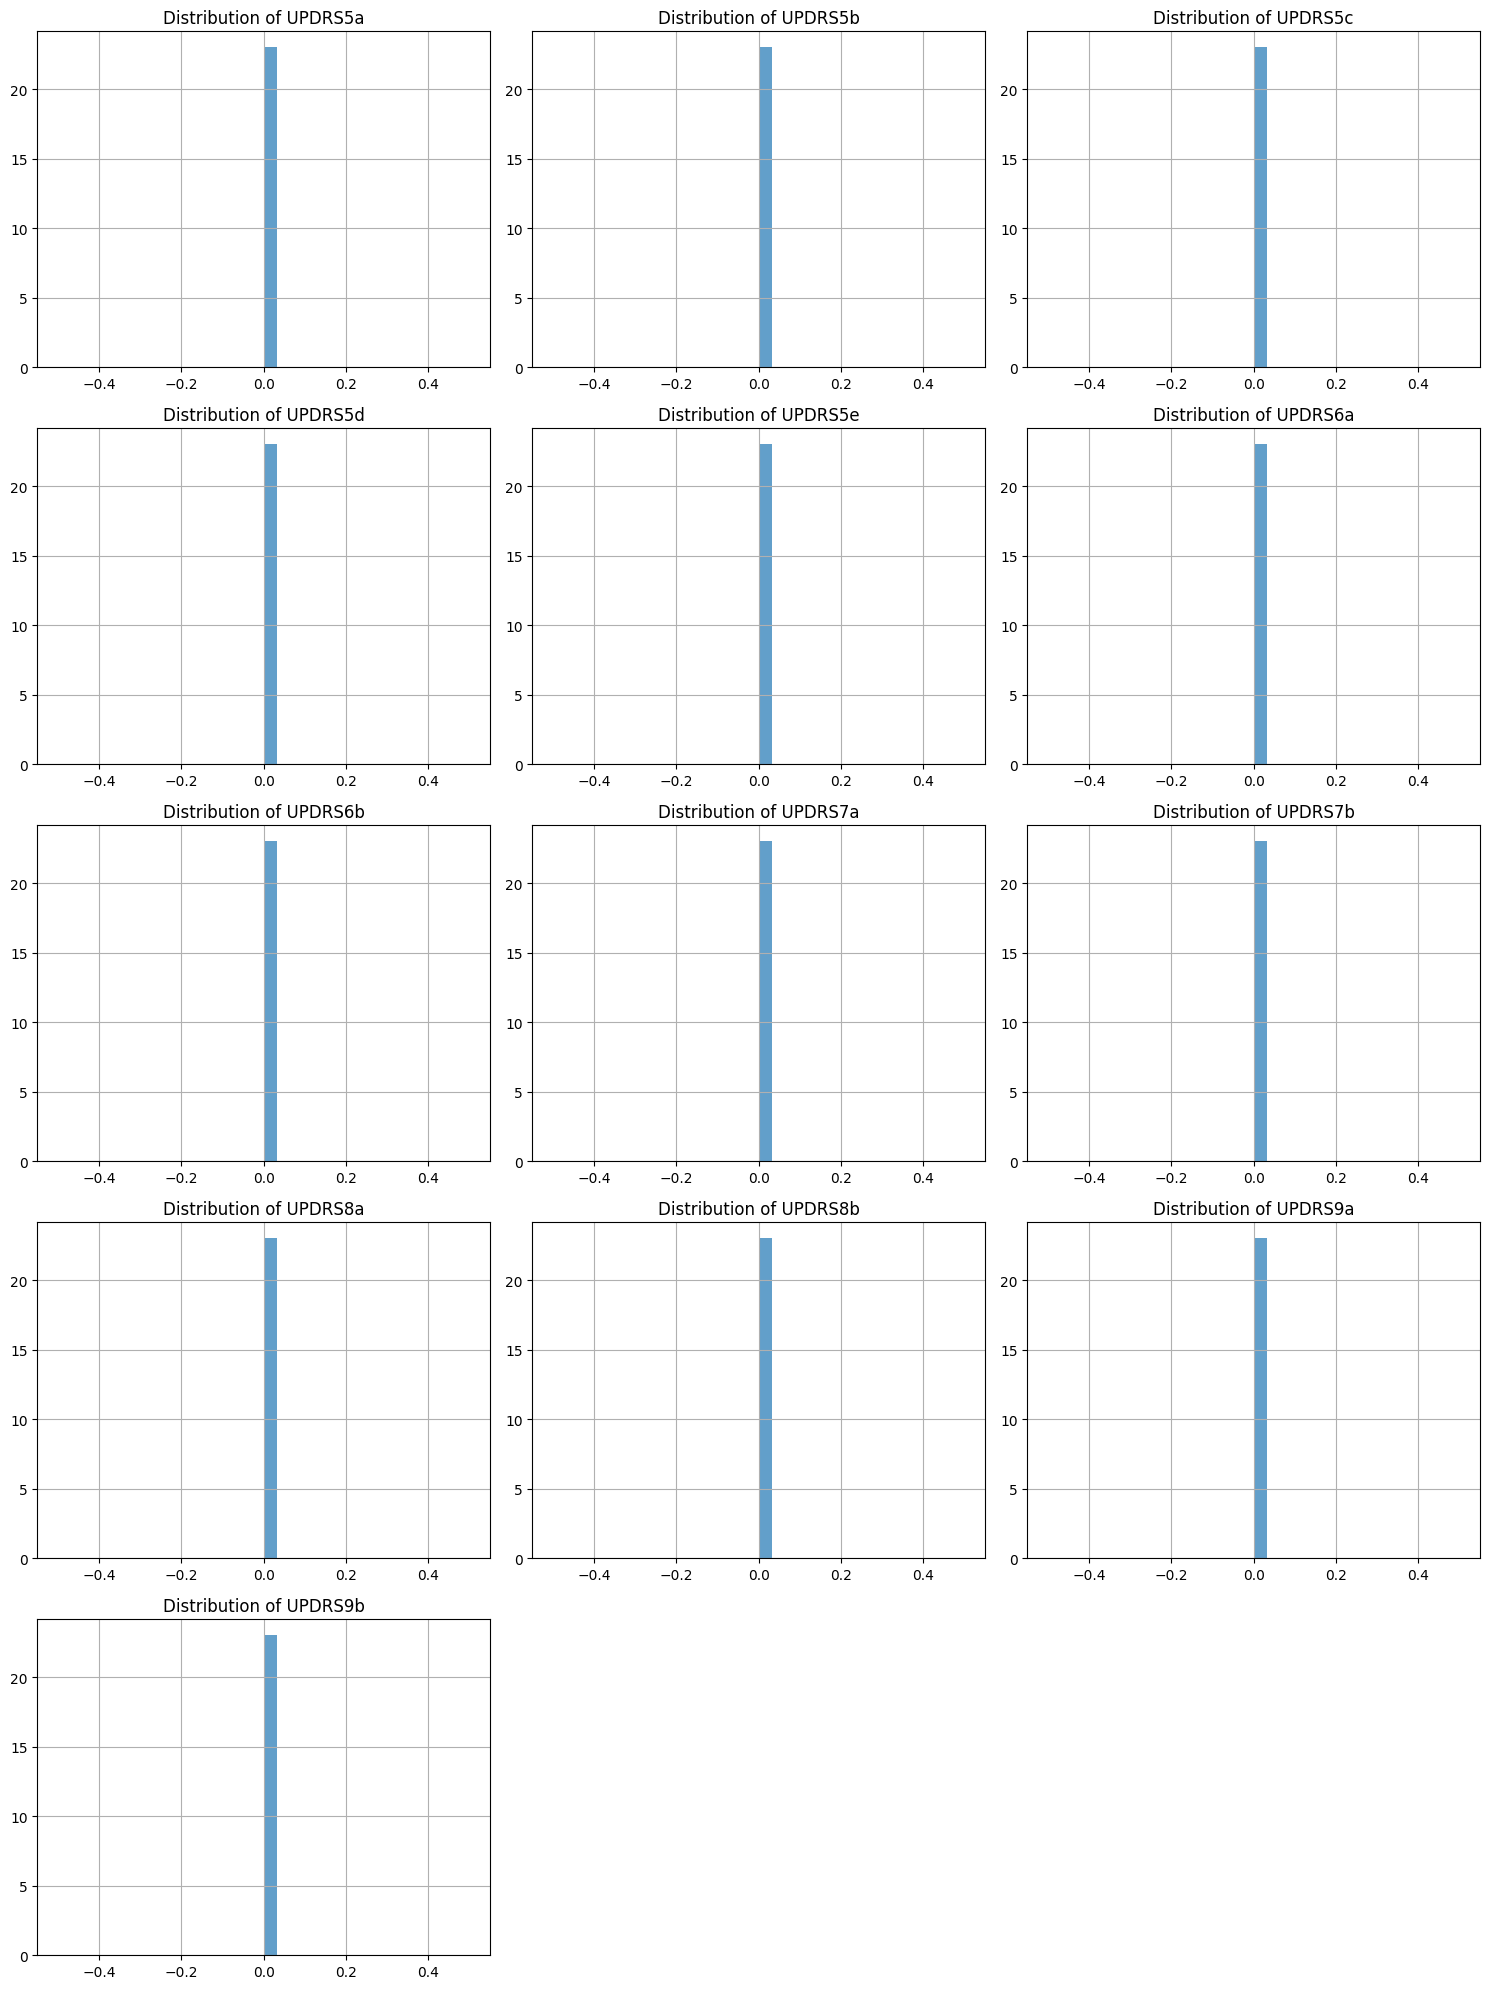

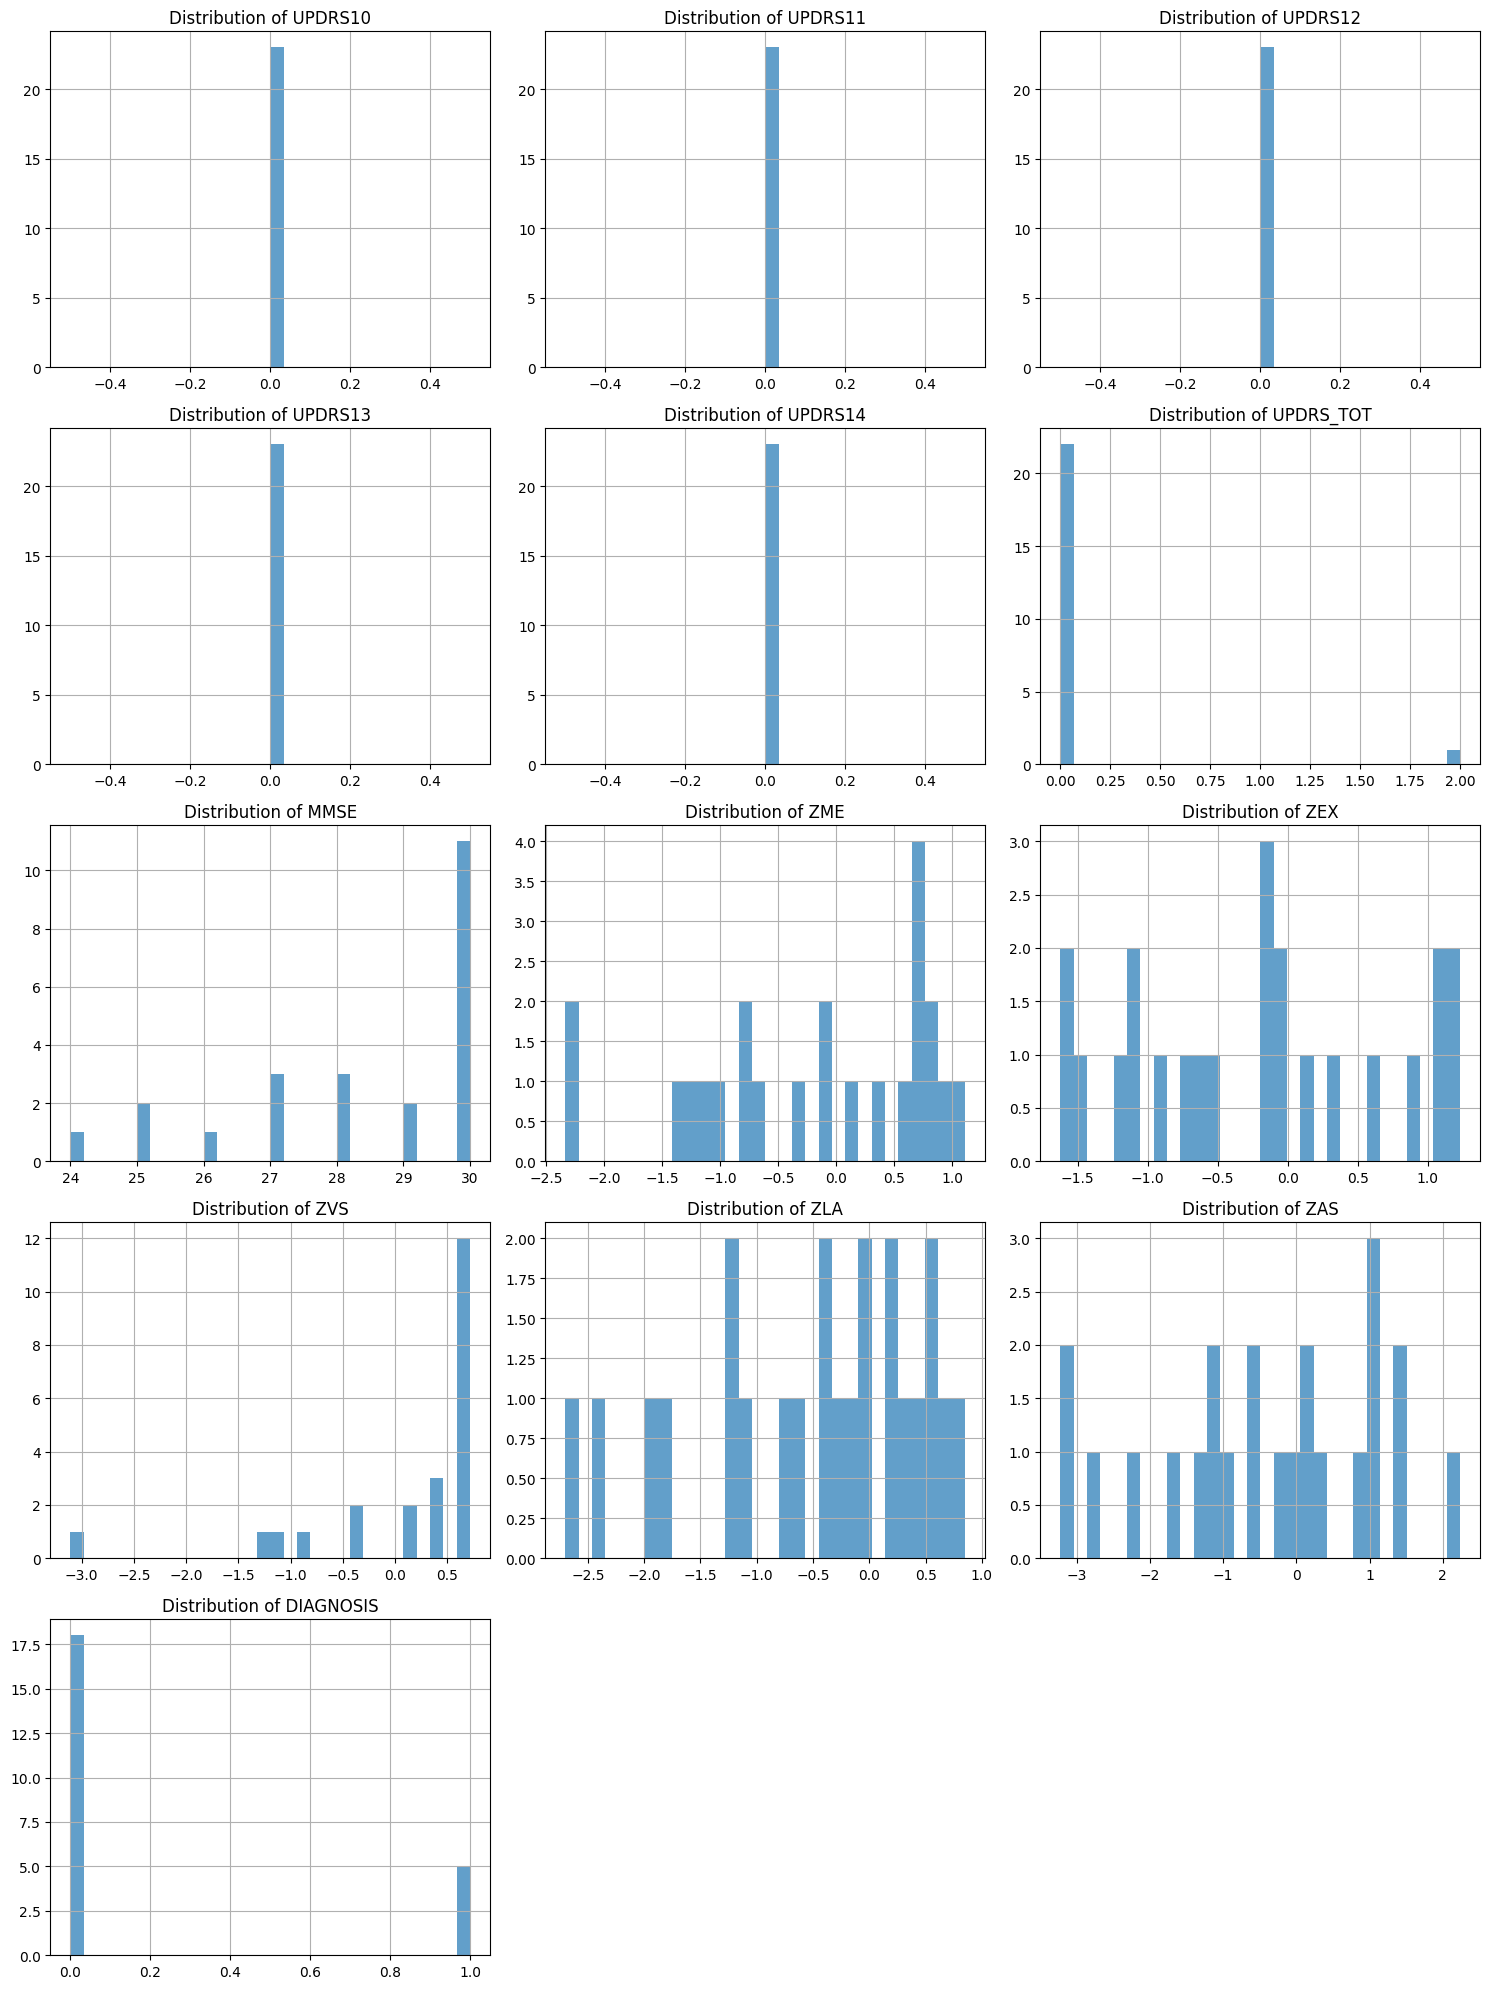

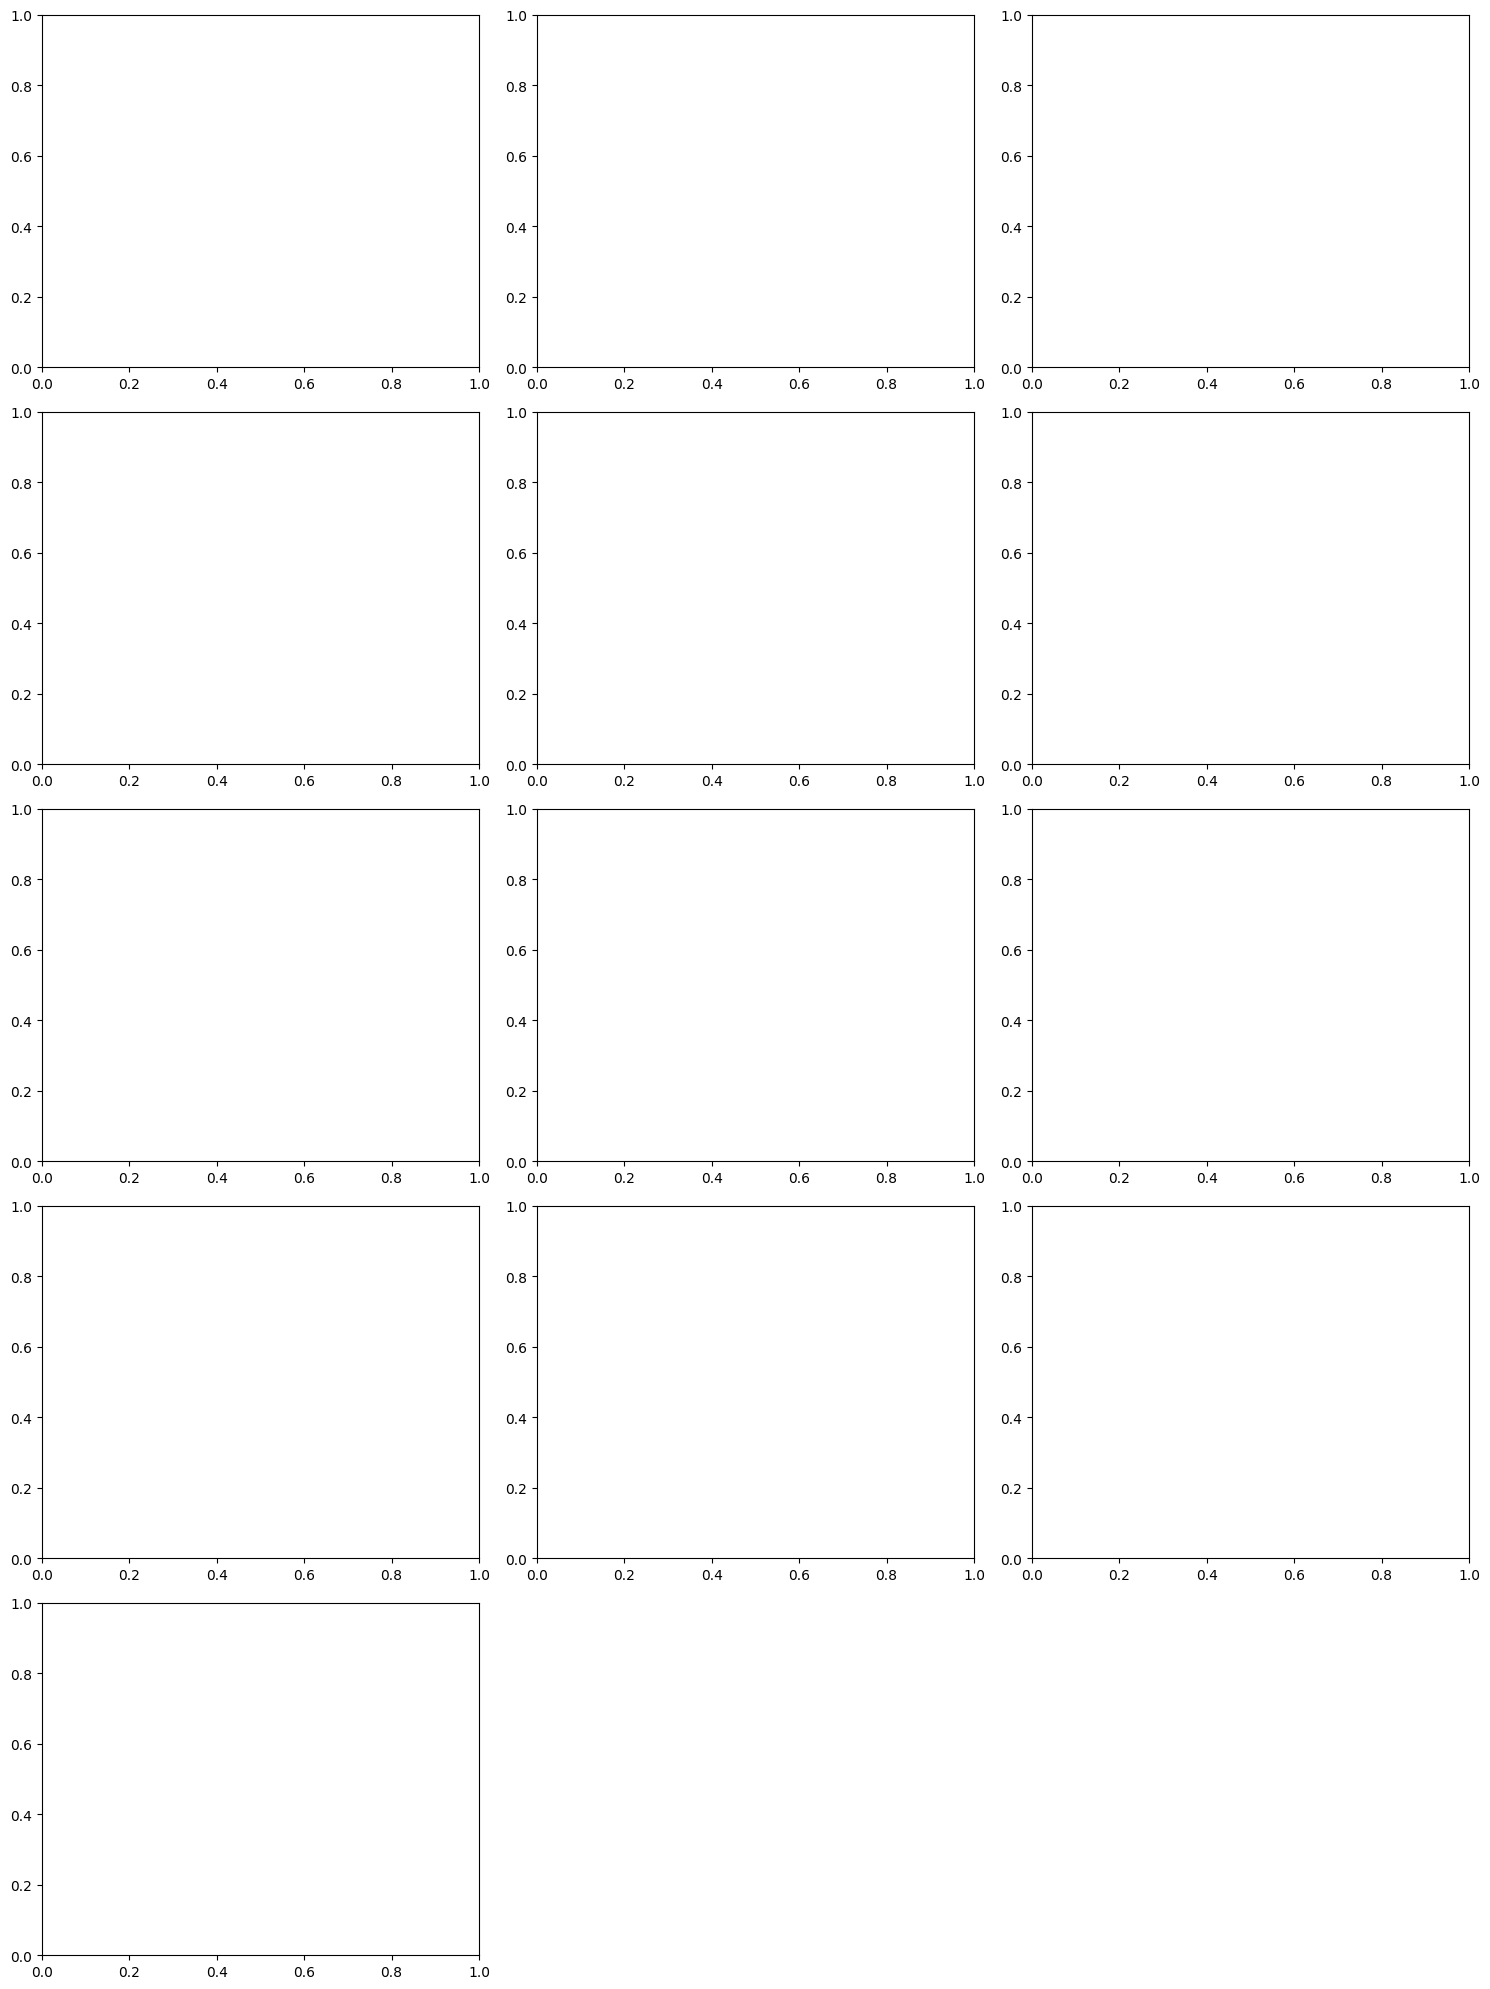

In [105]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = test_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(test_df.columns[start_idx:end_idx]):
        test_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

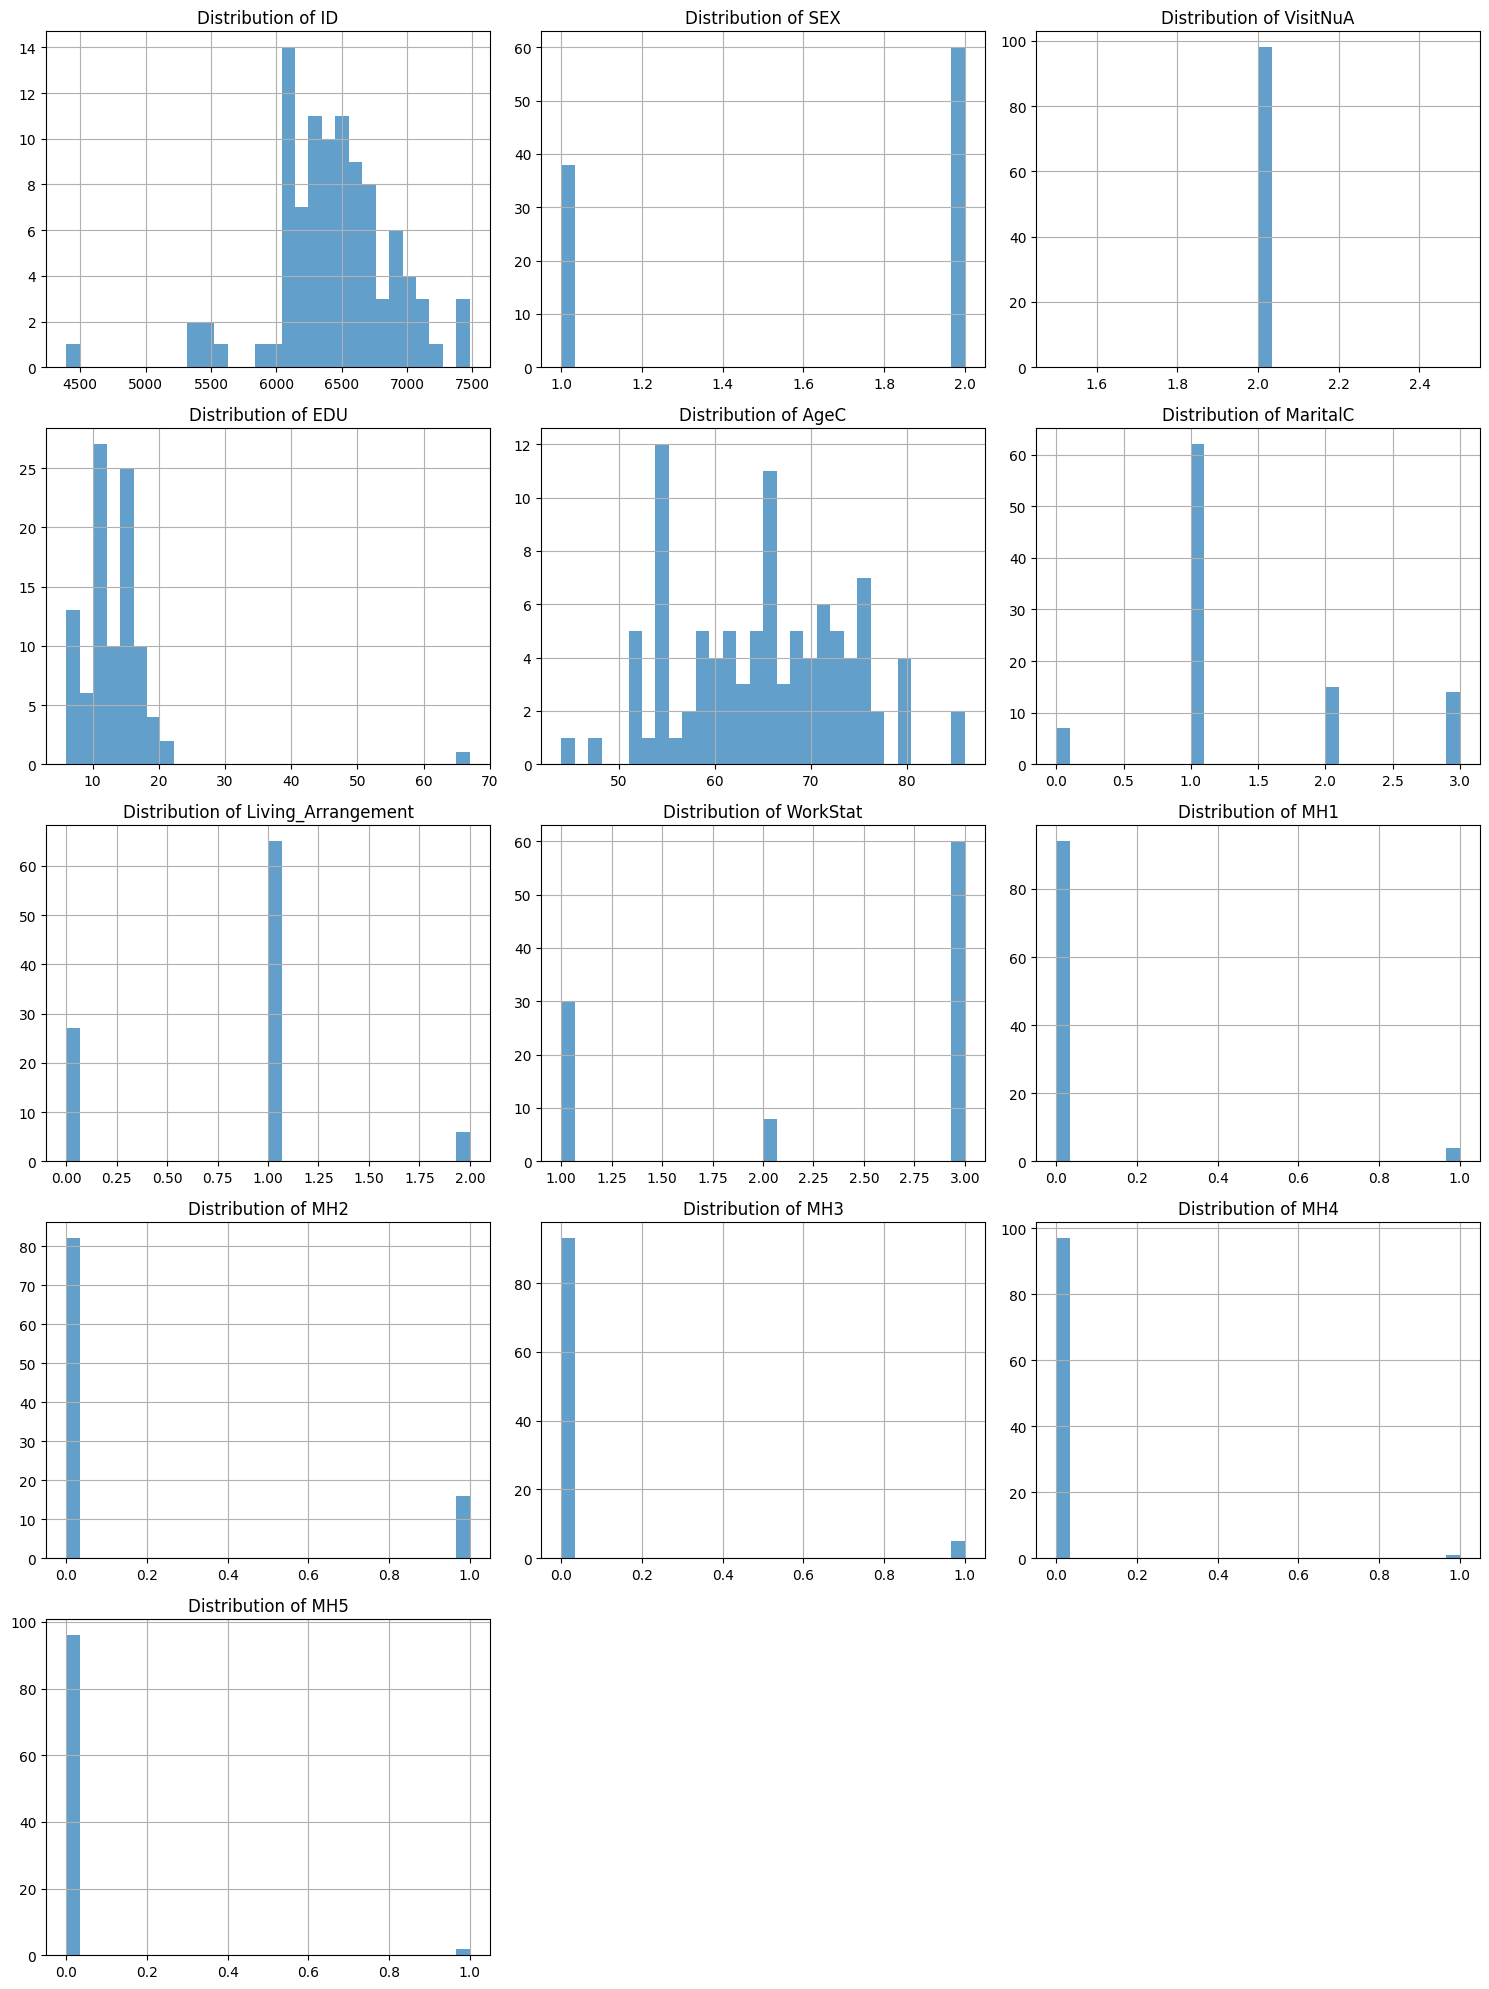

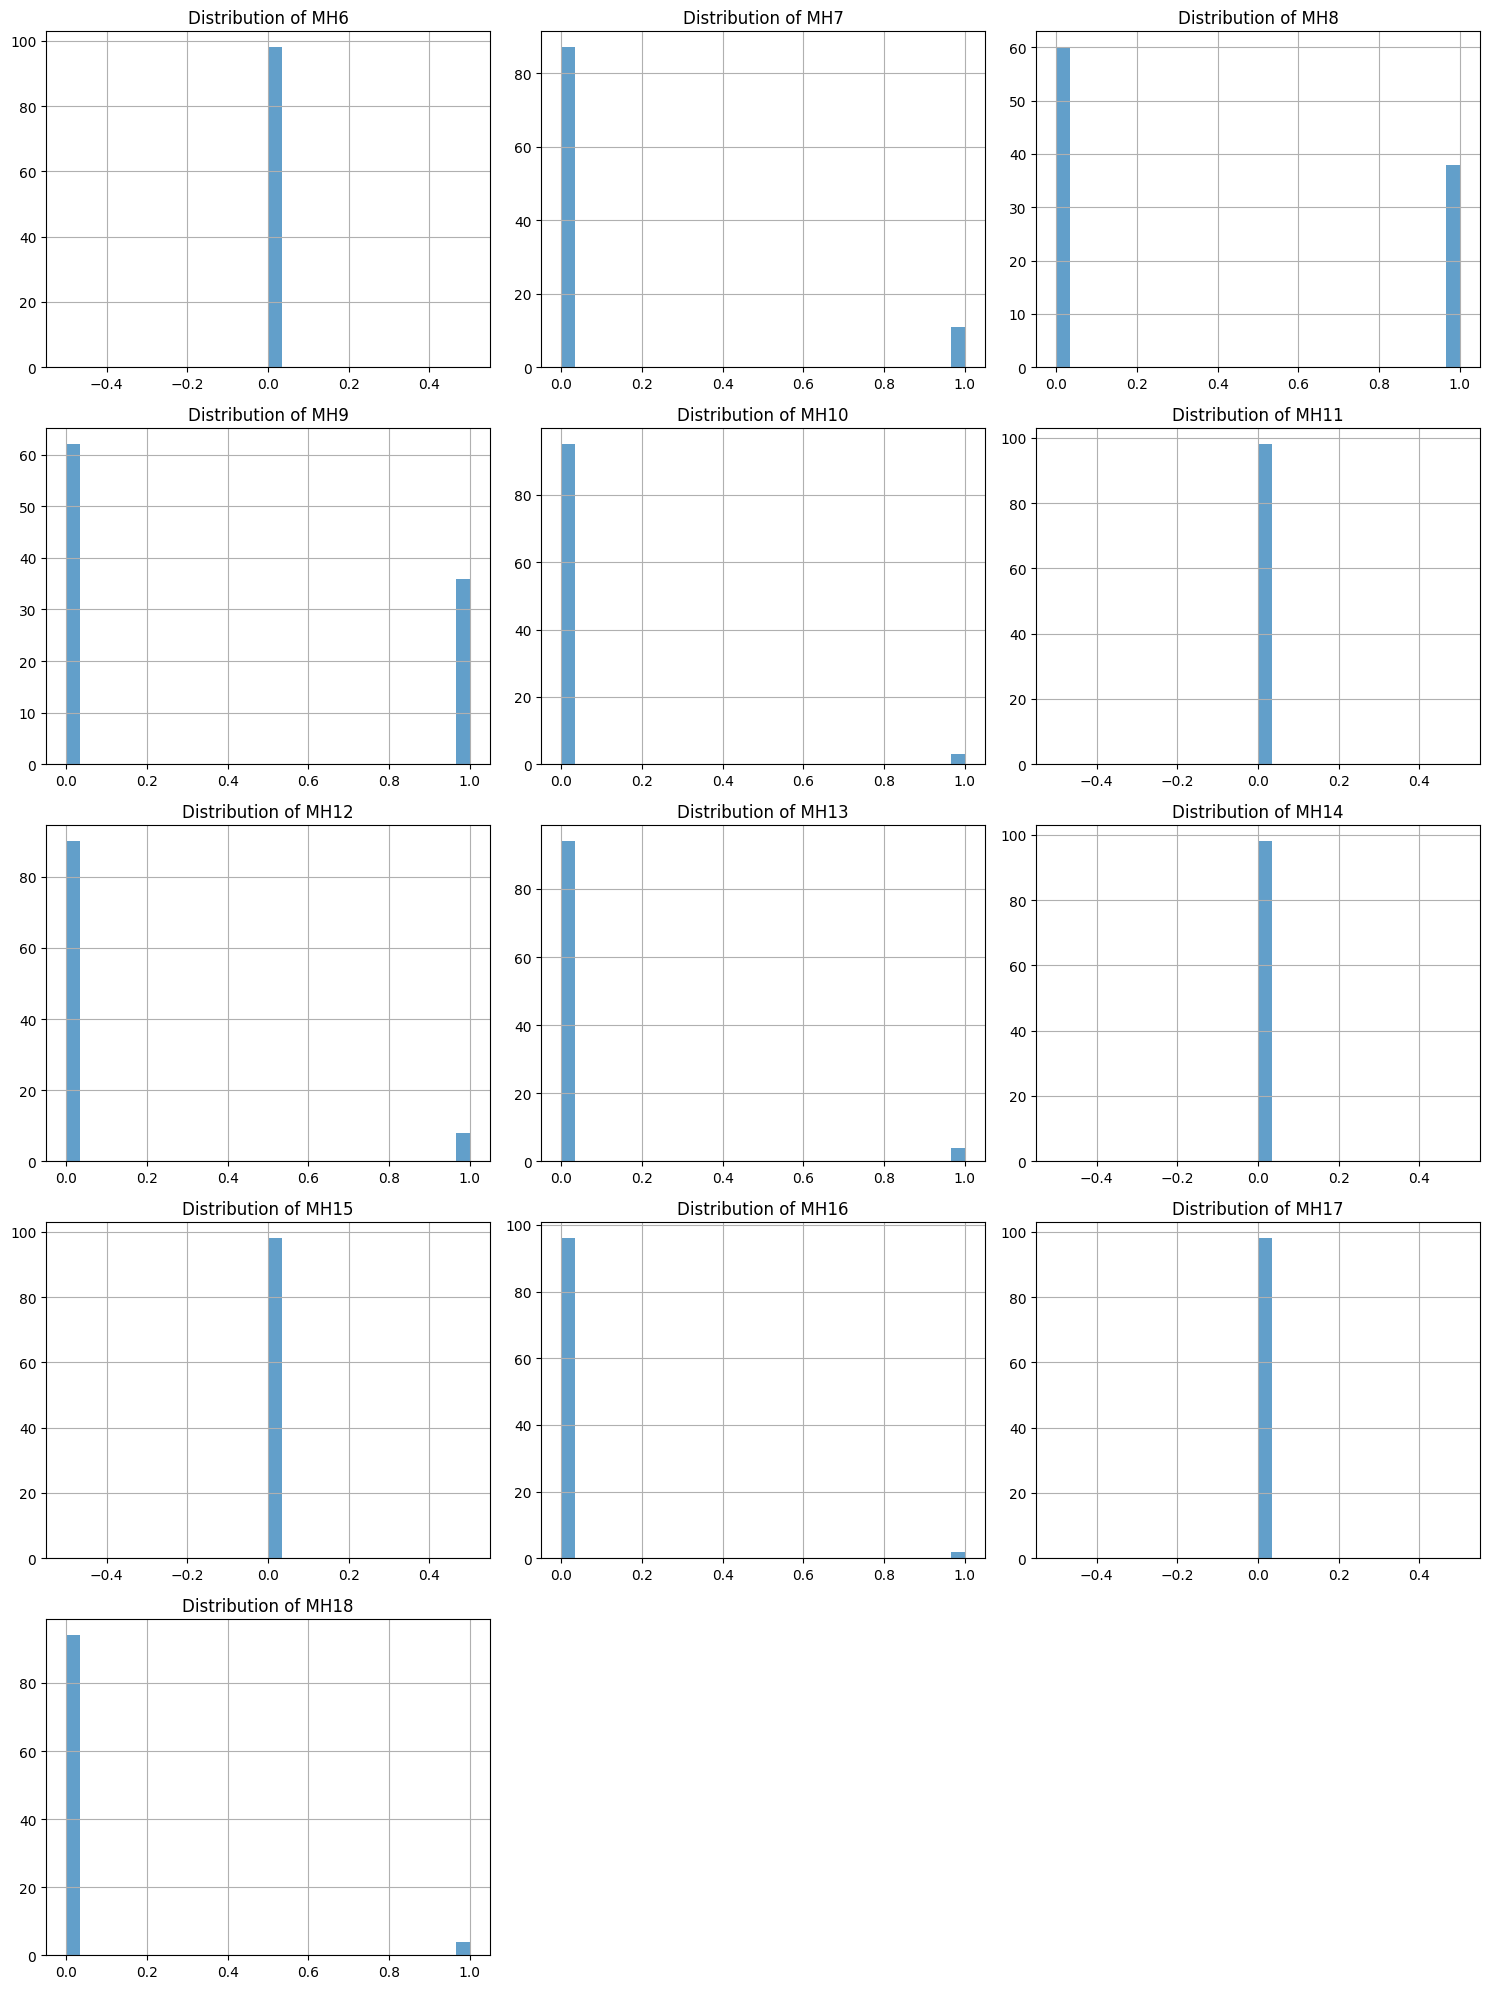

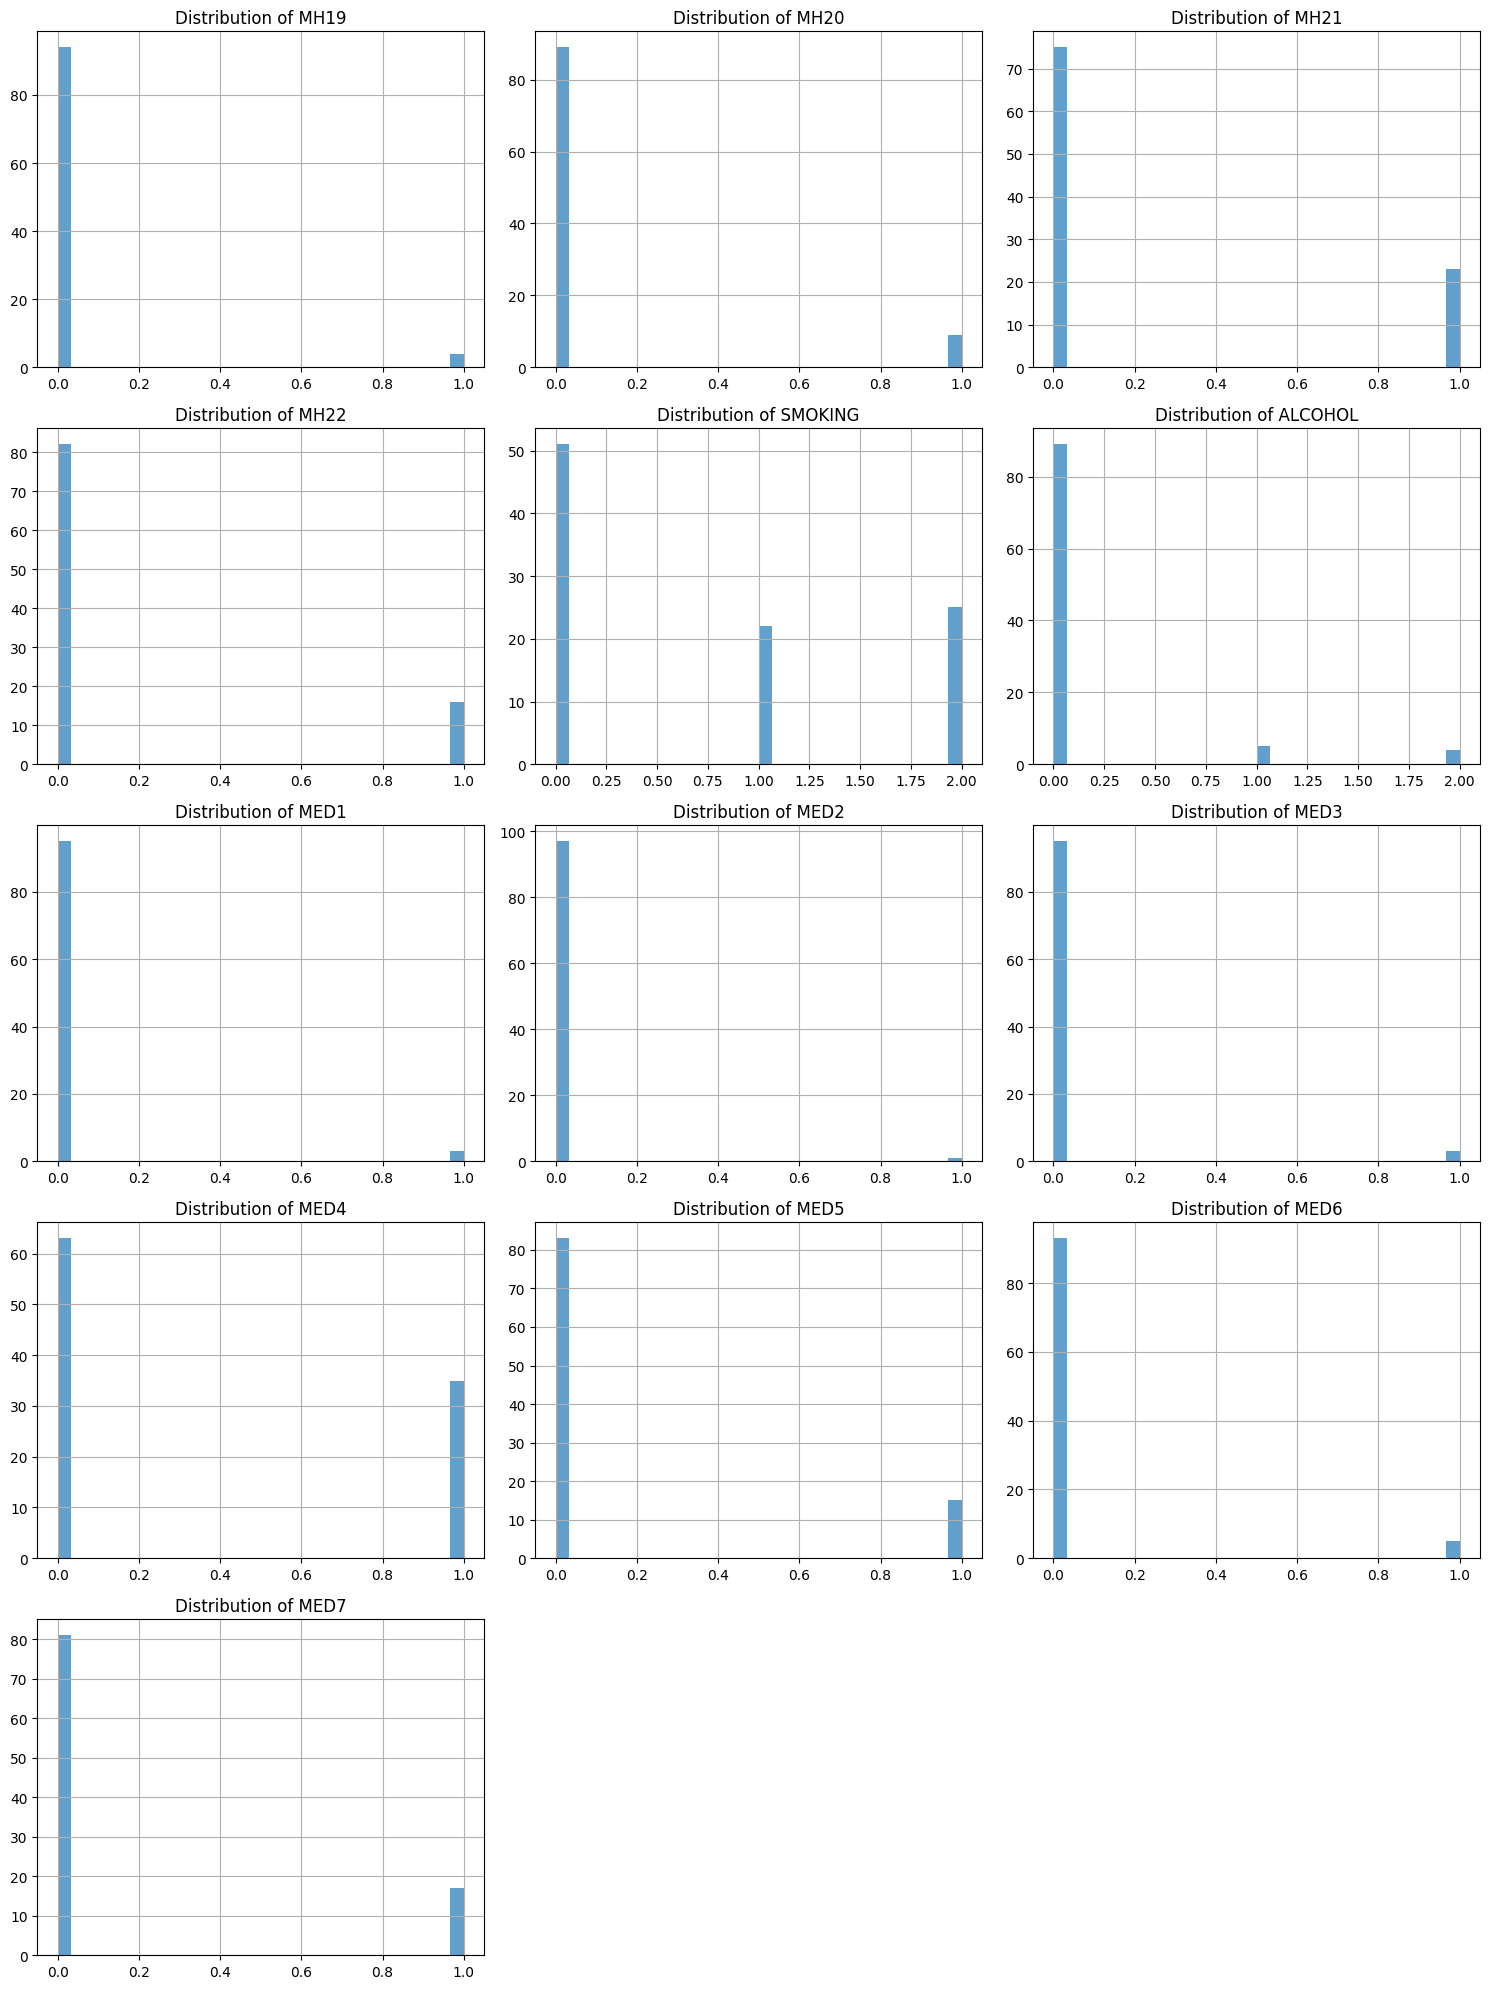

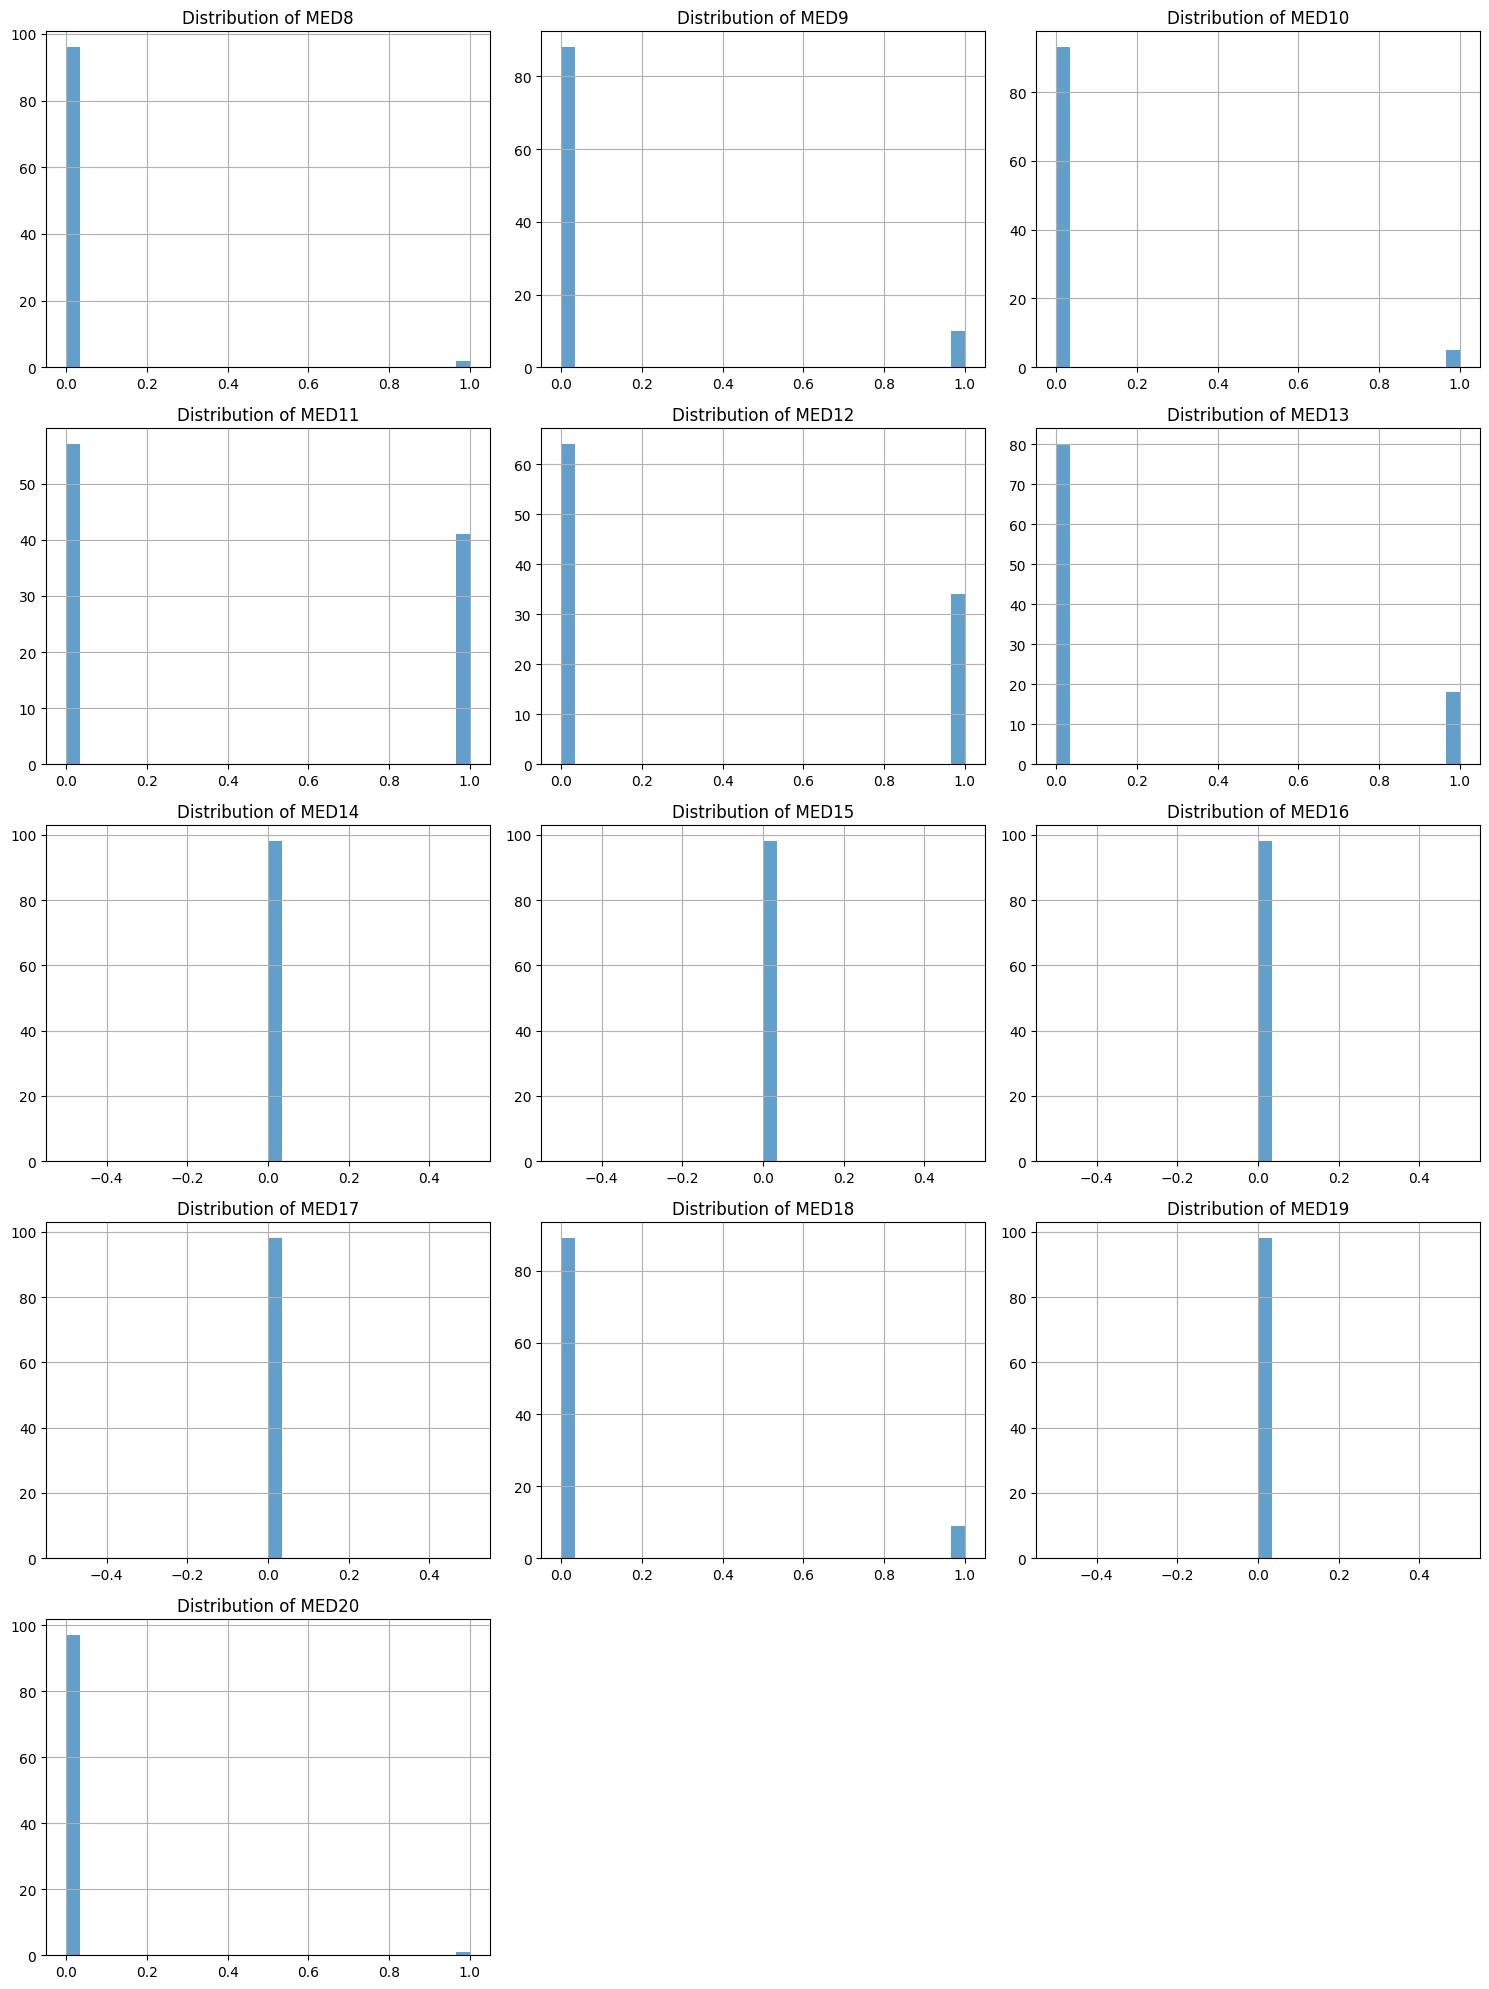

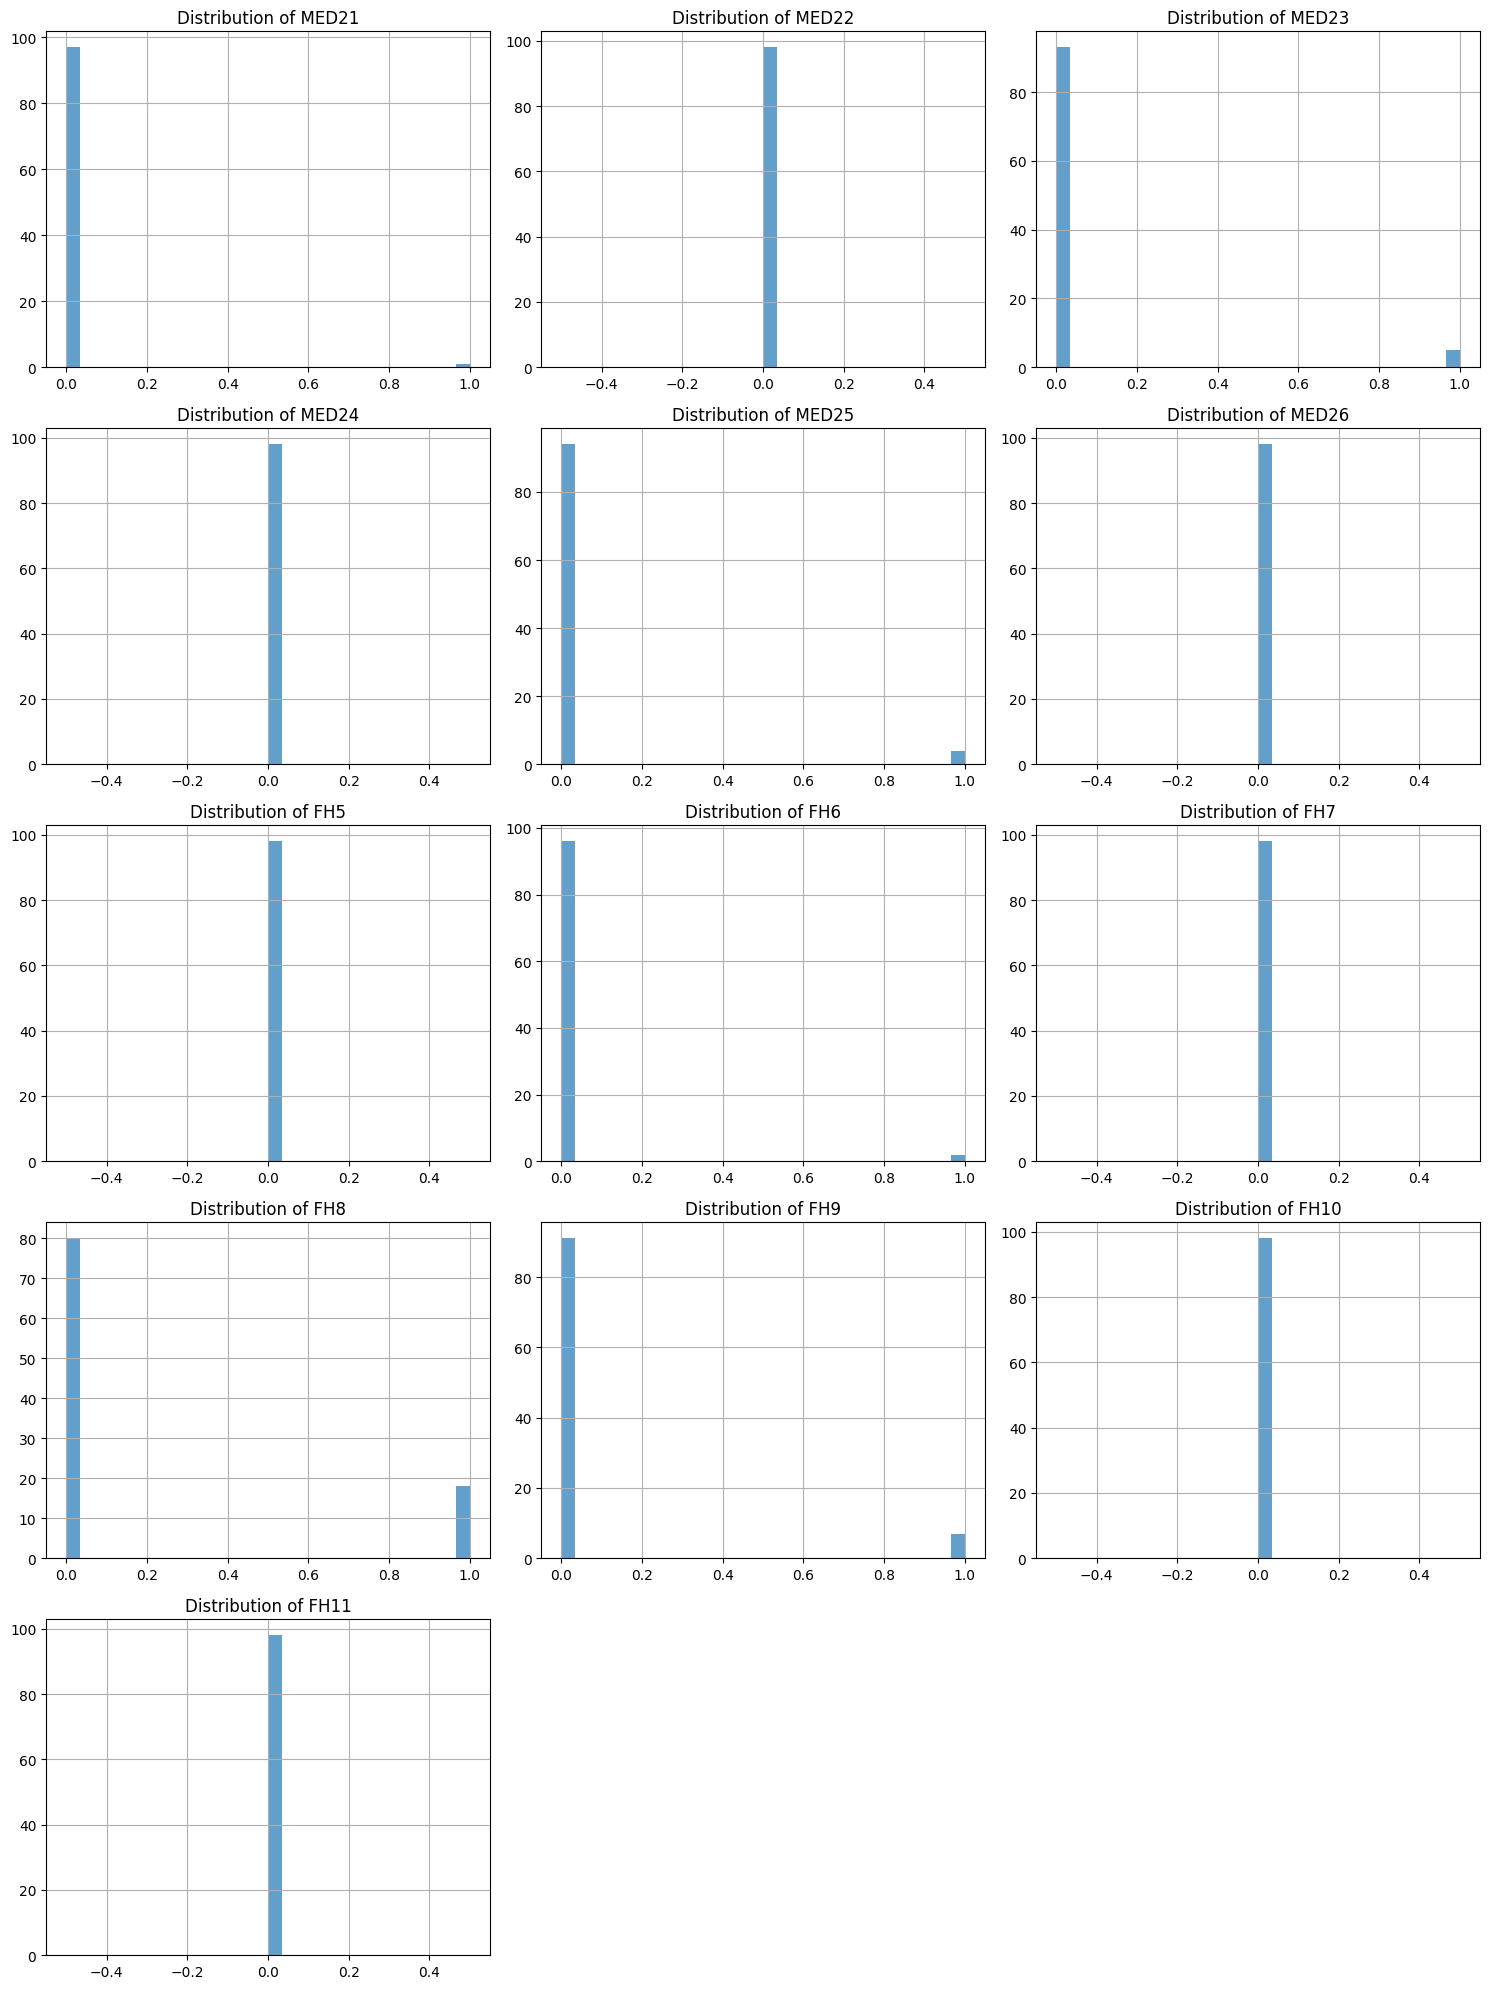

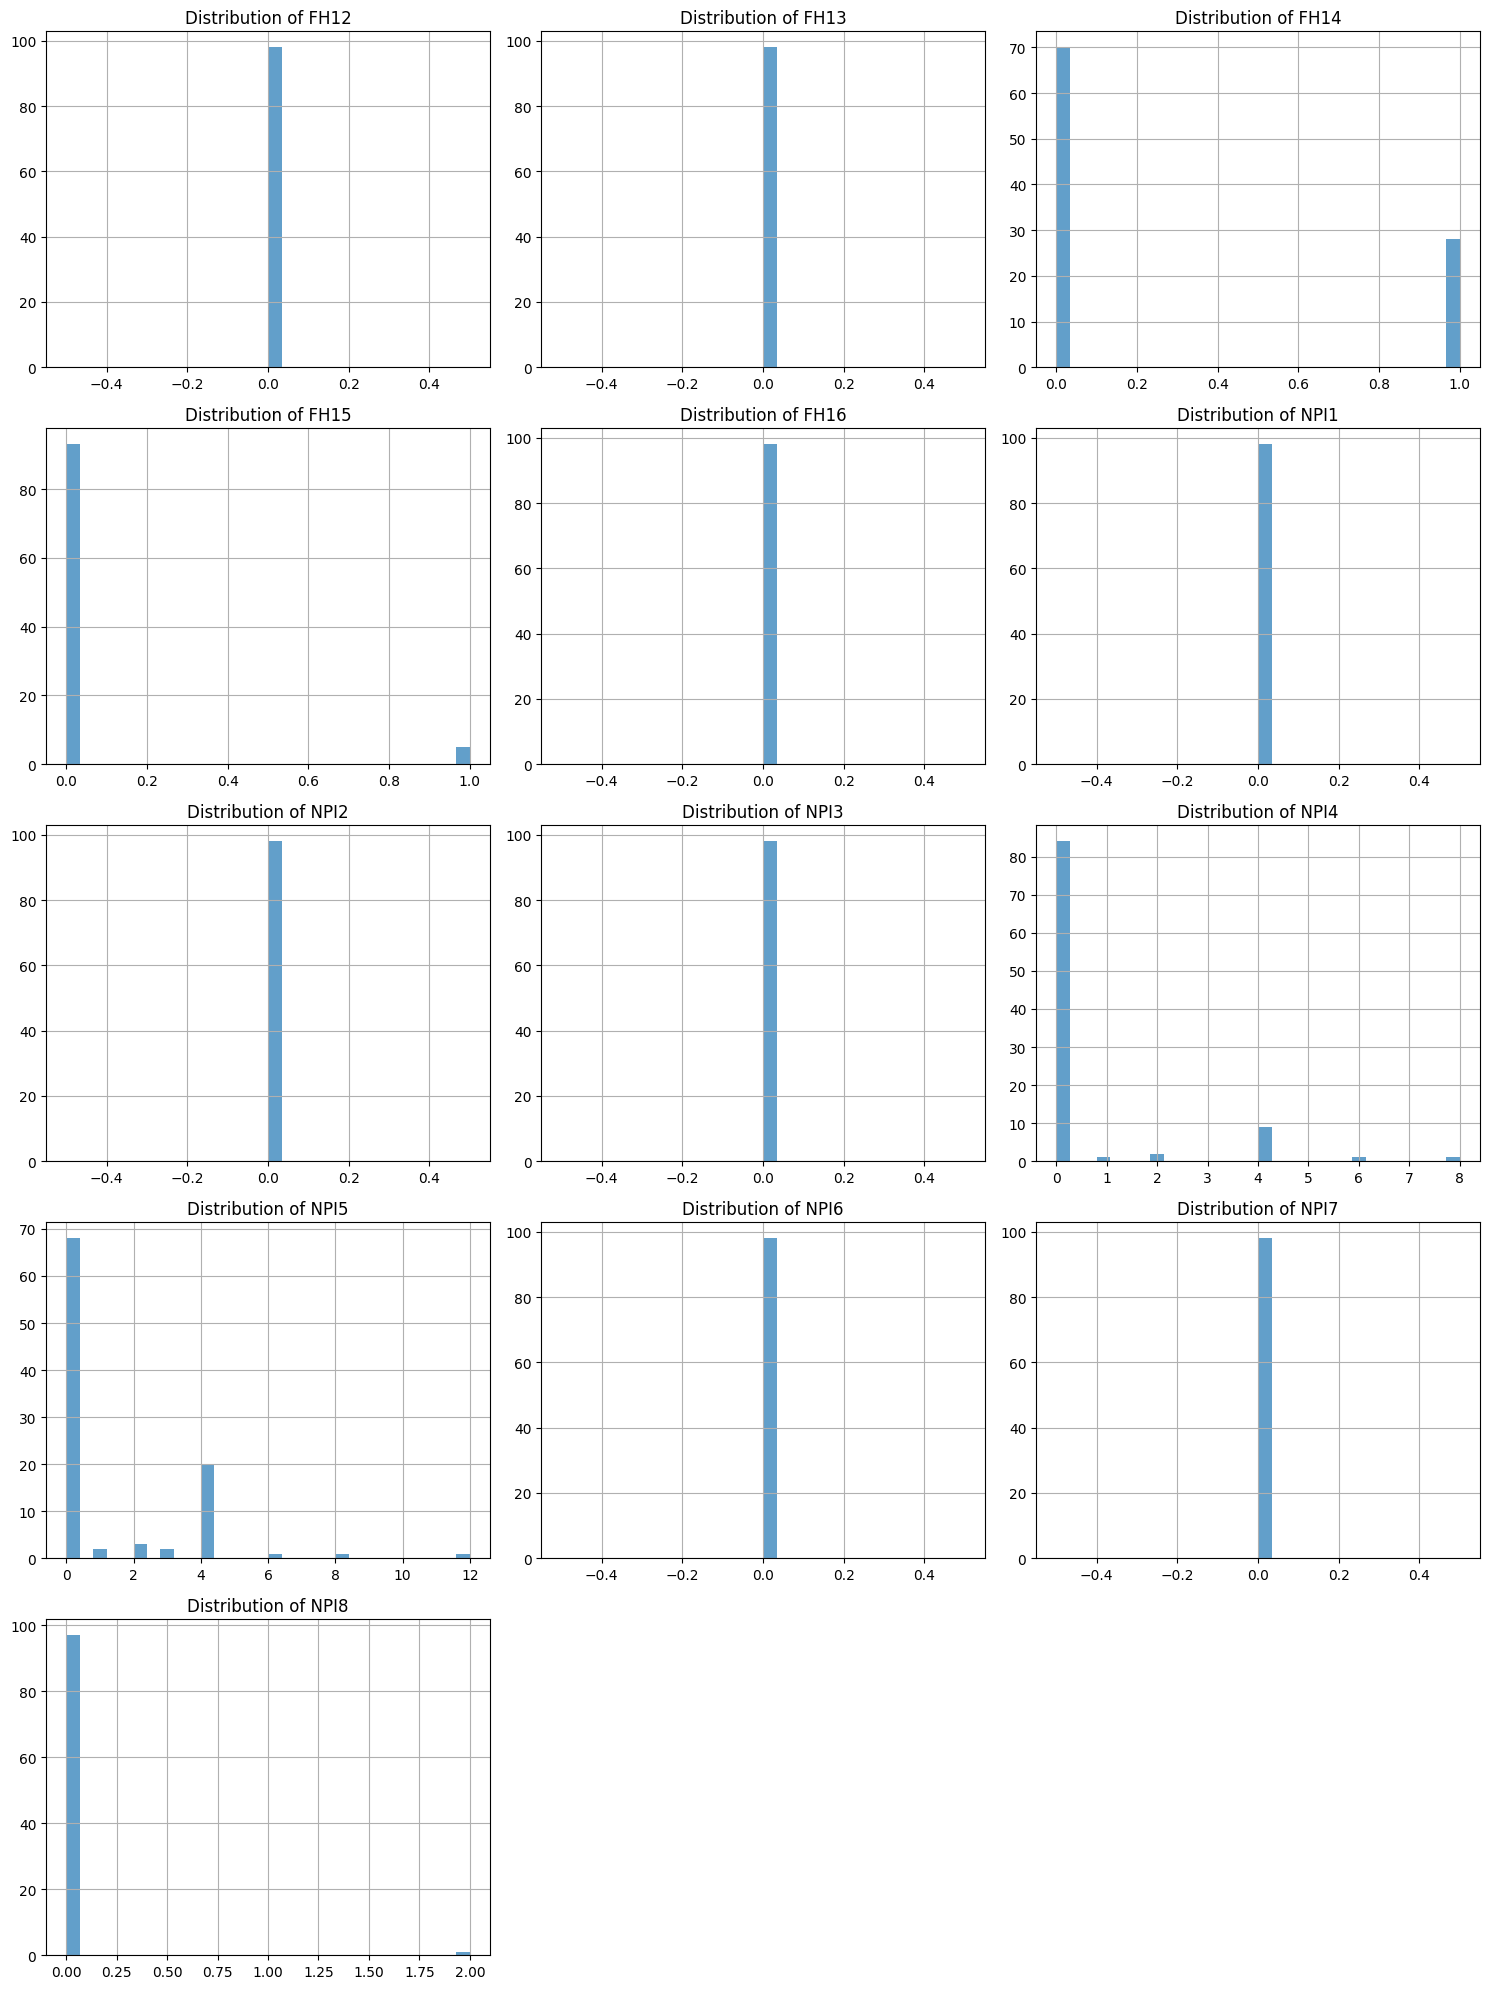

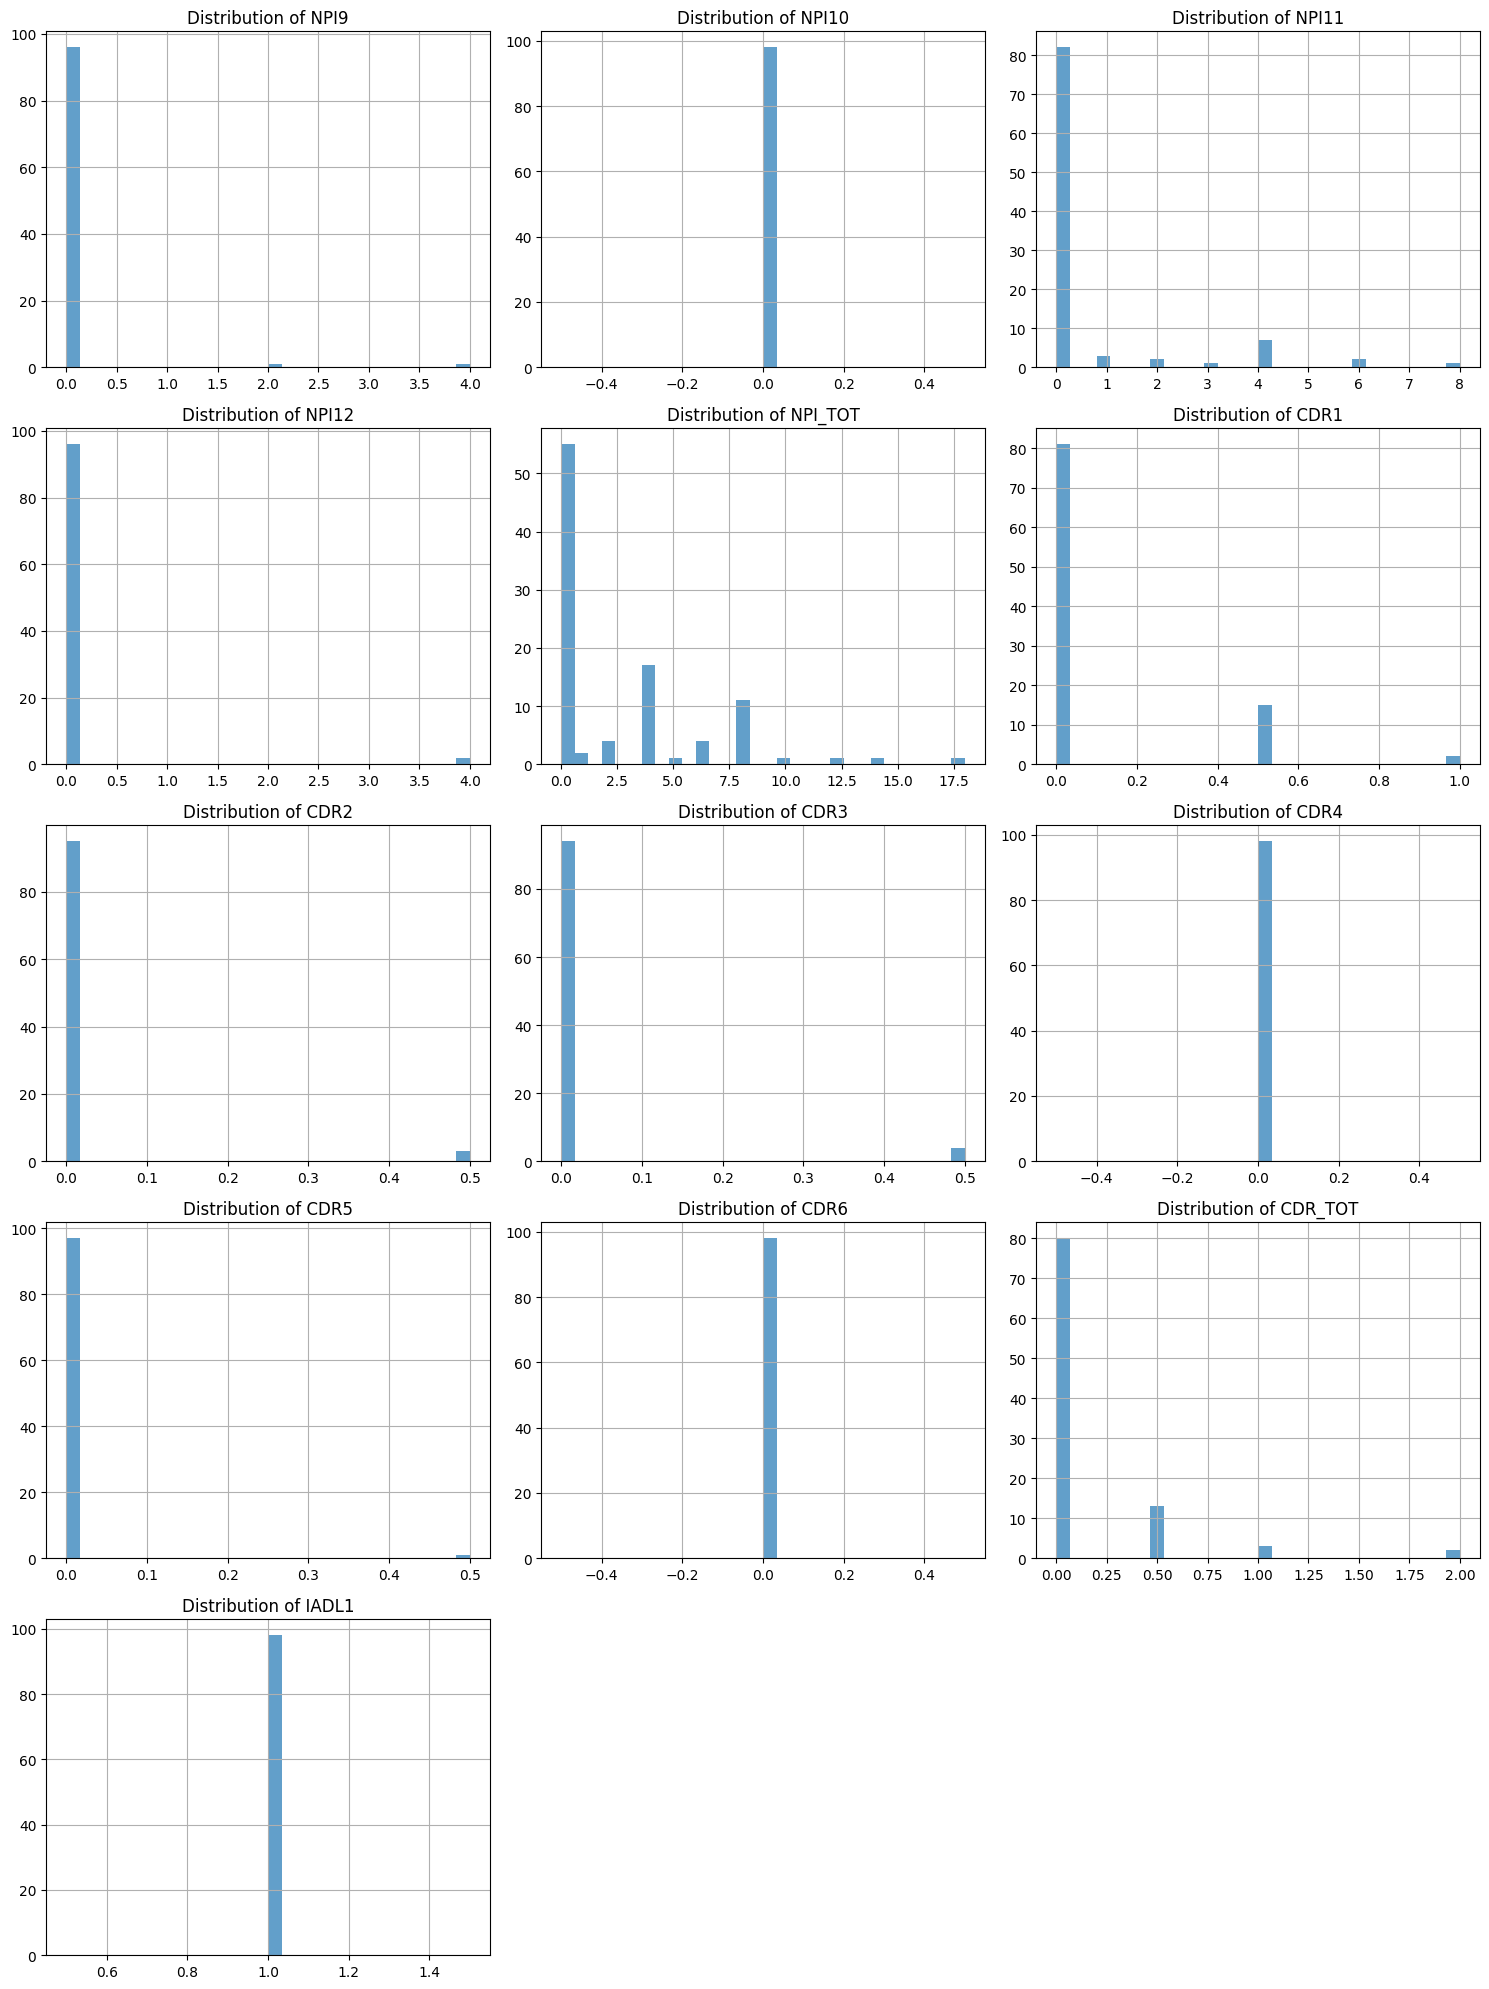

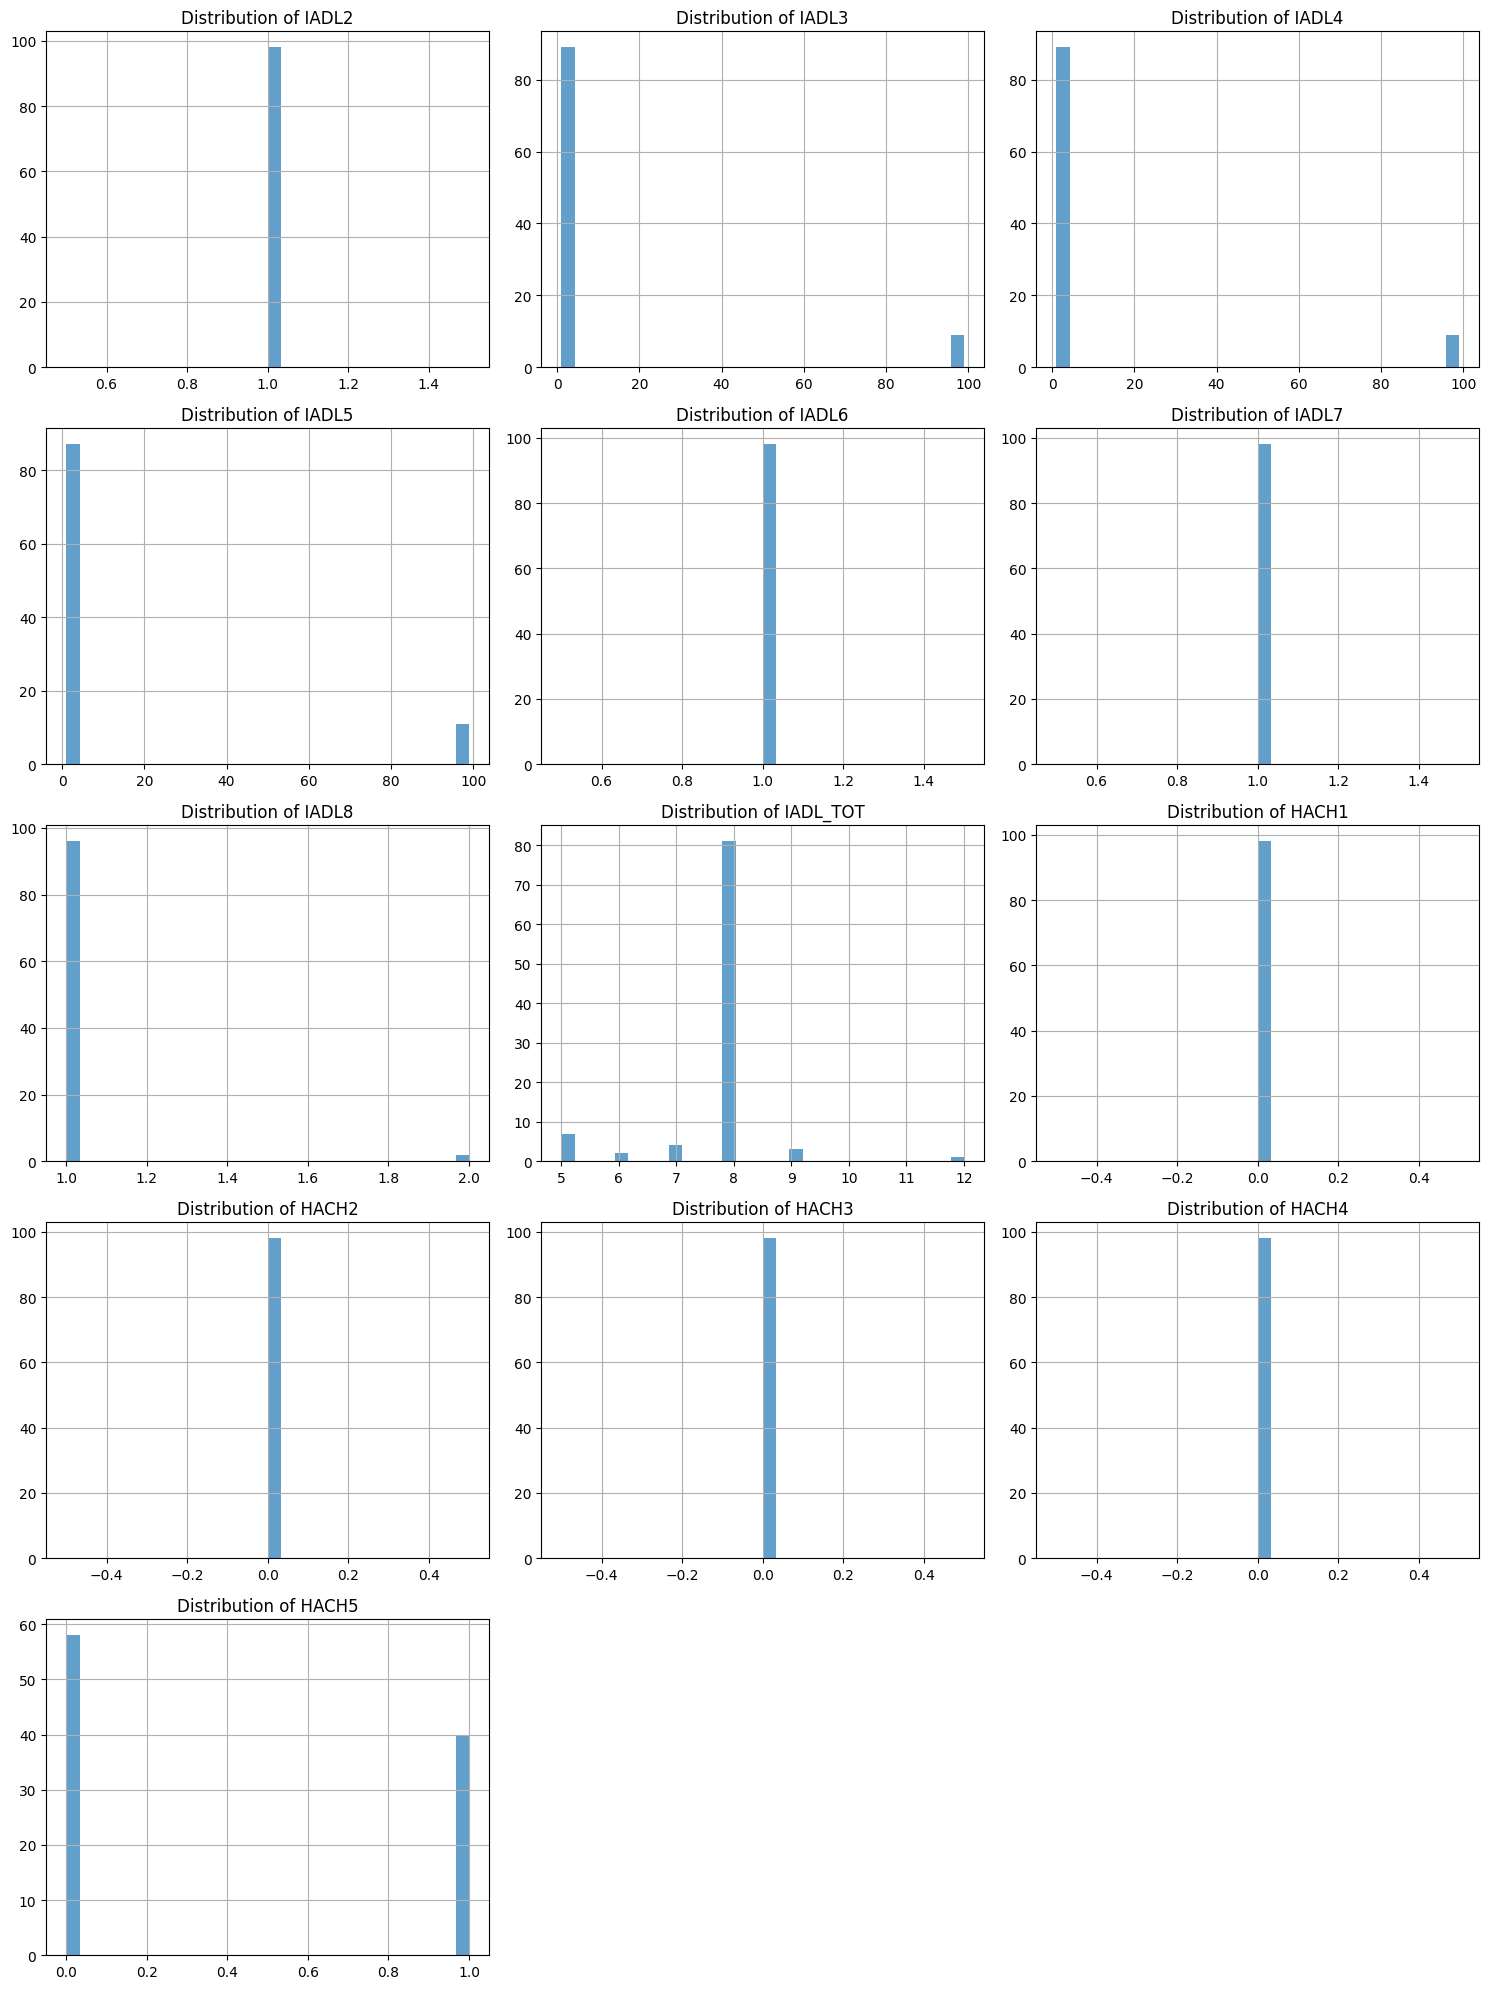

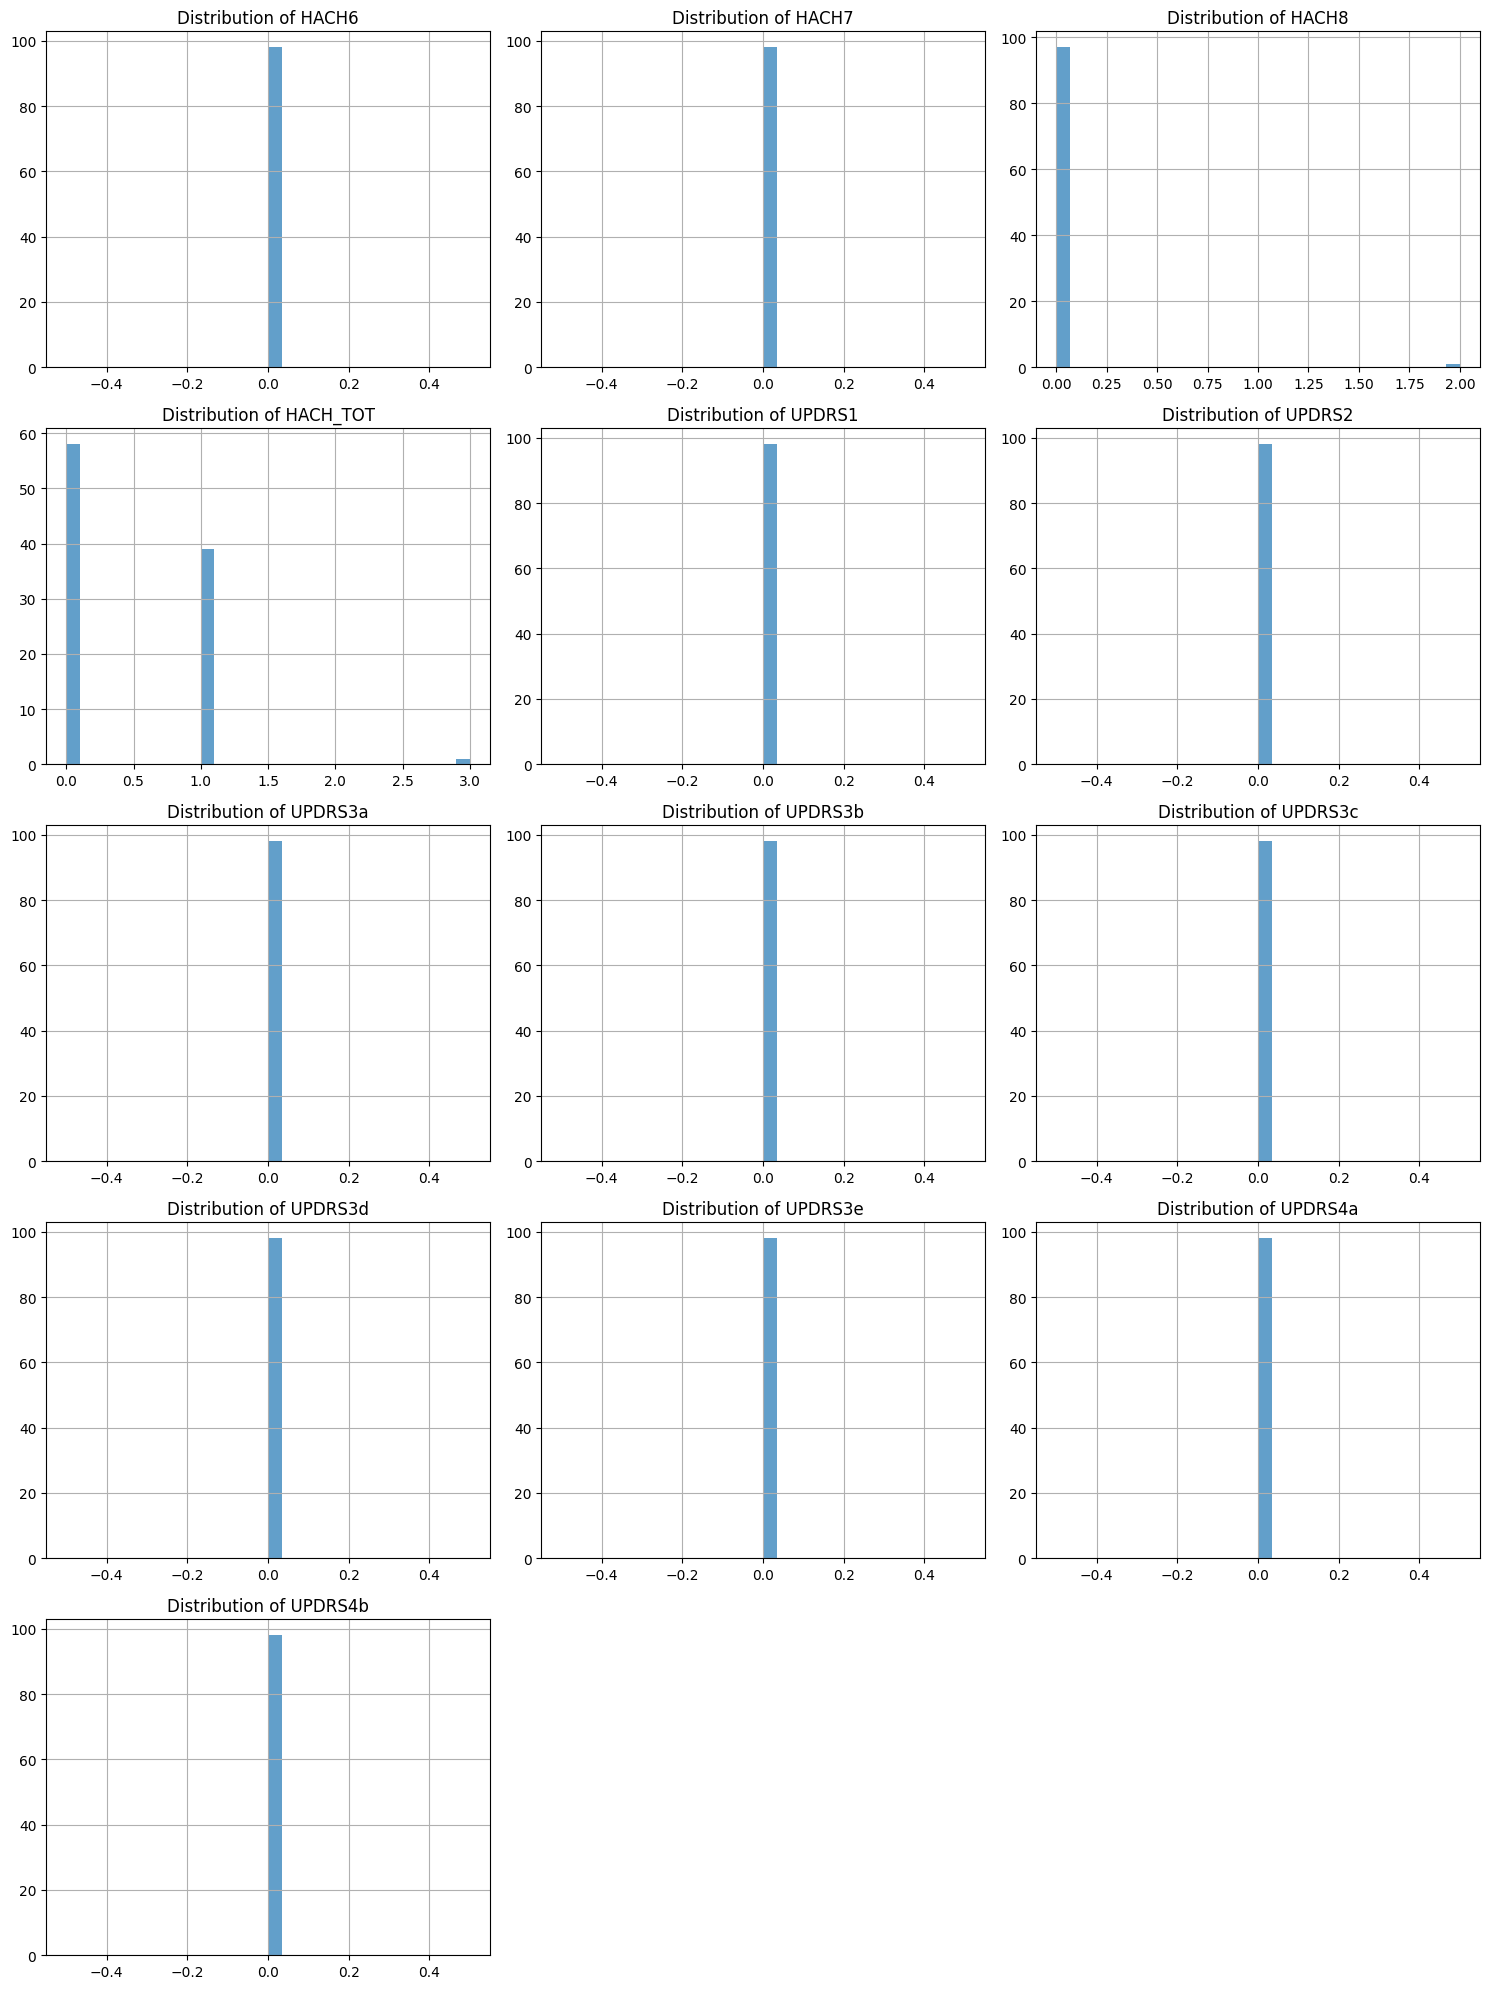

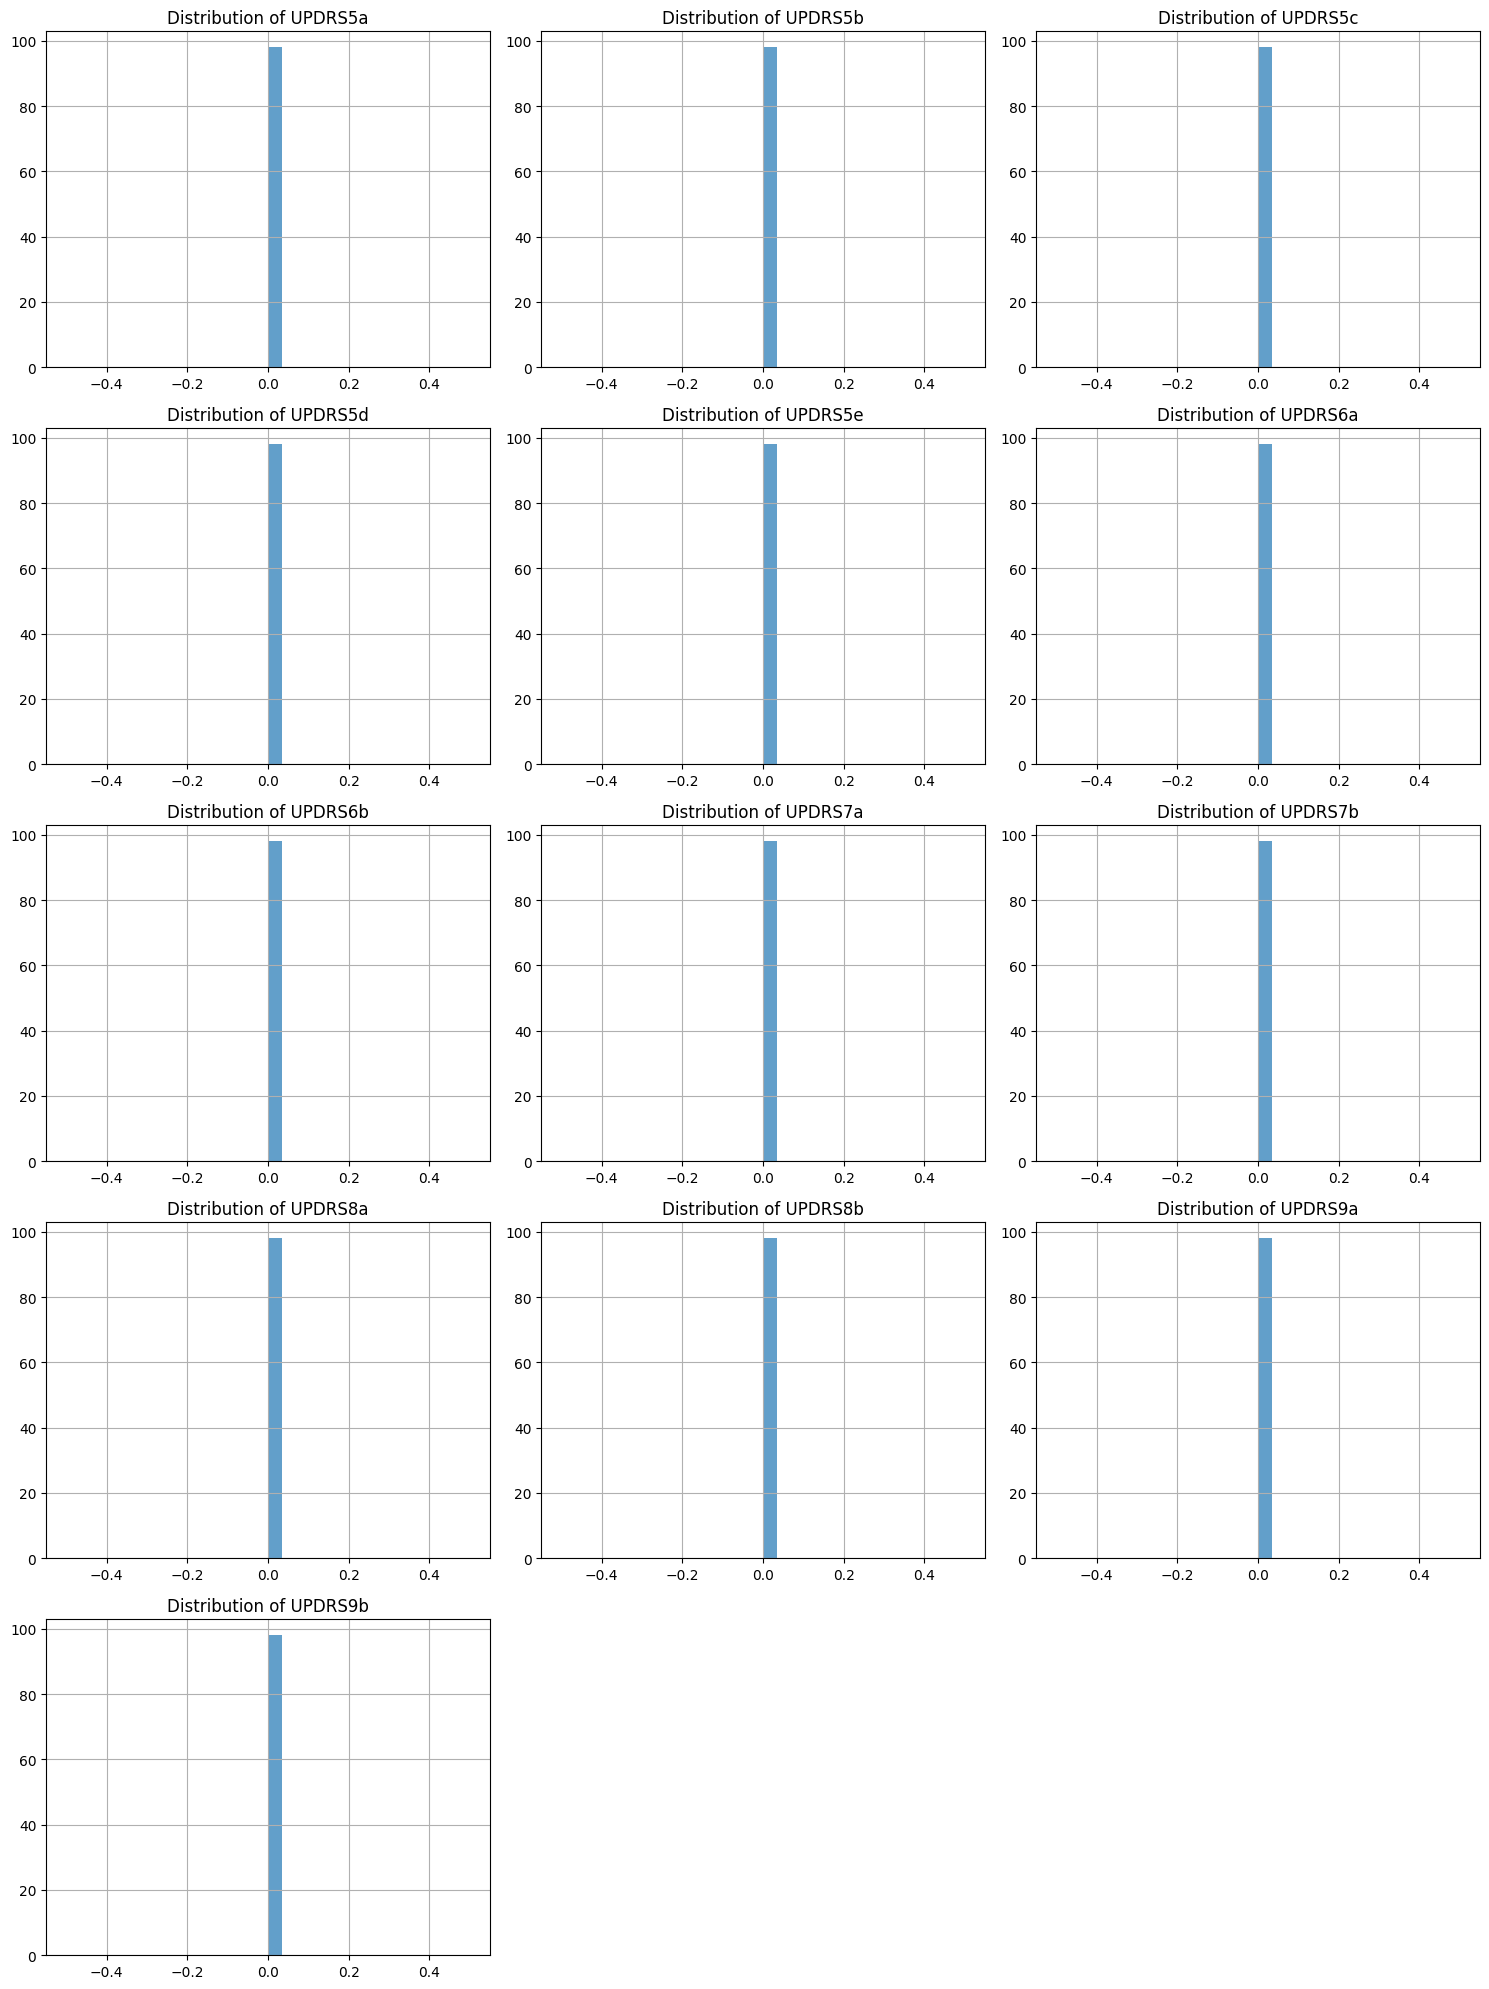

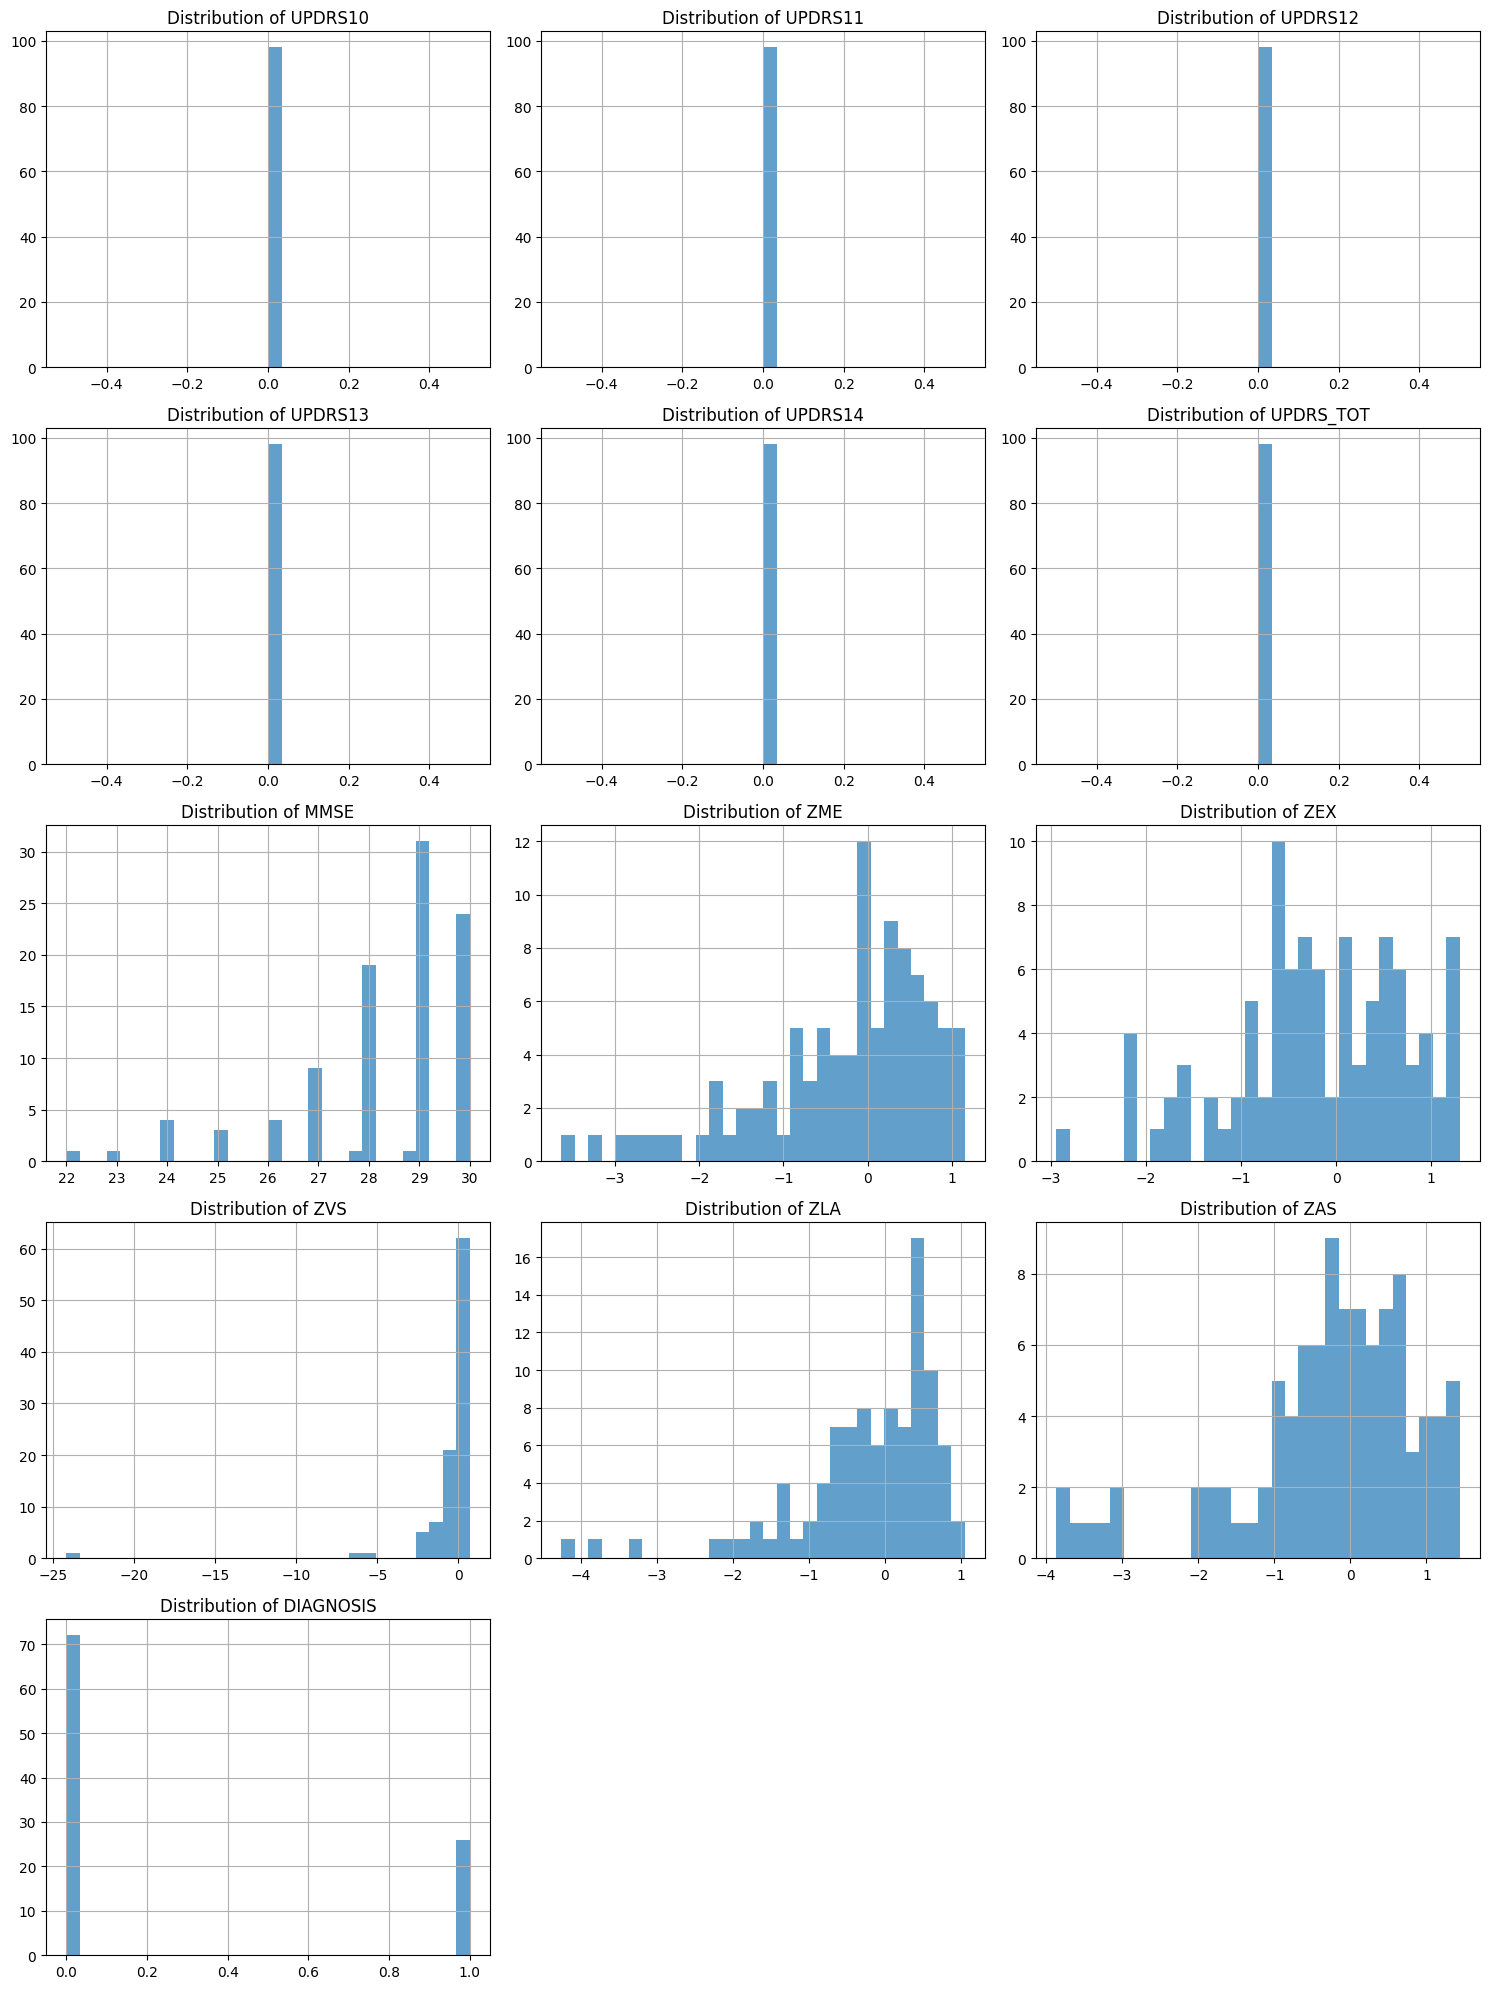

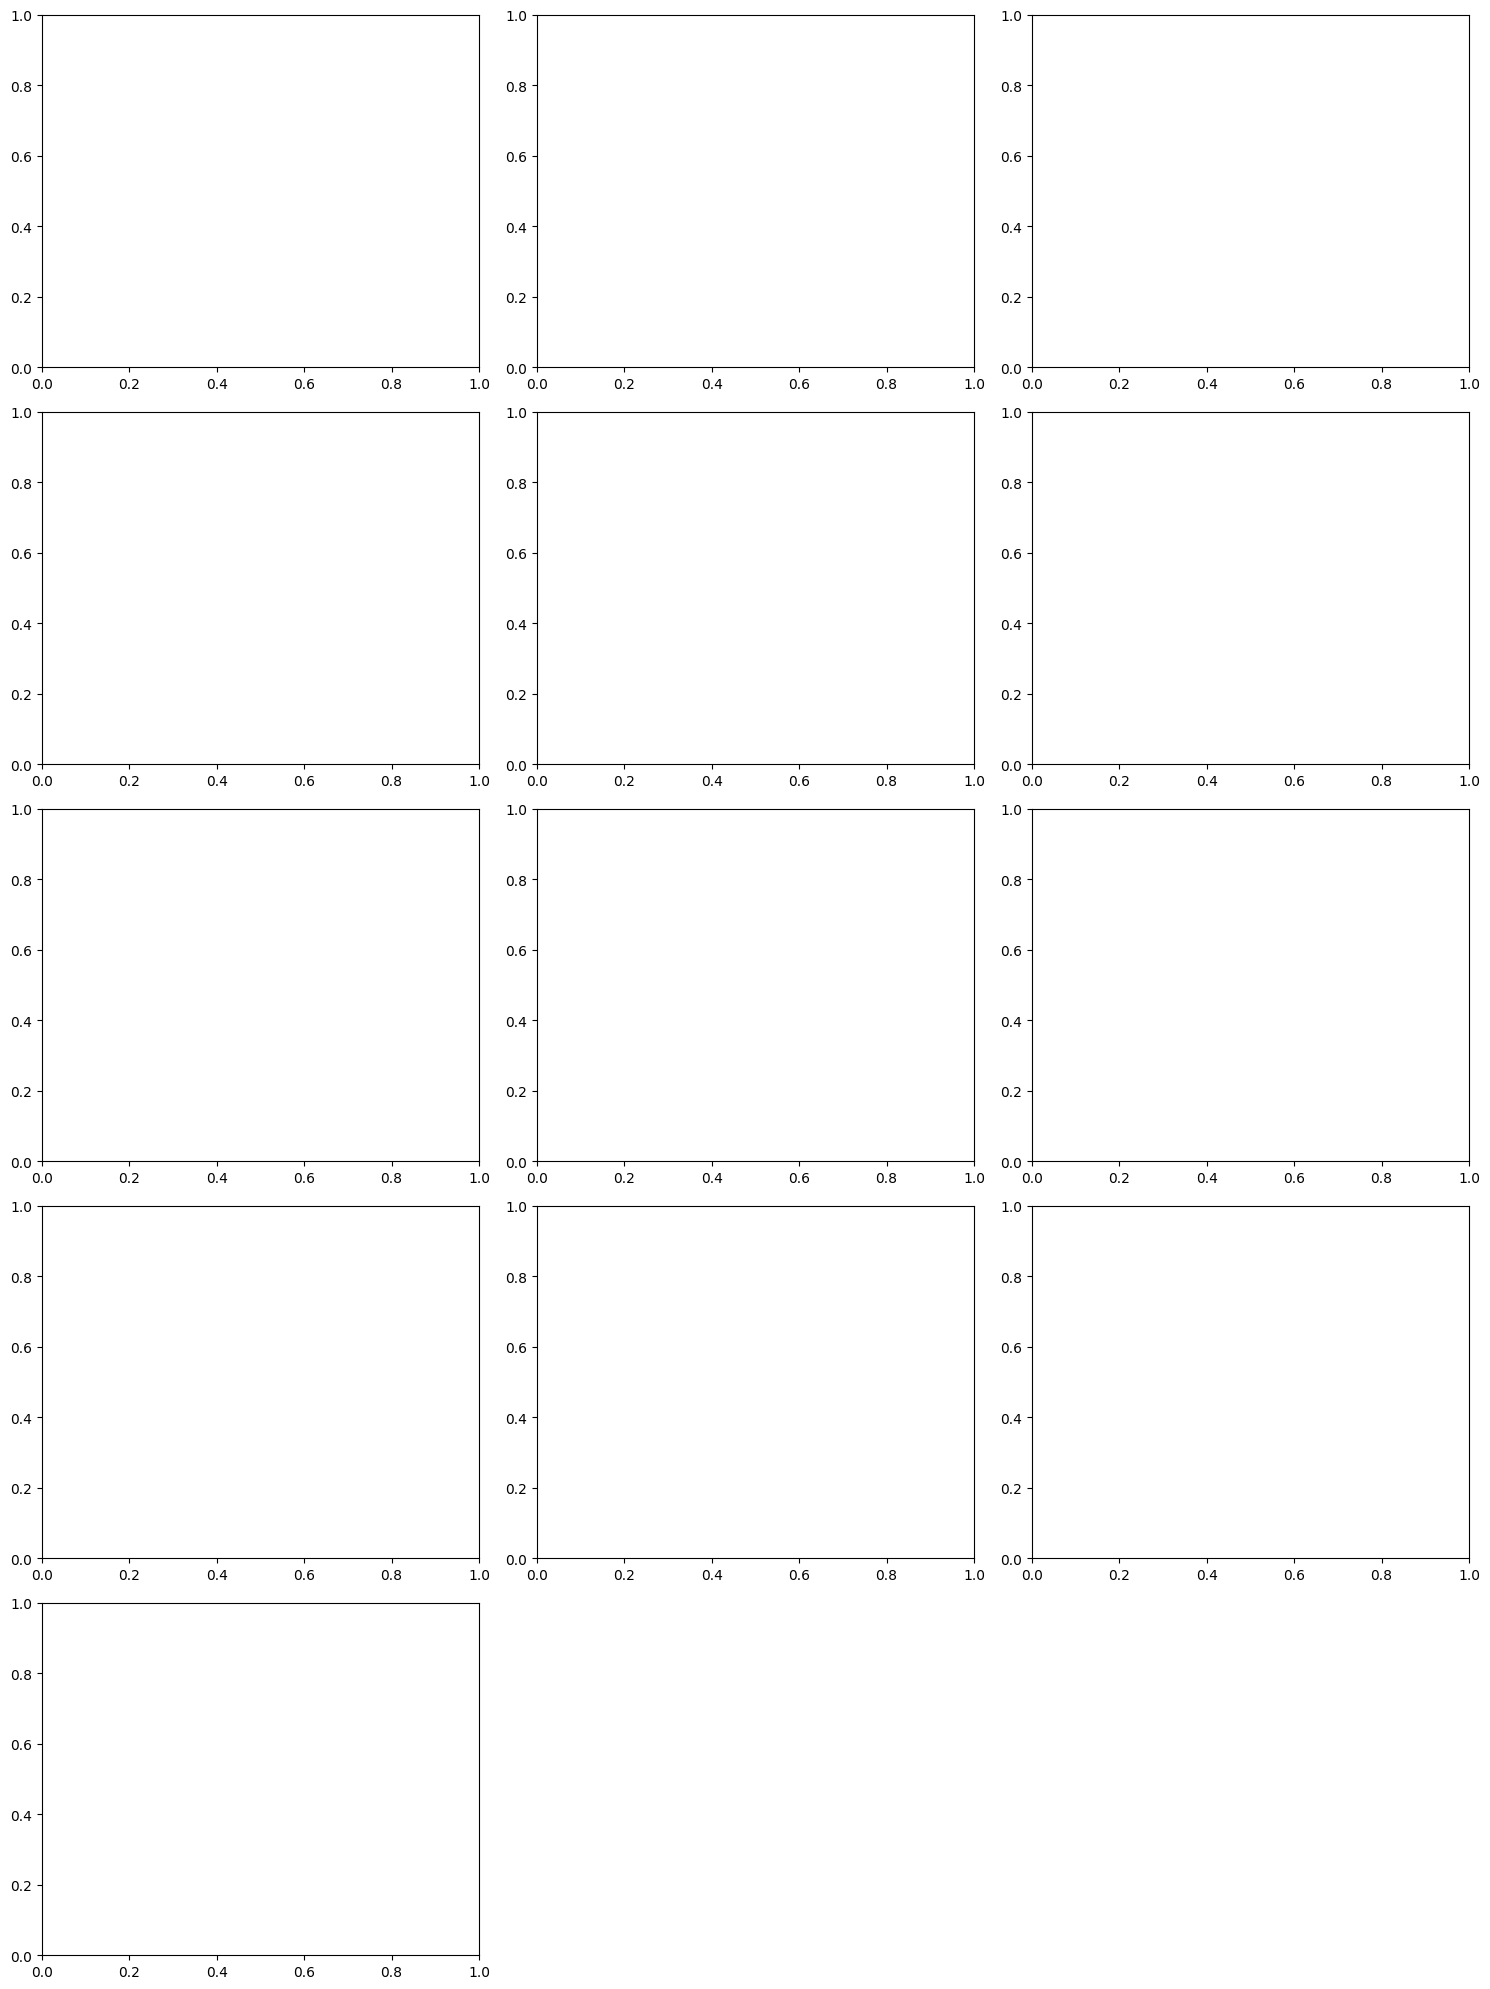

In [106]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = train_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(train_df.columns[start_idx:end_idx]):
        train_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [107]:
# Loop through all numerical columns to compare distributions using KS test for the training data
for column in train_df.columns:
    if train_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = train_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = train_df[column][train_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: VisitNuA
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.29896907216494845, p-value=1.0
KS test for Living_Arrangement: stat=0.22916666666666666, p-value=1.0
KS test for WorkStat: stat=0.631578947368421, p-value=0.11881969282558384
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19
Not enough da

In [108]:
# Loop through all numerical columns to compare distributions using KS test for the test data
for column in test_df.columns:
    if test_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = test_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = test_df[column][test_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: VisitNuA
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.2727272727272727, p-value=1.0
KS test for Living_Arrangement: stat=0.9090909090909091, p-value=0.2608695652173913
KS test for WorkStat: stat=0.7272727272727273, p-value=0.6086956521739131
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19


In [109]:
# Save train_df_copy and test_df_copy to csv
train_df_copy.to_csv('../data/train_df_NON_imputed_2ndvisit.csv', index=False)
test_df_copy.to_csv('../data/test_df_NON_imputed_2ndvisit.csv', index=False)